In [5]:
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt

# Define Helper Functions

In [6]:
def extract_data(filename, start_row, video_fps, num_frames):
    data = np.genfromtxt(filename, delimiter=',')
    data = data[start_row:, :]
    num_cols = data.shape[1]

    # Convert slow-mo to actual time
    t = data[:,0]
    T_slowmo = t[-1]
    T_actual = num_frames / video_fps
    multiplier = T_actual / T_slowmo
    t = multiplier * t

    if num_cols < 3:
        # Get leg angle
        theta = data[:,1]

        return t, theta
    else:
        # Get x and z position data
        x = data[:,1]
        z = data[:,2]

        return t, x, z

def filter(z, fs, fc):
    w = fc / (fs / 2) # Normalized cut-off frequency
    b, a = scipy.signal.butter(N=5, Wn=w, btype='lowpass')
    z_filter = scipy.signal.filtfilt(b, a, z)
    return z_filter

def finite_forward_difference(t, z):
    zdot = np.zeros(len(z) - 1)
    tdot = t[1:]

    for i in range(len(t) - 1):
        dt = t[i+1] - t[i]
        zdot[i] = (z[i+1] - z[i]) / dt

    return tdot, zdot

def coefficient_of_restitution(v):
    cor = np.abs(np.max(v) / np.min(v))
    return cor

def underdamped_func(t, c1, c2, tau1, tau2, w1, w2):
    return c1 * np.exp(-t / tau1) * np.cos(w1 * t) + c2 * np.exp(-t / tau2) * np.sin(w2 * t)

In [7]:
def plot_spring_flicker_test(filename, leg_name, video_fps, num_frames, p0=None):
    print(filename)

    b_set = []
    k_set = []

    # Plot flicker test curve fit
    fig_ficker_fit, ax_flicker_fit = plt.subplots(1, 1, figsize=(18, 5))
    fig_ficker_fit.suptitle(f"{leg_name}: Flicker Test Curve Fit")

    t, theta = extract_data(filename=filename, start_row=2, video_fps=video_fps, num_frames=num_frames)

    # Normalize angle about 0deg
    theta = theta - np.mean(theta)

    # Optimize exponential decay
    exp_decay_opt, exp_decay_cov = scipy.optimize.curve_fit(underdamped_func, t, theta, p0, bounds=(0,np.inf), max_nfev=5000)
    c1, c2, tau1, tau2, w1, w2 = exp_decay_opt

    tau = np.average((tau1, tau2))
    # w = w1
    w = w1

    print(f"c1: {c1}, c2: {c2}, tau1: {tau1}, tau2: {tau2}, w1: {w1}, w2: {w2}")
    print(f"tau: {tau}, w: {w}")

    # Leg properties
    m_leg = 3e-6
    L_leg = 28e-3
    I_leg = 1/3 * m_leg * L_leg ** 2
    
    # Calculate b and k
    b = 2 * I_leg / tau
    k = I_leg * (w**2 + (1 / tau)**2)

    print(f"b: {b}, k: {k}")

    b_set.append(b)
    k_set.append(k)


    ax_flicker_fit.plot(t, theta, label="Raw data")
    ax_flicker_fit.axhline(y=0, color='k')

    # Plot fitted data
    ax_flicker_fit.plot(t, underdamped_func(t, c1, c2, tau1, tau2, w1, w2), label="Curve Fit")
    ax_flicker_fit.plot(t, underdamped_func(t, 1, 0, np.inf, np.inf, w1, 0), linestyle="--", label="Harmonic fit")
    ax_flicker_fit.plot(t, underdamped_func(t, c1, c2, tau1, tau2, 0, w2), linestyle="--", label="Exponential fit")

    # Plot labels
    ax_flicker_fit.set_xlabel("t (s)")
    ax_flicker_fit.set_ylabel(r"$\theta$ ($^\circ$)")

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Compliant Legs/Flicker Test/Flicker Test v1/skeleton_joint_25um_1000fps_at_30fps_1200frames_4800-6000.txt


FileNotFoundError: /Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Compliant Legs/Flicker Test/Flicker Test v1/skeleton_joint_25um_1000fps_at_30fps_1200frames_4800-6000.txt not found.

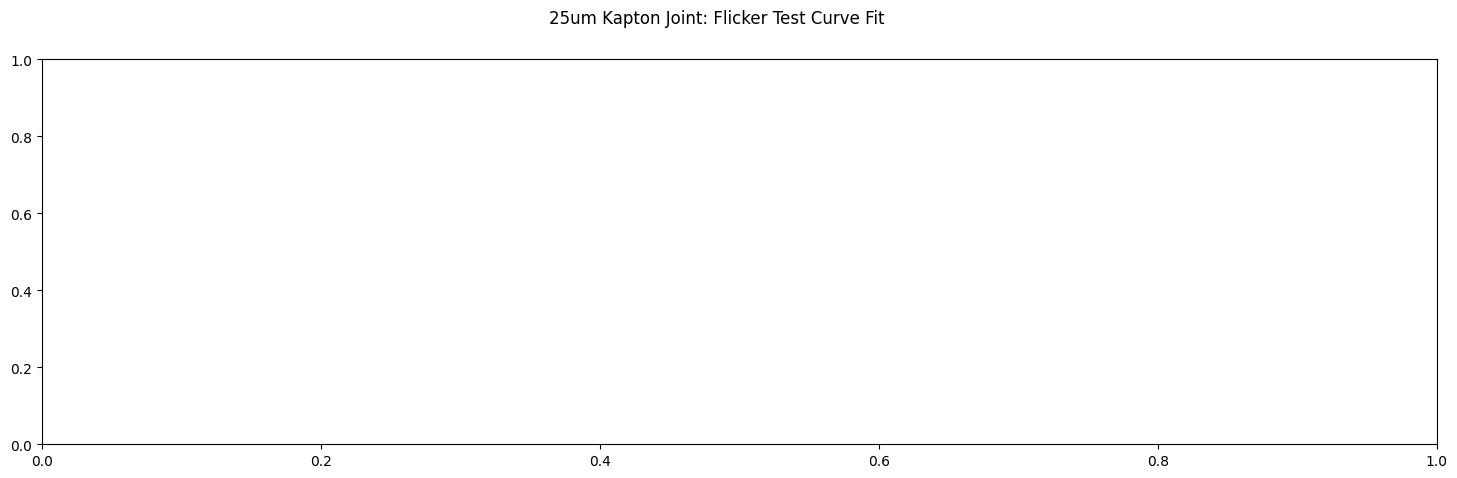

In [8]:
current_dir = os.getcwd()
filename = current_dir + r"/../Compliant Legs/Flicker Test/Flicker Test v1/skeleton_joint_25um_1000fps_at_30fps_1200frames_4800-6000.txt"
video_fps = 1000
num_frames = 600
plot_spring_flicker_test(filename, leg_name="25um Kapton Joint", video_fps=video_fps, num_frames=num_frames, p0=(10, 10, 10, 10, 100, 10))

# Flicker Test Analysis Functions

In [ ]:
def plot_spring_flicker_test(dir_path, leg_name, p0=(10, 10, 10, 10, 500, 10)):
    files = []

    # Iterate directory
    for path in os.listdir(dir_path):
        # check if current path is a file
        if os.path.isfile(os.path.join(dir_path, path)):
            if path[-3:] == "txt":
                files.append(dir_path + path)
    
    print(files)

    count = 0
    b_set = []
    k_set = []

    # Plot flicker test curve fit
    fig_ficker_fit, ax_flicker_fit = plt.subplots(1, 3, figsize=(18, 5))
    fig_ficker_fit.suptitle(f"{leg_name}: Flicker Test Curve Fit")
    for i in range(len(video_fps)):
        print(files[i])
        print(video_fps[i])
        print(num_frames[i])
        t, theta = extract_data(filename=files[count], start_row=2, video_fps=video_fps[i], num_frames=num_frames[i])

        # Normalize angle about 0deg
        theta = theta - np.mean(theta)

        # Optimize exponential decay
        exp_decay_opt, exp_decay_cov = scipy.optimize.curve_fit(underdamped_func, t, theta, p0, bounds=(0,np.inf), max_nfev=5000)
        c1, c2, tau1, tau2, w1, w2 = exp_decay_opt

        tau = np.average((tau1, tau2))
        # w = w1
        w = w1 + w2

        print(f"c1: {c1}, c2: {c2}, tau1: {tau1}, tau2: {tau2}, w1: {w1}, w2: {w2}")
        print(f"tau: {tau}, w: {w}")

        # Leg properties
        m_leg = 3e-6
        L_leg = 28e-3
        I_leg = 1/3 * m_leg * L_leg ** 2
        
        # Calculate b and k
        b = 2 * I_leg / tau
        k = I_leg * (w**2 + (1 / tau)**2)

        print(f"b: {b}, k: {k}")

        b_set.append(b)
        k_set.append(k)

        # Update drop test count
        count = count + 1

        ax_flicker_fit[i].plot(t, theta, label="Raw data")
        ax_flicker_fit[i].axhline(y=0, color='k')

        # Plot fitted data
        ax_flicker_fit[i].plot(t, underdamped_func(t, c1, c2, tau1, tau2, w1, w2), label="Curve Fit")
        ax_flicker_fit[i].plot(t, underdamped_func(t, 1, 0, np.inf, np.inf, w1, 0), linestyle="--", label="Harmonic fit")
        ax_flicker_fit[i].plot(t, underdamped_func(t, c1, c2, tau1, tau2, 0, w2), linestyle="--", label="Exponential fit")

        # Plot labels
        ax_flicker_fit[i].set_xlabel("t (s)")
        ax_flicker_fit[i].set_ylabel(r"$\theta$ ($^\circ$)")
        ax_flicker_fit[i].set_title(f"Test {count}")


    tests = ['7.5 $\mu m$', '25 $\mu m$', '50 $\mu m$']
    fig_b, ax_b = plt.subplots(figsize=(10, 5))
    ax_b.set_title(f"{leg_name}: Damping Coefficient (b)")
    ax_b.bar(tests, b_set)
    ax_b.set_ylabel(r"b ($mg \cdot mm^2 / s$)")

    fig_k, ax_k = plt.subplots(figsize=(10, 5))
    ax_k.set_title(f"{leg_name}: Spring Constant (k)")
    ax_k.bar(tests, k_set)
    ax_k.set_ylabel(r"k ($mg \cdot mm^2 / s^2$)")

    b_mean = np.mean(b_set)
    b_std = np.std(b_set)
    print(f"b_mean: {b_mean}")
    print(f"b_std: {b_std}")

    k_mean = np.mean(k_set)
    k_std = np.std(k_set)
    print(f"k_mean: {k_mean}")
    print(f"k_std: {k_std}")

    return b_mean, b_std, k_mean, k_std

In [ ]:
def plot_damped_flicker_test(dir_path, leg_name, p0=(20, 30, 10, 10, 200, 40)):
    files = []

    # Iterate directory
    for path in os.listdir(dir_path):
        # check if current path is a file
        if os.path.isfile(os.path.join(dir_path, path)):
            if path[-3:] == "txt":
                files.append(dir_path + path)
    
    print(files)

    num_cols = int(len(files) / 2)
    num_rows = int(len(files) / num_cols)

    count = 0
    b_set = []
    k_set = []

    # Plot flicker test curve fit
    fig_ficker_fit, ax_flicker_fit = plt.subplots(num_rows, num_cols, figsize=(18, 10))
    fig_ficker_fit.suptitle(f"{leg_name}: Flicker Test Curve Fit")
    for i in range(num_rows):
        for j in range(num_cols):
            print(files[i+j])
            t, theta = extract_data(filename=files[count], start_row=2, video_fps=3000, num_frames=400)

            # Normalize angle about 0deg
            theta = theta - theta[-1]

            # Apply filter to raw position data
            fs = 3000  # Sampling frequency
            fc = 40  # Cut-off frequency of the filter
            theta = filter(theta, fs, fc)

            # Optimize exponential decay
            exp_decay_opt, exp_decay_cov = scipy.optimize.curve_fit(underdamped_func, t, theta, p0, bounds=(0,np.inf), max_nfev=5000)
            c1, c2, tau1, tau2, w1, w2 = exp_decay_opt

            tau = np.average((tau1, tau2))
            # w = w1
            w = w1 + w2

            print(f"c1: {c1}, c2: {c2}, tau1: {tau1}, tau2: {tau2}, w1: {w1}, w2: {w2}")
            print(f"tau: {tau}, w: {w}")

            # Leg properties
            m_leg = 3e-6
            L_leg = 28e-3
            I_leg = 1/3 * m_leg * L_leg ** 2
            
            # Calculate b and k
            b = 2 * I_leg / tau
            k = I_leg * (w**2 + (1 / tau)**2)

            print(f"b: {b}, k: {k}")

            b_set.append(b)
            k_set.append(k)

            # Update drop test count
            count = count + 1

            ax_flicker_fit[i,j].plot(t, theta, label="Raw data")
            ax_flicker_fit[i,j].axhline(y=0, color='k')

            # Plot fitted data
            ax_flicker_fit[i,j].plot(t, underdamped_func(t, c1, c2, tau1, tau2, w1, w2), label="Curve Fit")
            ax_flicker_fit[i,j].plot(t, underdamped_func(t, 1, 0, np.inf, np.inf, w1, 0), linestyle="--", label="Harmonic fit")
            ax_flicker_fit[i,j].plot(t, underdamped_func(t, c1, c2, tau1, tau2, 0, w2), linestyle="--", label="Exponential fit")

            # Plot labels
            ax_flicker_fit[i,j].set_xlabel("t (s)")
            ax_flicker_fit[i,j].set_ylabel(r"$\theta$ ($^\circ$)")
            ax_flicker_fit[i,j].set_title(f"Test {count}")


    tests = ['Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5', 'Test 6']
    fig_b, ax_b = plt.subplots(figsize=(10, 5))
    ax_b.set_title(f"{leg_name}: Damping Coefficient (b)")
    ax_b.bar(tests, b_set)
    ax_b.set_ylabel(r"b ($mg \cdot mm^2 / s$)")

    fig_k, ax_k = plt.subplots(figsize=(10, 5))
    ax_k.set_title(f"{leg_name}: Spring Constant (k)")
    ax_k.bar(tests, k_set)
    ax_k.set_ylabel(r"k ($mg \cdot mm^2 / s^2$)")

    b_mean = np.mean(b_set)
    b_std = np.std(b_set)
    print(f"b_mean: {b_mean}")
    print(f"b_std: {b_std}")

    k_mean = np.mean(k_set)
    k_std = np.std(k_set)
    print(f"k_mean: {k_mean}")
    print(f"k_std: {k_std}")

    return b_mean, b_std, k_mean, k_std

In [ ]:
current_dir = os.getcwd()
dir_path = current_dir + r"/../Compliant Legs/Flicker Test/Flicker Test v1/"
plot_spring_flicker_test(dir_path, leg_name="25um Kapton Joint")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Flicker Test/Flicker Test v1/25um Kapton Joint/'

['/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Flicker Test/Flicker Test v3/Buckle Joint/buckle_test6_3000fps_400frames.txt', '/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Flicker Test/Flicker Test v3/Buckle Joint/buckle_test4_3000fps_400frames.txt', '/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Flicker Test/Flicker Test v3/Buckle Joint/buckle_test2_3000fps_400frames.txt', '/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Flicker Test/Flicker Test v3/Buckle Joint/buckle_test5_3000fps_400frames.txt', '/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Flicker Test/Flicker Test v3/Buckle Joint/buckle_test3_3000fps_400frames.txt', '/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Flicker Test/Fli

(1.7268160807264654e-07,
 1.0846985200883417e-08,
 5.7904324497222394e-05,
 7.0980114226318245e-06)

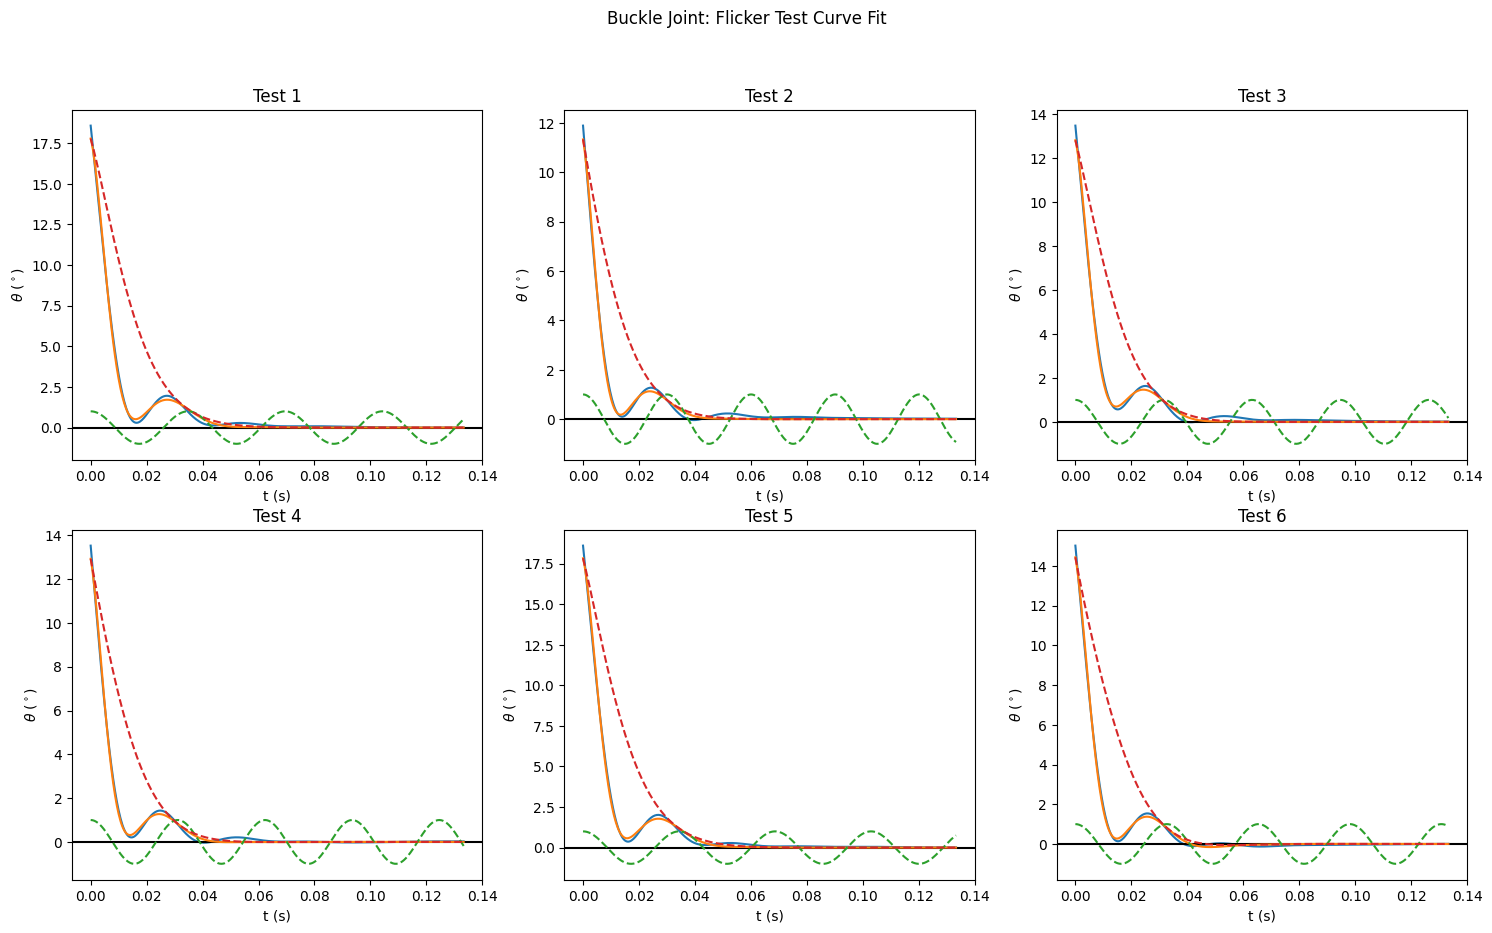

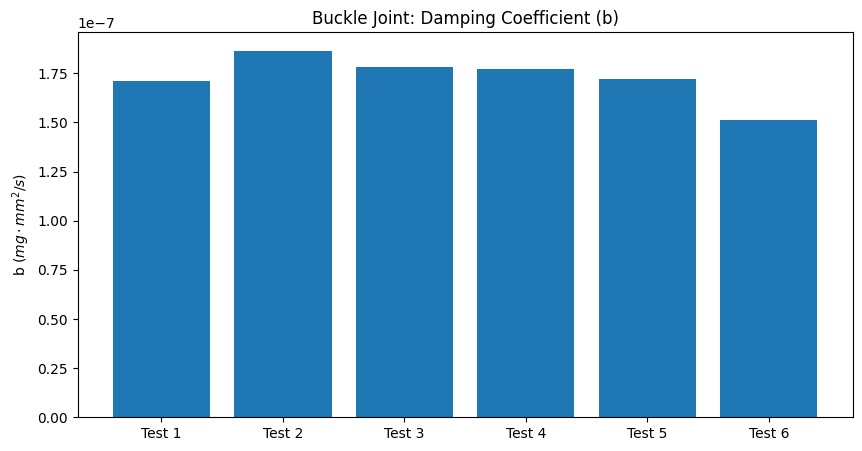

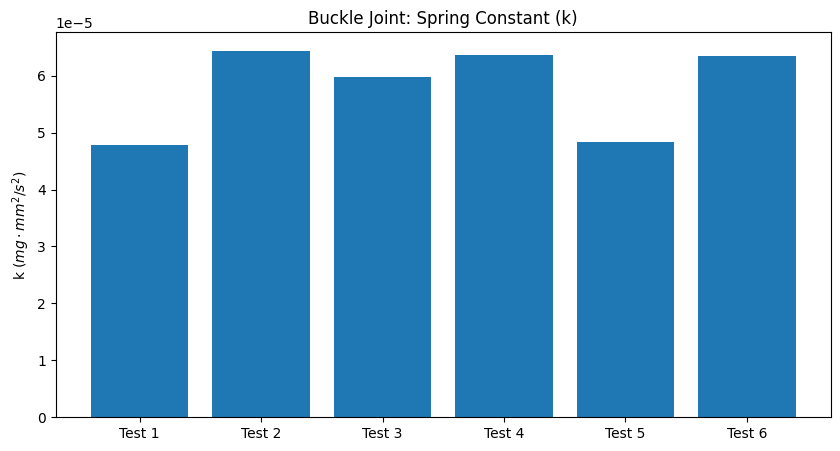

In [ ]:
current_dir = os.getcwd()
dir_path = current_dir + r"/../Compliant Legs/Flicker Test/Flicker Test v3/Buckle Joint/"
plot_damped_flicker_test(dir_path, leg_name="Buckle Joint")

['/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Flicker Test/Flicker Test v3/7.5um Kapton-TPE Joint/7-5um_test2_3000fps_400frames.txt', '/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Flicker Test/Flicker Test v3/7.5um Kapton-TPE Joint/7-5um_test6_3000fps_400frames.txt', '/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Flicker Test/Flicker Test v3/7.5um Kapton-TPE Joint/7-5um_test4_3000fps_400frames.txt', '/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Flicker Test/Flicker Test v3/7.5um Kapton-TPE Joint/7-5um_test3_3000fps_400frames.txt', '/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Flicker Test/Flicker Test v3/7.5um Kapton-TPE Joint/7-5um_test1_3000fps_400frames.txt', '/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter

(1.7901212368872676e-07,
 3.1266860175710054e-09,
 5.1945205718378576e-05,
 1.0198183335728094e-05)

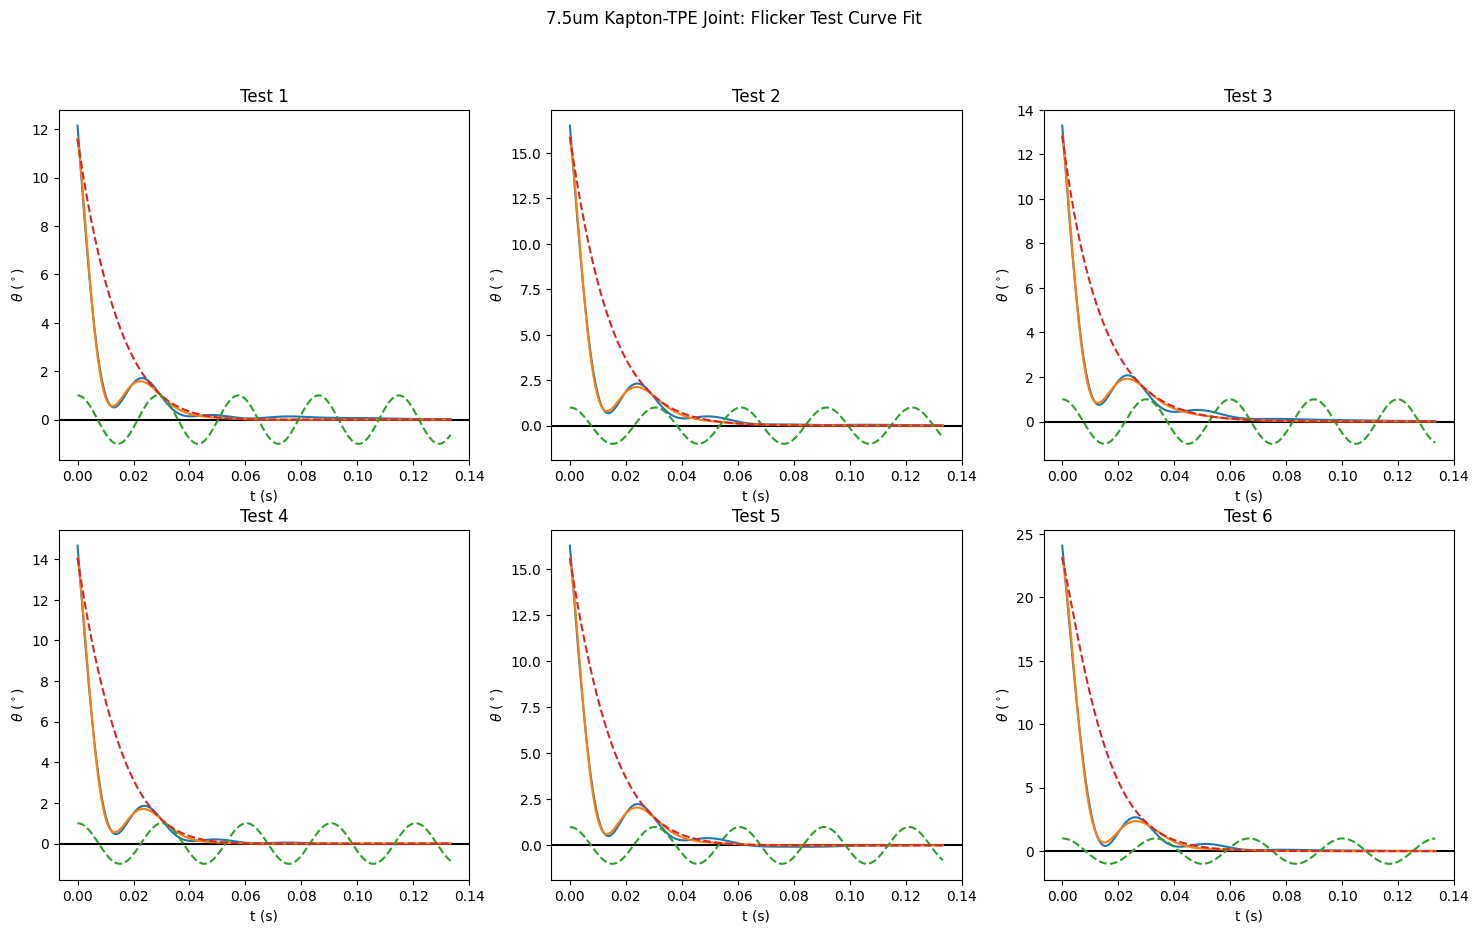

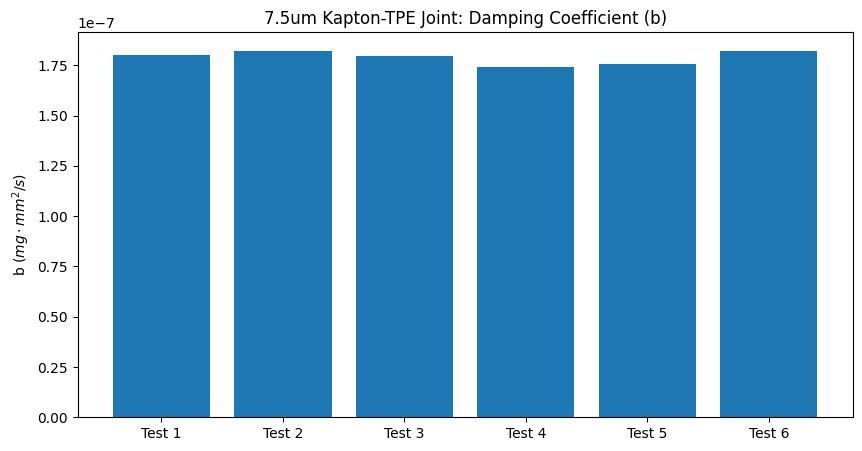

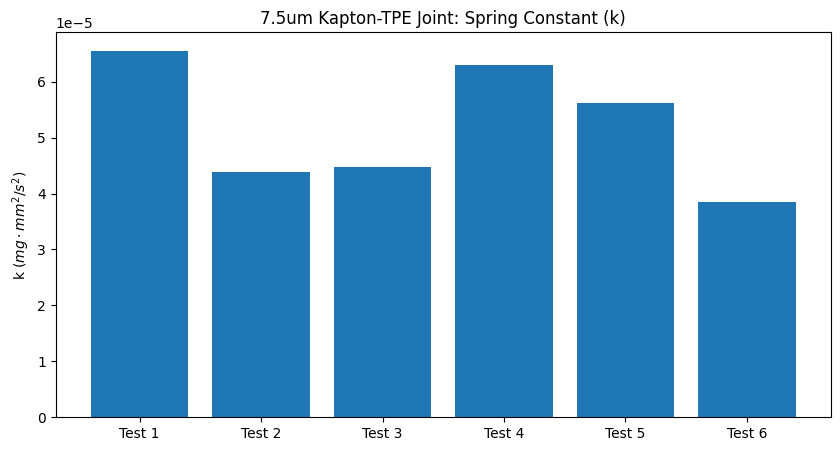

In [ ]:
current_dir = os.getcwd()
dir_path = current_dir + r"/../Compliant Legs/Flicker Test/Flicker Test v3/7.5um Kapton-TPE Joint/"
plot_damped_flicker_test(dir_path, leg_name="7.5um Kapton-TPE Joint")

['/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Flicker Test/Flicker Test v3/25um Kapton-TPE Joint/25um_test1_3000fps_400frames.txt', '/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Flicker Test/Flicker Test v3/25um Kapton-TPE Joint/25um_test3_3000fps_400frames.txt', '/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Flicker Test/Flicker Test v3/25um Kapton-TPE Joint/25um_test5_3000fps_400frames.txt', '/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Flicker Test/Flicker Test v3/25um Kapton-TPE Joint/25um_test2_3000fps_400frames.txt', '/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Flicker Test/Flicker Test v3/25um Kapton-TPE Joint/25um_test4_3000fps_400frames.txt', '/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks

(1.7769173787062898e-07,
 1.0131394685012702e-08,
 6.48962277862755e-05,
 8.590204332204721e-06)

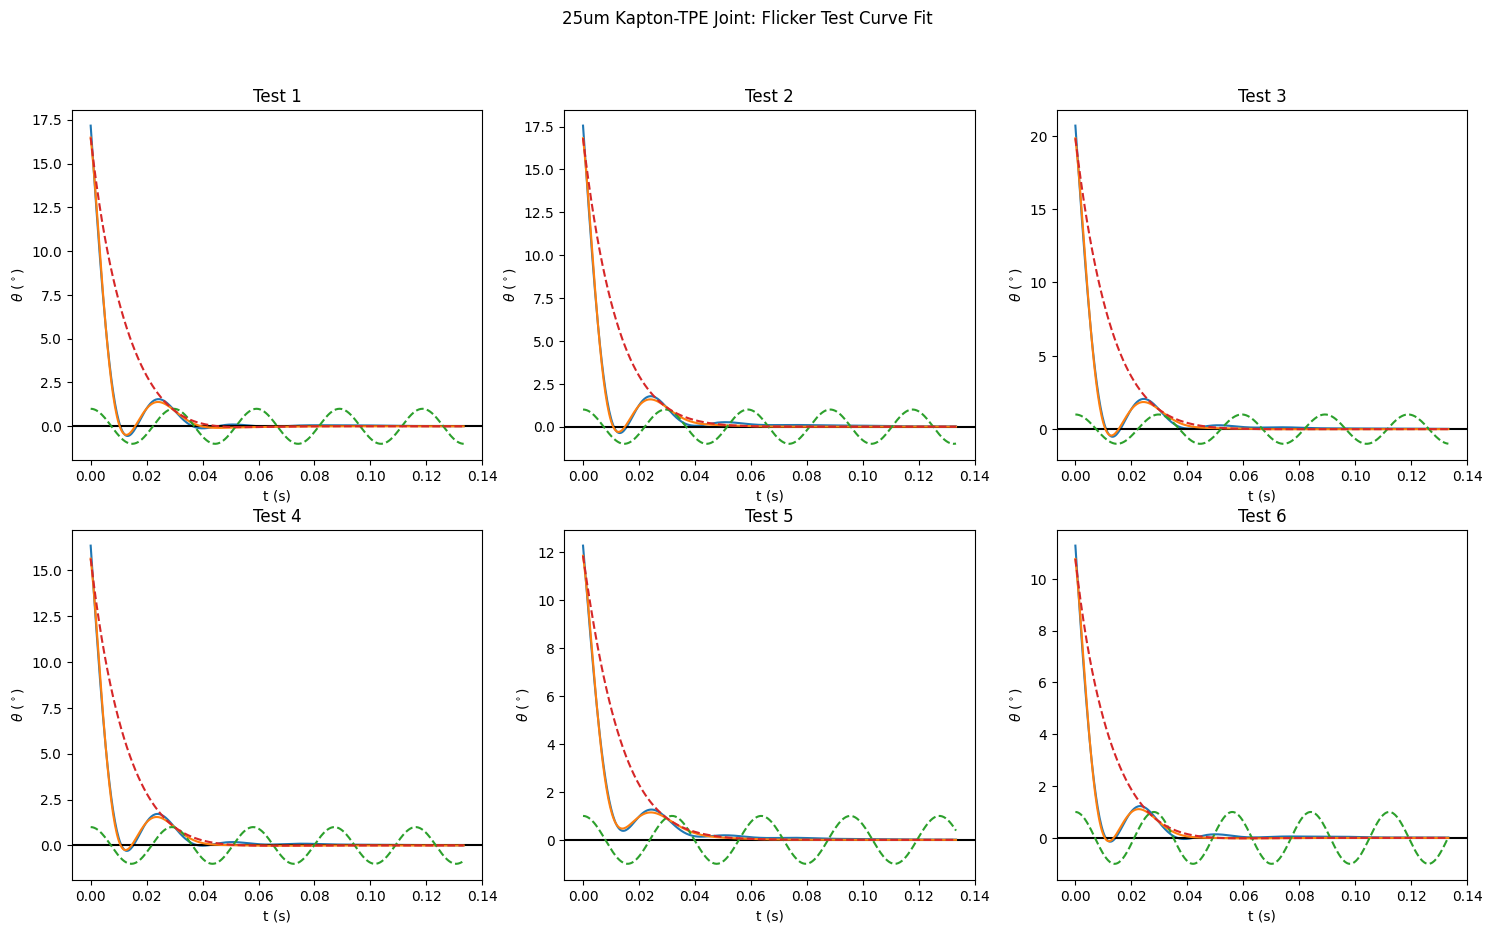

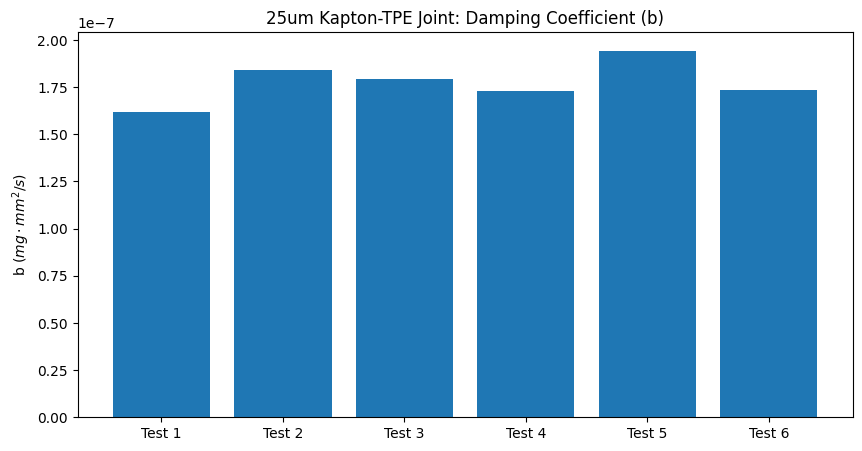

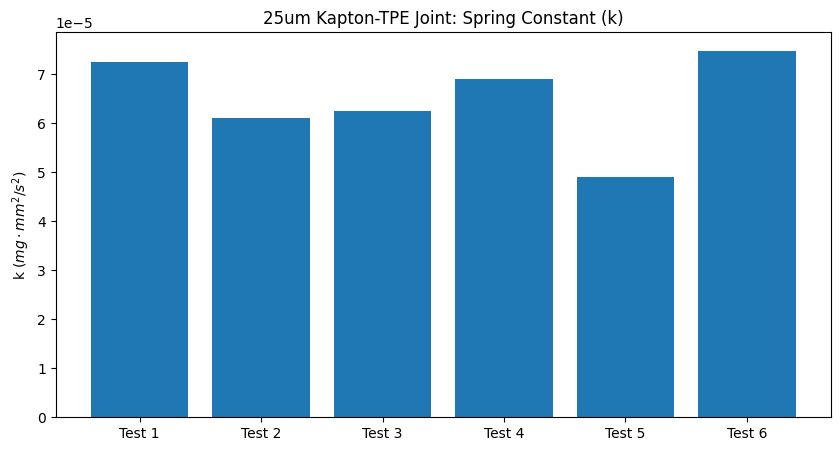

In [ ]:
current_dir = os.getcwd()
dir_path = current_dir + r"/../Compliant Legs/Flicker Test/Flicker Test v3/25um Kapton-TPE Joint/"
plot_damped_flicker_test(dir_path, leg_name="25um Kapton-TPE Joint")

['/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Flicker Test/Flicker Test v3/50um Kapton-TPE Joint/50um_test4_3000fps_400frames.txt', '/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Flicker Test/Flicker Test v3/50um Kapton-TPE Joint/50um_test6_3000fps_400frames.txt', '/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Flicker Test/Flicker Test v3/50um Kapton-TPE Joint/50um_test2_3000fps_400frames.txt', '/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Flicker Test/Flicker Test v3/50um Kapton-TPE Joint/50um_test5_3000fps_400frames.txt', '/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Flicker Test/Flicker Test v3/50um Kapton-TPE Joint/50um_test1_3000fps_400frames.txt', '/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks

(1.696429900867251e-07,
 5.085609106978847e-09,
 7.335056158519265e-05,
 3.4206942716069827e-06)

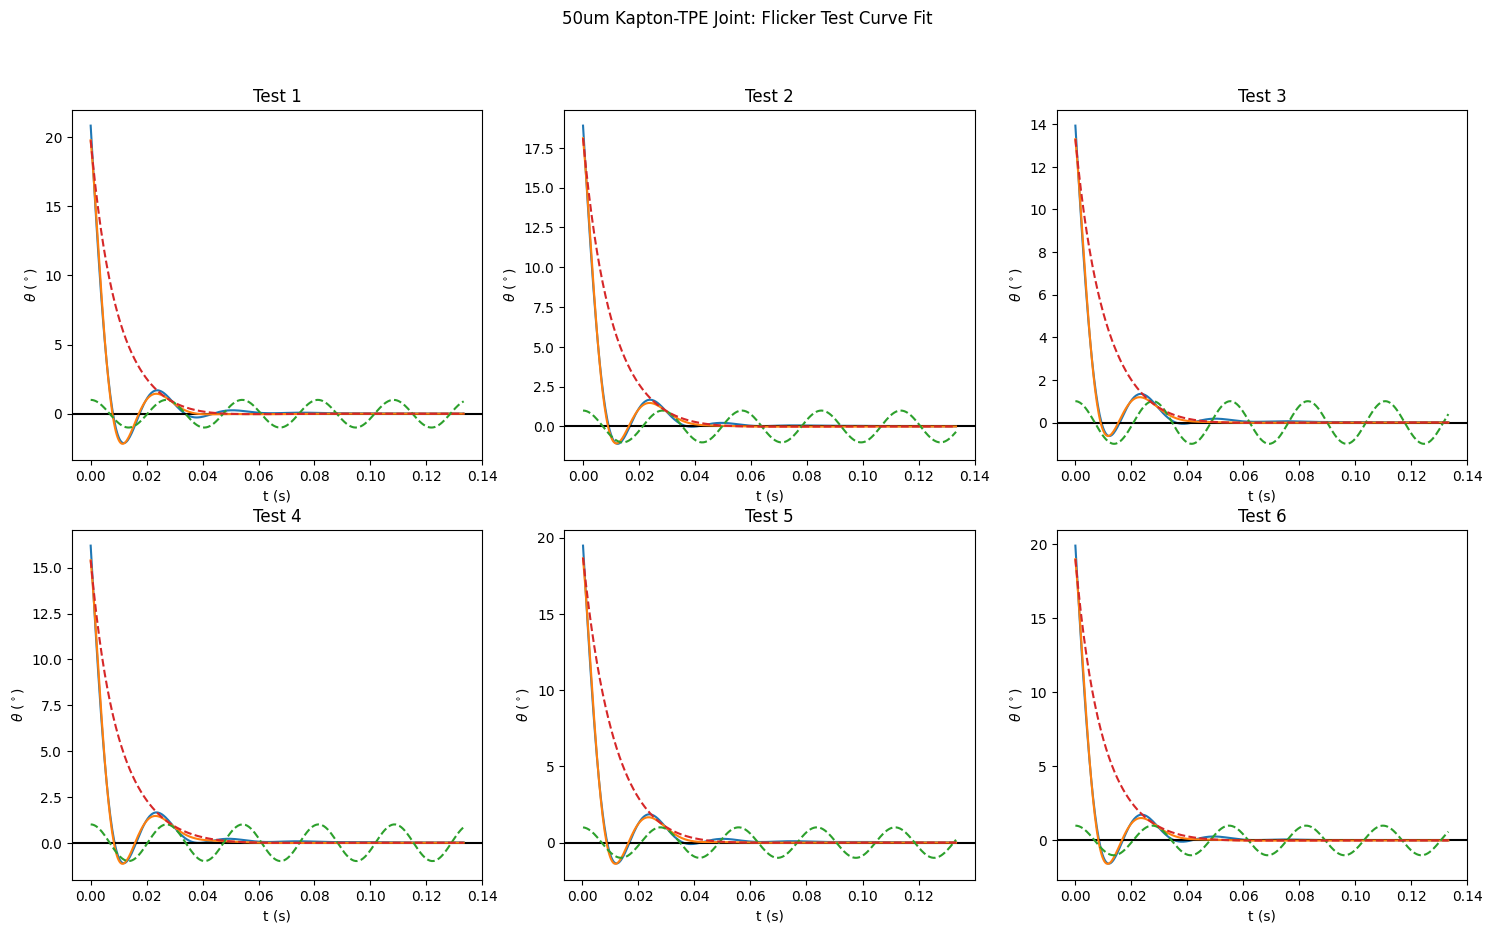

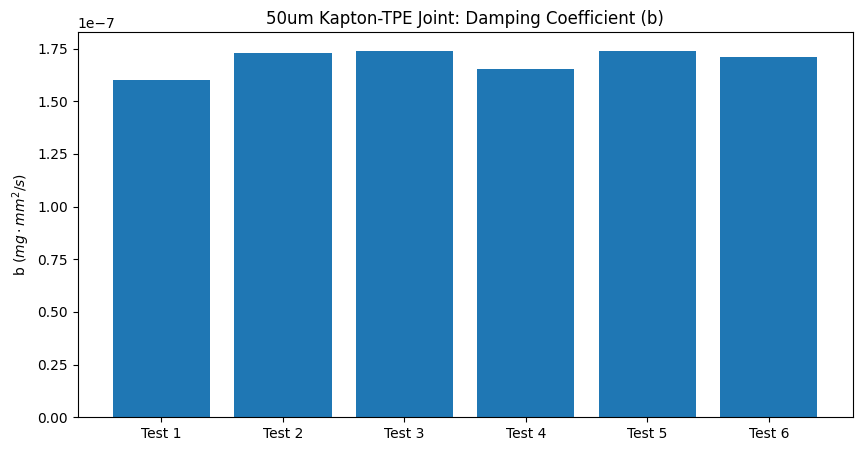

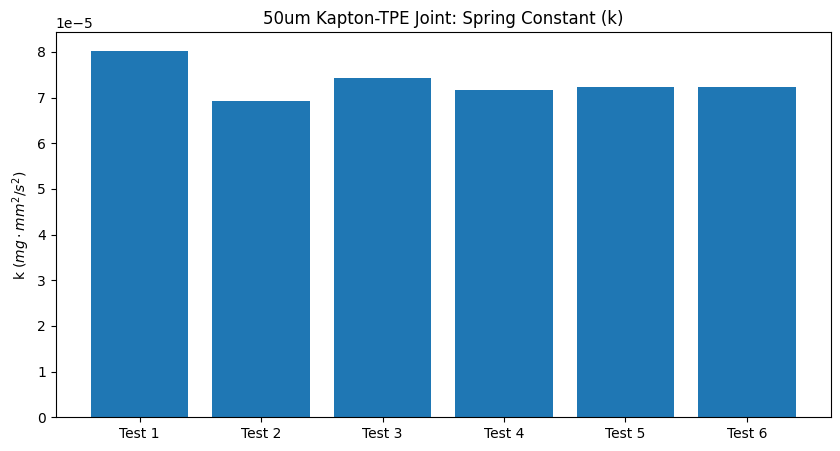

In [ ]:
current_dir = os.getcwd()
dir_path = current_dir + r"/../Compliant Legs/Flicker Test/Flicker Test v3/50um Kapton-TPE Joint/"
plot_damped_flicker_test(dir_path, leg_name="50um Kapton-TPE Joint")

# Drop Test Analysis (Testing)

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Legacy Leg/legacy_test3_3000fps_400frames_fail.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Legacy Leg/legacy_test4_3000fps_400frames_fail.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Legacy Leg/legacy_test5_3000fps_400frames_fail.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Legacy Leg/legacy_test4_3000fps_400frames_fail.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Legacy Leg/legacy_test5_3000fps_400frames_fail.txt
/Users/chr

Text(0, 0.5, 'dx (mm)')

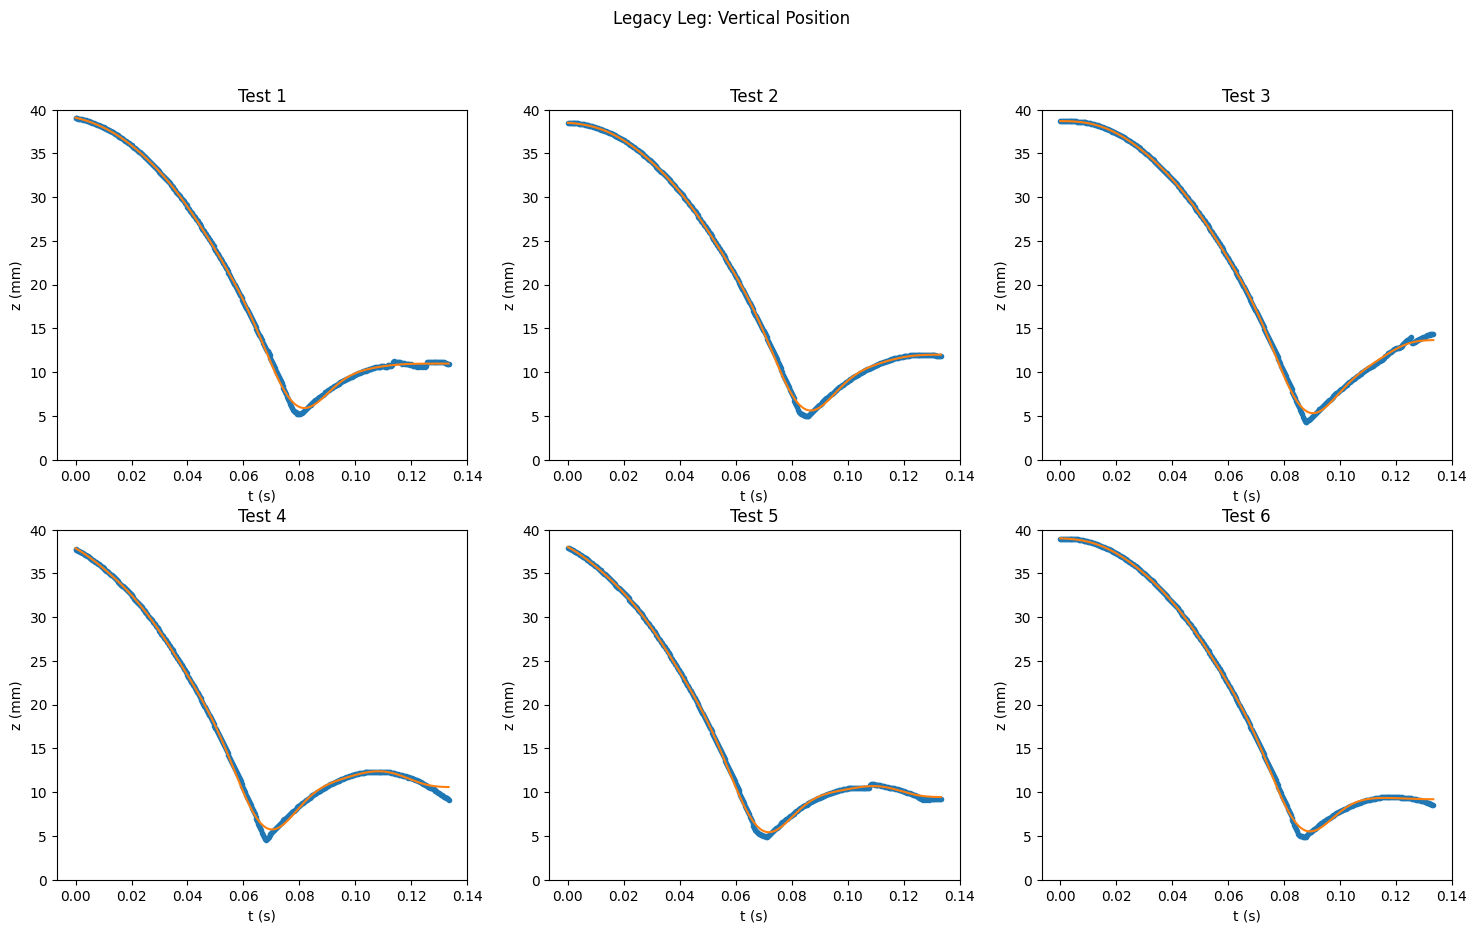

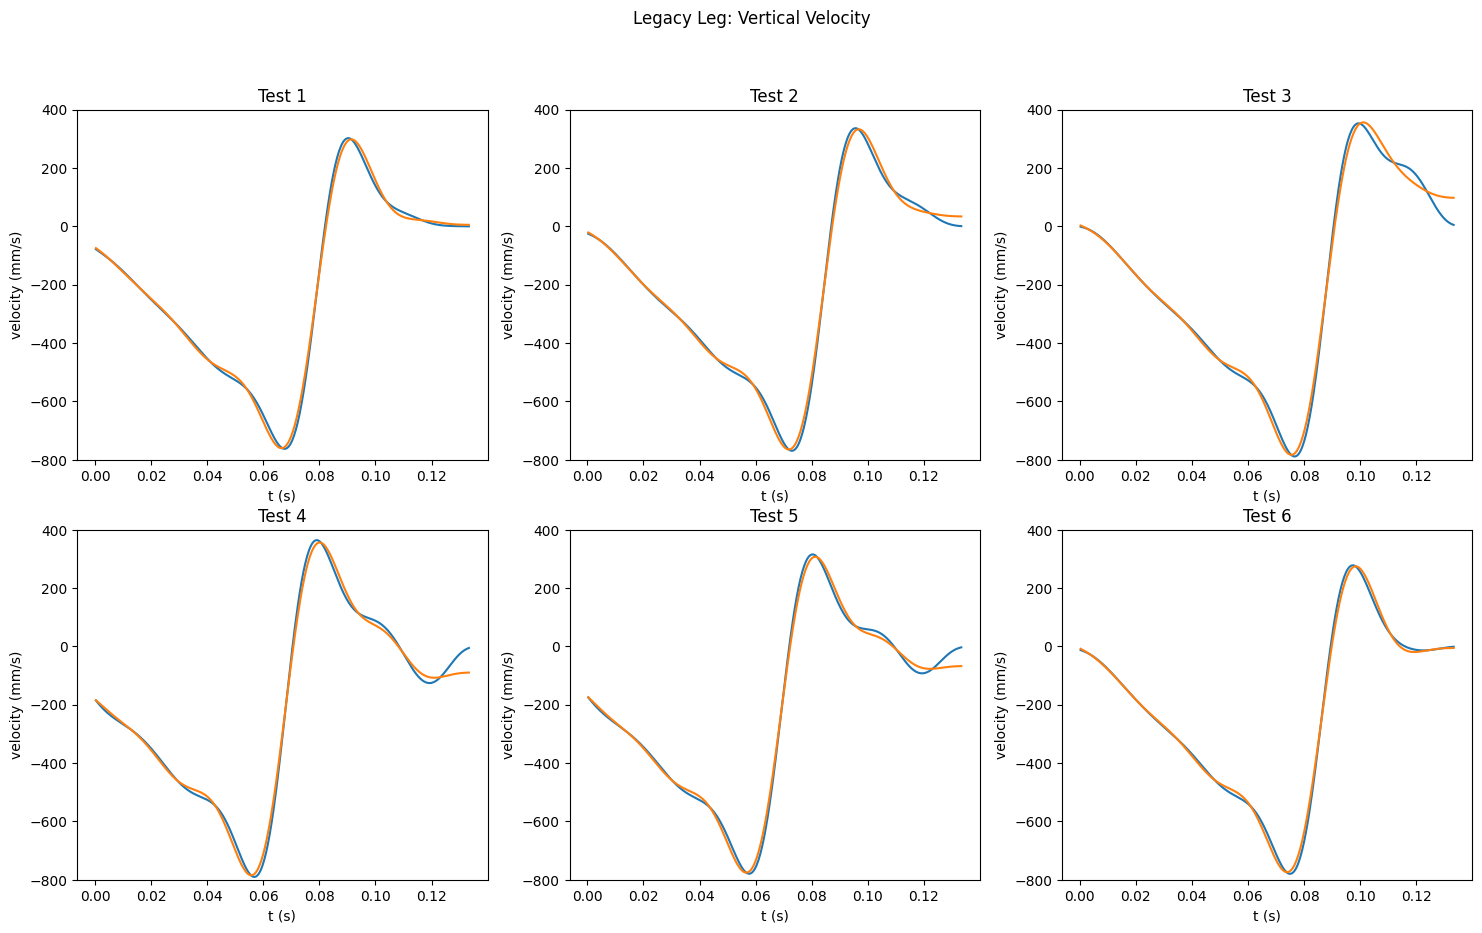

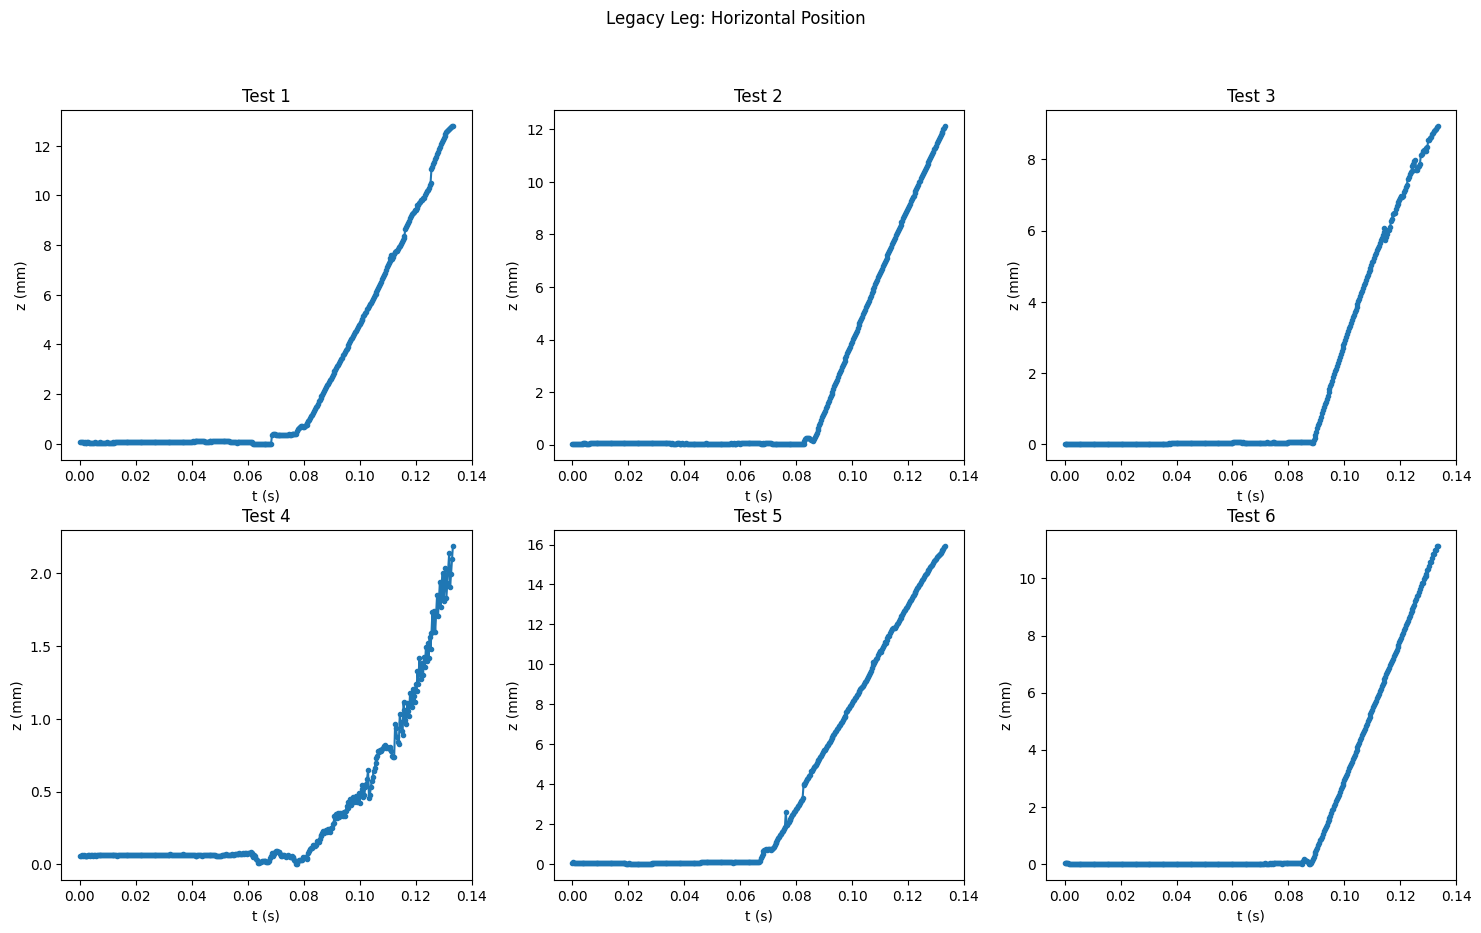

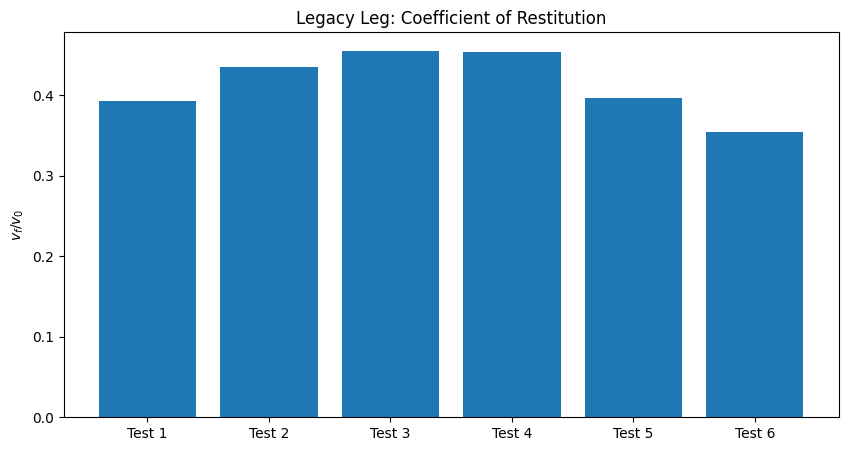

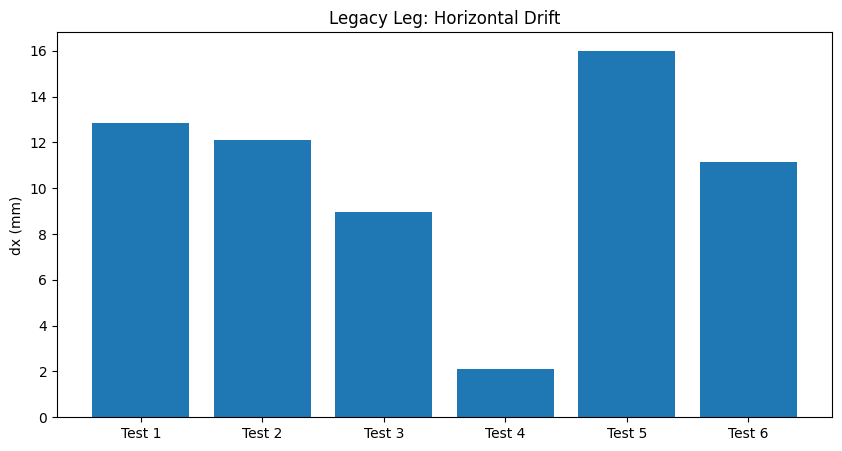

In [ ]:
current_dir = os.getcwd()
dir_path = current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Legacy Leg/"
files = []

# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        if path[-3:] == "txt":
            files.append(dir_path + path)

num_cols = int(len(files) / 2)
num_rows = int(len(files) / num_cols)

count = 0
cor = []
x_drift = []

# Plot vertical position and velocity
fig_z, ax_z = plt.subplots(num_rows, num_cols, figsize=(18, 10))
fig_zdot, ax_zdot = plt.subplots(num_rows, num_cols, figsize=(18, 10))
fig_x, ax_x = plt.subplots(num_rows, num_cols, figsize=(18, 10))
fig_z.suptitle("Legacy Leg: Vertical Position")
fig_zdot.suptitle("Legacy Leg: Vertical Velocity")
fig_x.suptitle("Legacy Leg: Horizontal Position")
for i in range(num_rows):
    for j in range(num_cols):
        print(files[i+j])
        t, x, z = extract_data(filename=files[count], start_row=2, video_fps=3000, num_frames=400)

        # Offset initial drop height
        z0 = 40
        z = z + z0
        
        # Apply filter to raw position data
        fs = 3000  # Sampling frequency
        fc = 40  # Cut-off frequency of the filter
        z_filter = filter(z, fs, fc)
        
        # Compute velocity and filter
        tdot, zdot = finite_forward_difference(t, z_filter)
        zdot_filter = filter(zdot, fs, fc)

        # Update drop test count
        count = count + 1
        
        # Plot vertical position
        ax_z[i,j].plot(t, z, marker='.', color="tab:blue", label="Raw Position")
        ax_z[i,j].plot(t, z_filter, color="tab:orange", label="Filtered Position")
        ax_z[i,j].set_title(f"Test {count}")
        ax_z[i,j].set_xlabel("t (s)")
        ax_z[i,j].set_ylabel("z (mm)")
        ax_z[i,j].set_ylim(0, z0)

        # Plot vertical velocity
        ax_zdot[i,j].plot(tdot, zdot, color="tab:blue", label="Forward-Difference Velocity")
        ax_zdot[i,j].plot(tdot, zdot_filter, color="tab:orange", label="Filtered Velocity")
        ax_zdot[i,j].set_title(f"Test {count}")
        ax_zdot[i,j].set_ylabel("velocity (mm/s)")
        ax_zdot[i,j].set_xlabel("t (s)")
        ax_zdot[i,j].set_ylim(-800, 400)

        # Plot horizontal position
        ax_x[i,j].plot(t, np.abs(x), marker='.', color="tab:blue", label="Raw Position")
        ax_x[i,j].set_title(f"Test {count}")
        ax_x[i,j].set_xlabel("t (s)")
        ax_x[i,j].set_ylabel("z (mm)")

        v = zdot_filter
        cor.append(coefficient_of_restitution(v))

        dx = np.abs(x[-1] - x[0])
        x_drift.append(dx)


tests = ['Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5', 'Test 6']
fig_cor, ax_cor = plt.subplots(figsize=(10, 5))
ax_cor.set_title("Legacy Leg: Coefficient of Restitution")
ax_cor.bar(tests, cor)
ax_cor.set_ylabel(r"$v_f / v_0$")

fig_drift, ax_drift = plt.subplots(figsize=(10, 5))
ax_drift.set_title("Legacy Leg: Horizontal Drift")
ax_drift.bar(tests, x_drift)
ax_drift.set_ylabel("dx (mm)")

# Drop Test Analysis Function

In [ ]:
def plot_drop_test(dir_path, leg_name):
    files = []

    # Iterate directory
    for path in os.listdir(dir_path):
        # check if current path is a file
        if os.path.isfile(os.path.join(dir_path, path)):
            if path[-3:] == "txt":
                files.append(dir_path + path)

    num_cols = int(len(files) / 2)
    num_rows = int(len(files) / num_cols)

    count = 0
    cor = []
    x_drift = []

    # Plot vertical position and velocity
    fig_z, ax_z = plt.subplots(num_rows, num_cols, figsize=(18, 10))
    fig_zdot, ax_zdot = plt.subplots(num_rows, num_cols, figsize=(18, 10))
    fig_x, ax_x = plt.subplots(num_rows, num_cols, figsize=(18, 10))
    fig_z.suptitle(f"{leg_name}: Vertical Position")
    fig_zdot.suptitle(f"{leg_name}: Vertical Velocity")
    fig_x.suptitle(f"{leg_name}: Horizontal Position")
    for i in range(num_rows):
        for j in range(num_cols):
            print(files[i+j])
            t, x, z = extract_data(filename=files[count], start_row=2, video_fps=3000, num_frames=400)

            # Offset initial drop height
            z0 = 40
            z = z + z0
            
            # Apply filter to raw position data
            fs = 3000  # Sampling frequency
            fc = 40  # Cut-off frequency of the filter
            z_filter = filter(z, fs, fc)
            
            # Compute velocity and filter
            tdot, zdot = finite_forward_difference(t, z_filter)
            zdot_filter = filter(zdot, fs, fc)

            # Update drop test count
            count = count + 1
            
            # Plot vertical position
            ax_z[i,j].plot(t, z, marker='.', color="tab:blue", label="Raw Position")
            ax_z[i,j].plot(t, z_filter, color="tab:orange", label="Filtered Position")
            ax_z[i,j].set_title(f"Test {count}")
            ax_z[i,j].set_xlabel("t (s)")
            ax_z[i,j].set_ylabel("z (mm)")
            ax_z[i,j].set_ylim(0, z0)

            # Plot vertical velocity
            ax_zdot[i,j].plot(tdot, zdot, color="tab:blue", label="Forward-Difference Velocity")
            ax_zdot[i,j].plot(tdot, zdot_filter, color="tab:orange", label="Filtered Velocity")
            ax_zdot[i,j].set_title(f"Test {count}")
            ax_zdot[i,j].set_ylabel("velocity (mm/s)")
            ax_zdot[i,j].set_xlabel("t (s)")
            ax_zdot[i,j].set_ylim(-800, 400)

            # Plot horizontal position
            ax_x[i,j].plot(t, x, marker='.', color="tab:blue", label="Raw Position")
            ax_x[i,j].set_title(f"Test {count}")
            ax_x[i,j].set_xlabel("t (s)")
            ax_x[i,j].set_ylabel("z (mm)")

            v = zdot_filter
            cor.append(coefficient_of_restitution(v))

            dx = np.abs(x[-1] - x[0])
            x_drift.append(dx)


    tests = ['Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5', 'Test 6']
    fig_cor, ax_cor = plt.subplots(figsize=(10, 5))
    ax_cor.set_title(f"{leg_name}: Coefficient of Restitution")
    ax_cor.bar(tests, cor)
    ax_cor.set_ylabel(r"$v_f / v_0$")

    fig_drift, ax_drift = plt.subplots(figsize=(10, 5))
    ax_drift.set_title(f"{leg_name}: Horizontal Drift")
    ax_drift.bar(tests, x_drift)
    ax_drift.set_ylabel("dx (mm)")

    cor_mean = np.mean(cor)
    cor_std = np.std(cor)
    print(f"cor_mean: {cor_mean}")
    print(f"cor_std: {cor_std}")

    x_drift_mean = np.mean(x_drift)
    x_drift_std = np.std(x_drift)
    print(f"x_drift_mean: {x_drift_mean}")
    print(f"x_drift_std: {x_drift_std}")

    return cor_mean, cor_std, x_drift_mean, x_drift_std

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Legacy Leg/legacy_test3_3000fps_400frames_fail.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Legacy Leg/legacy_test4_3000fps_400frames_fail.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Legacy Leg/legacy_test5_3000fps_400frames_fail.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Legacy Leg/legacy_test4_3000fps_400frames_fail.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Legacy Leg/legacy_test5_3000fps_400frames_fail.txt
/Users/chr

(0.41458507745365974,
 0.03660794692780231,
 10.540607868333334,
 4.310021522223375)

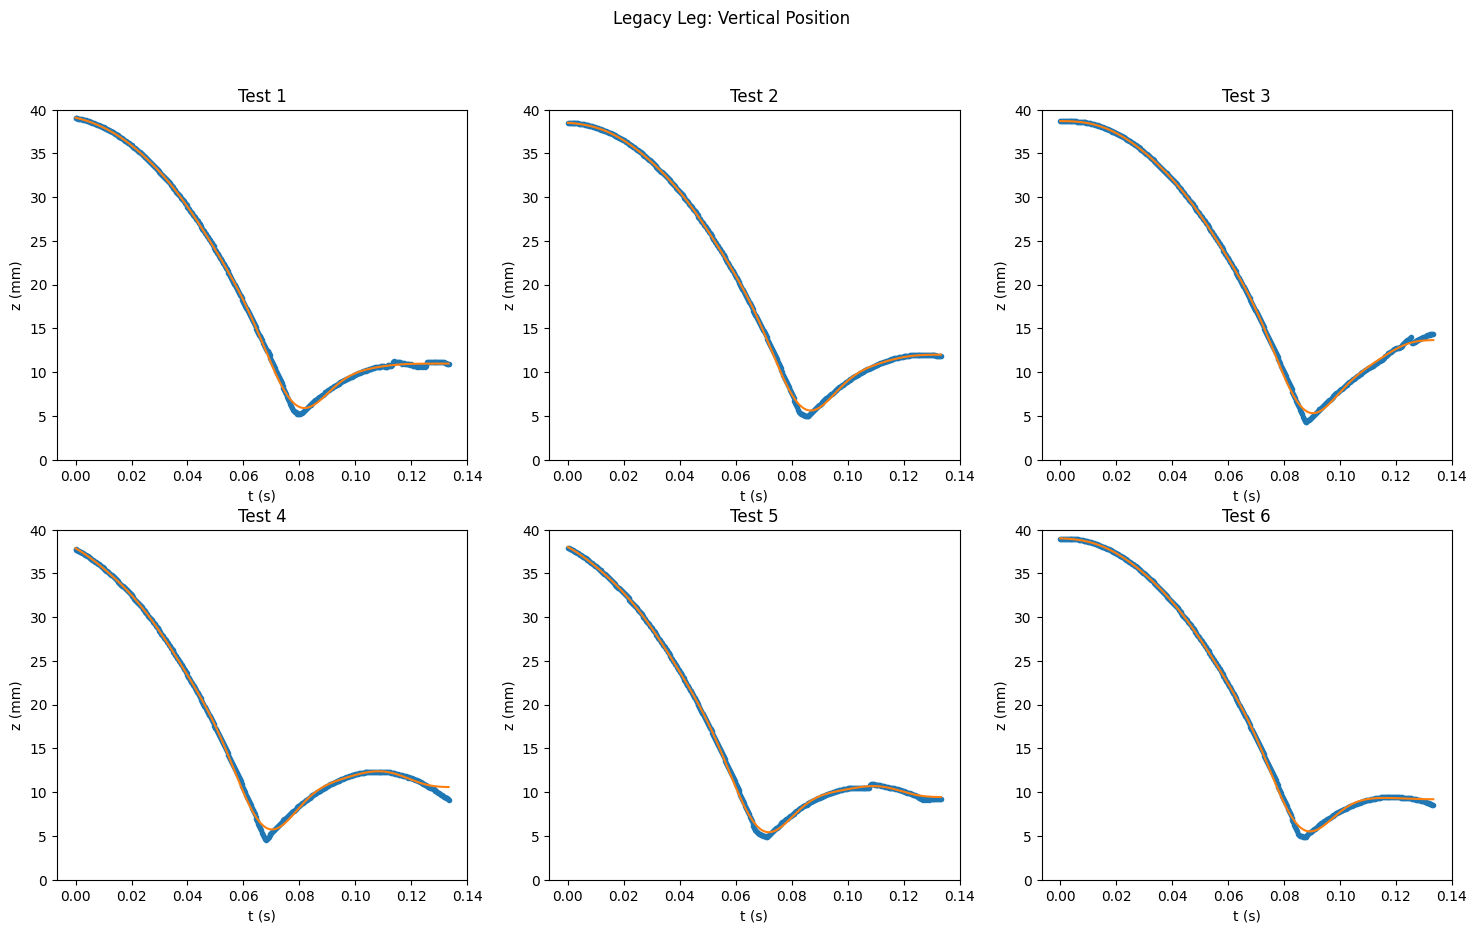

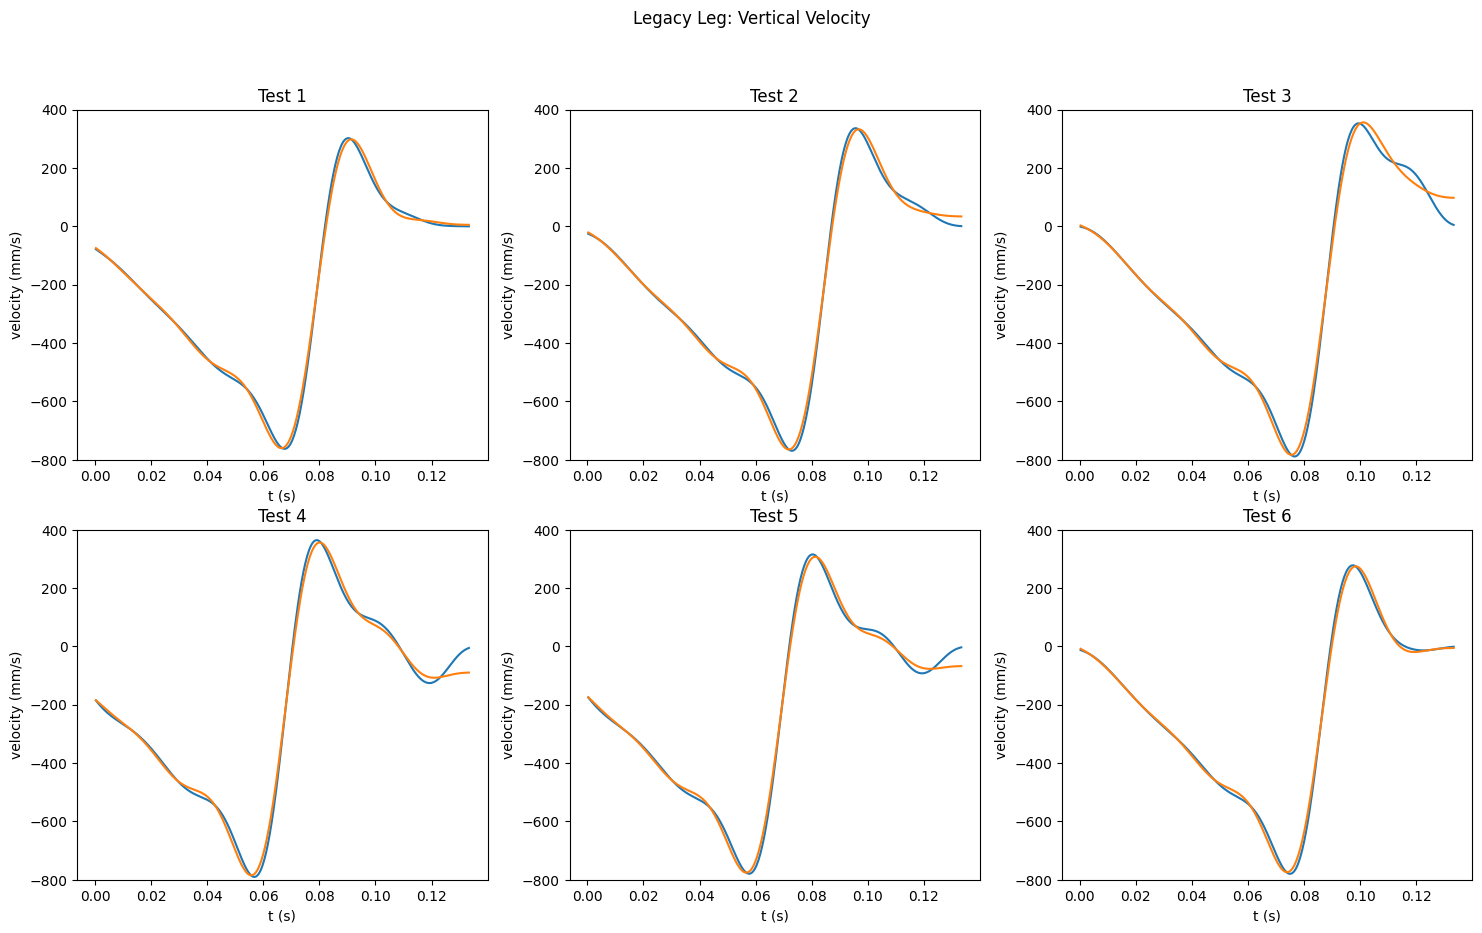

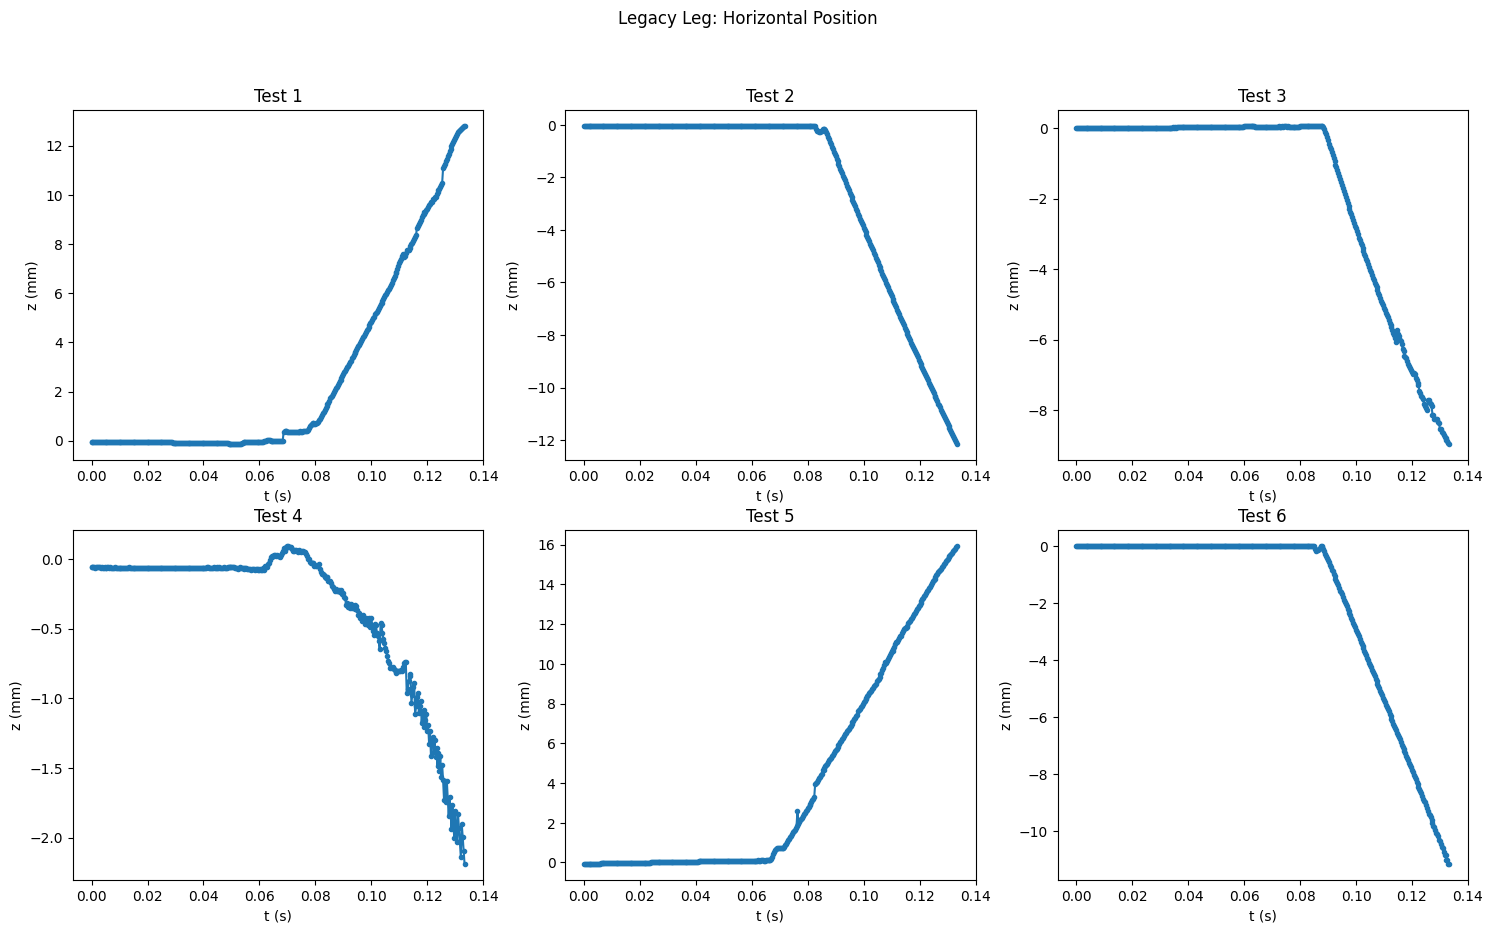

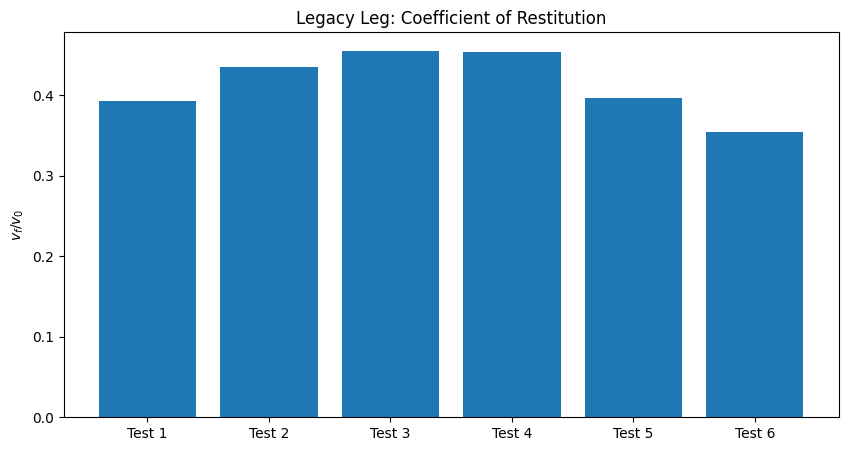

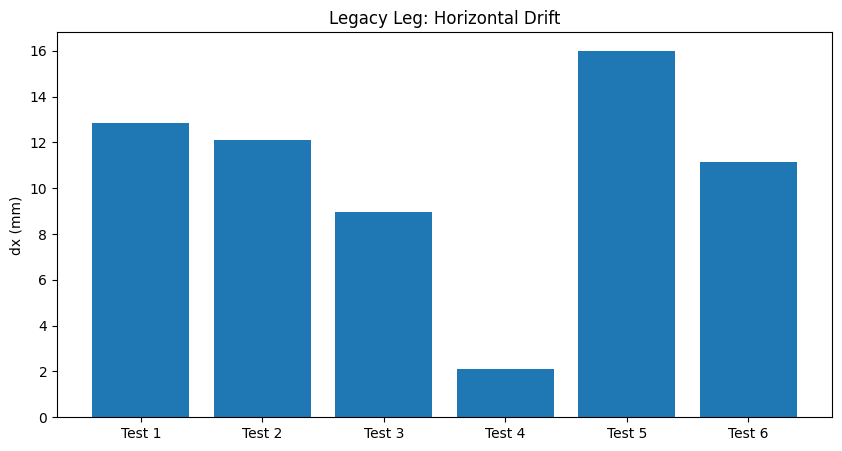

In [ ]:
current_dir = os.getcwd()
dir_path = current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Legacy Leg/"
plot_drop_test(dir_path, leg_name="Legacy Leg")

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Rigid Leg/30deg Stance/rigid_30deg_test1_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Rigid Leg/30deg Stance/rigid_30deg_test6_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Rigid Leg/30deg Stance/rigid_30deg_test4_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Rigid Leg/30deg Stance/rigid_30deg_test6_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coeffici

(0.22039384620031513,
 0.03312815298970028,
 4.327845468166667,
 1.8912119444036954)

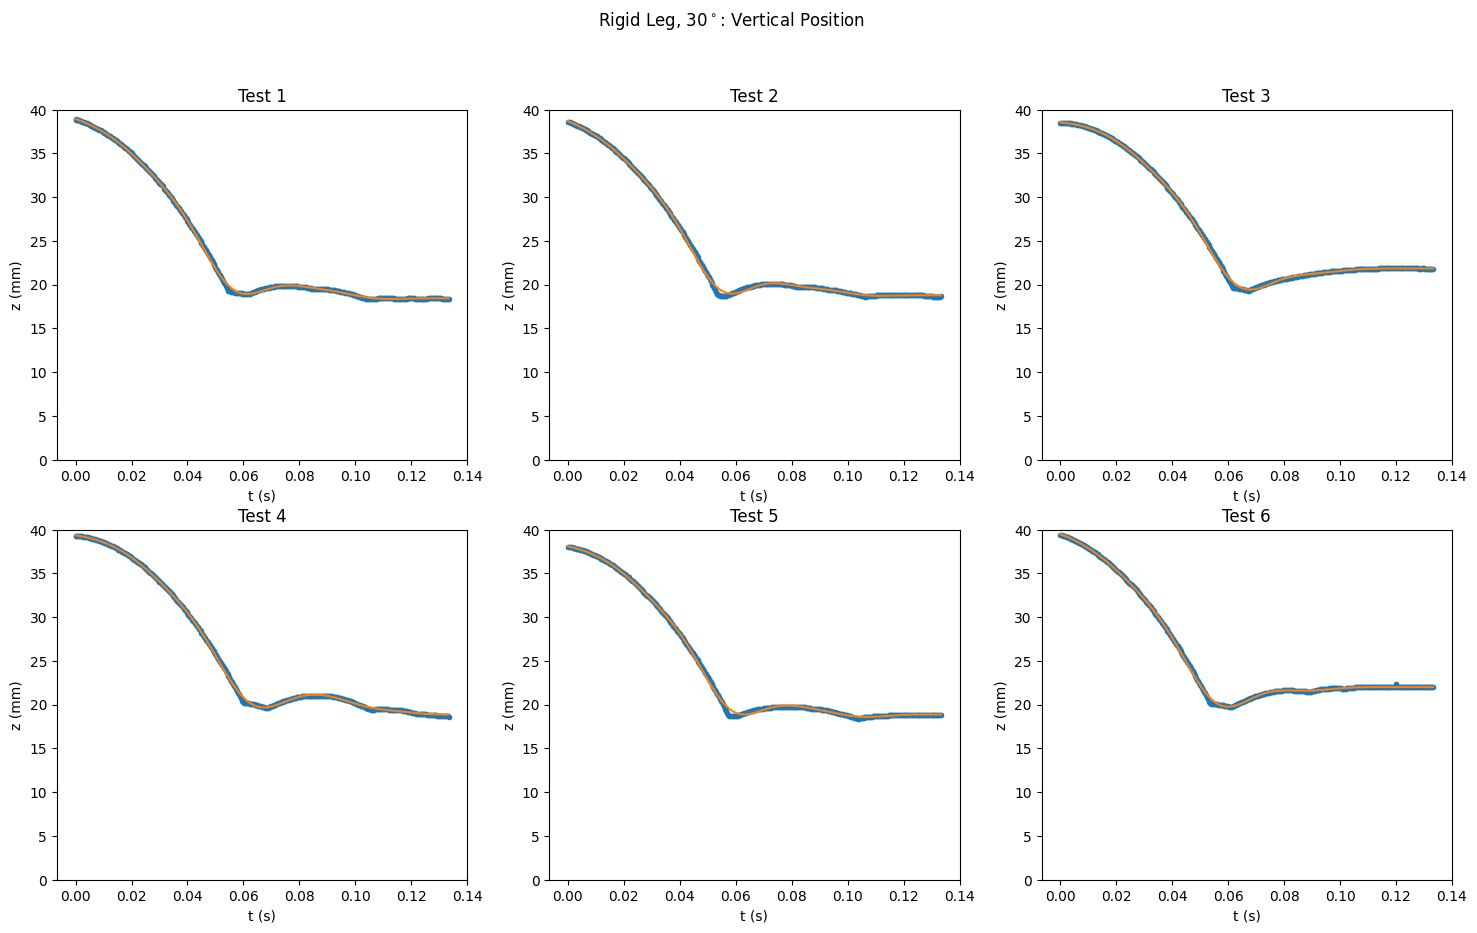

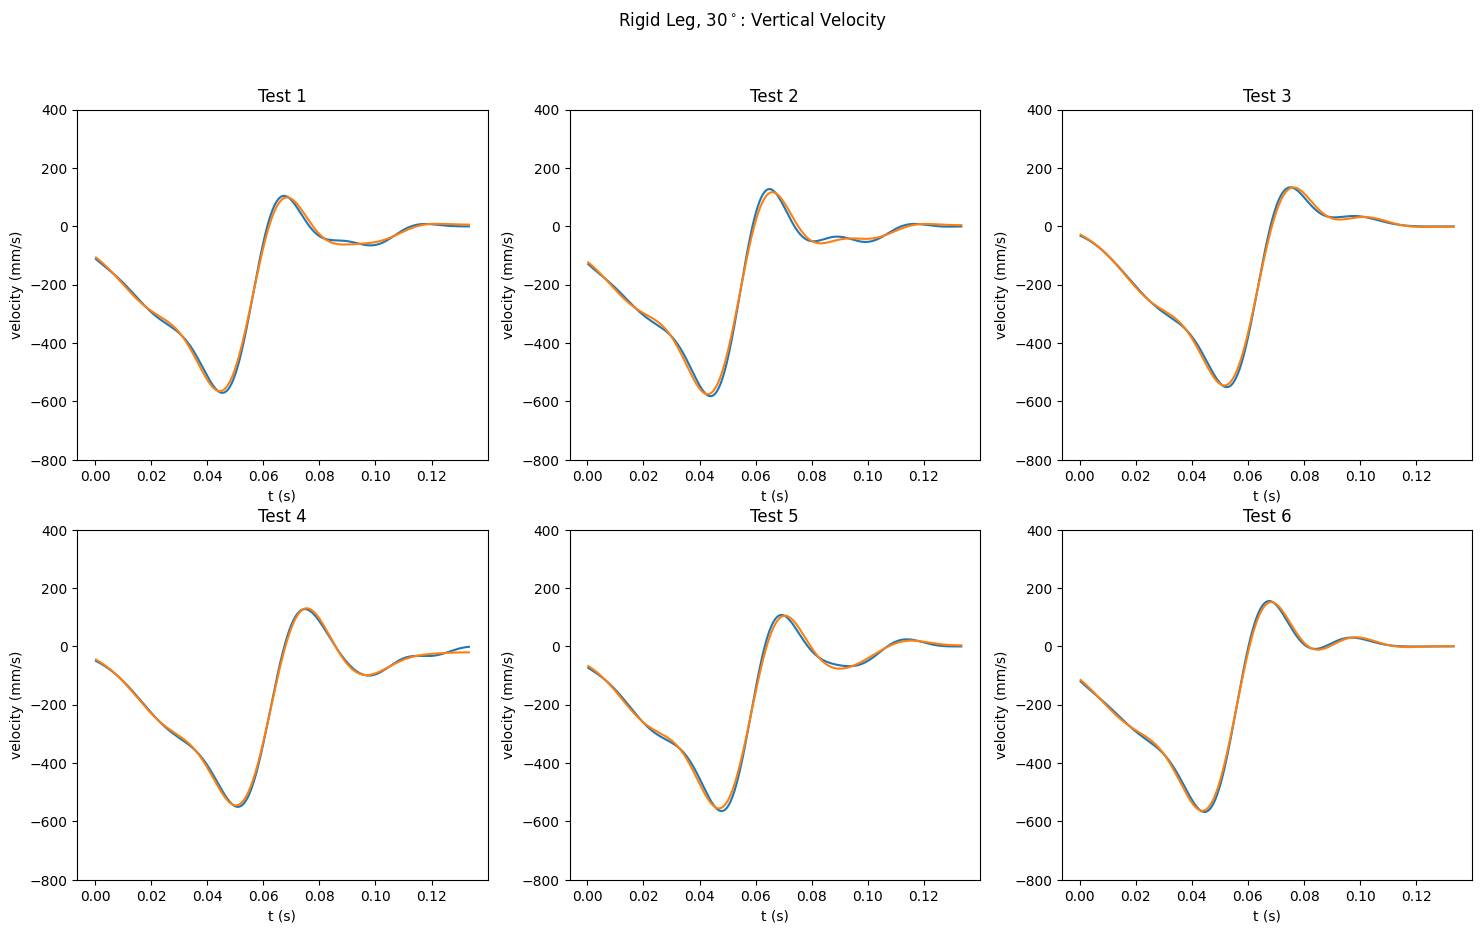

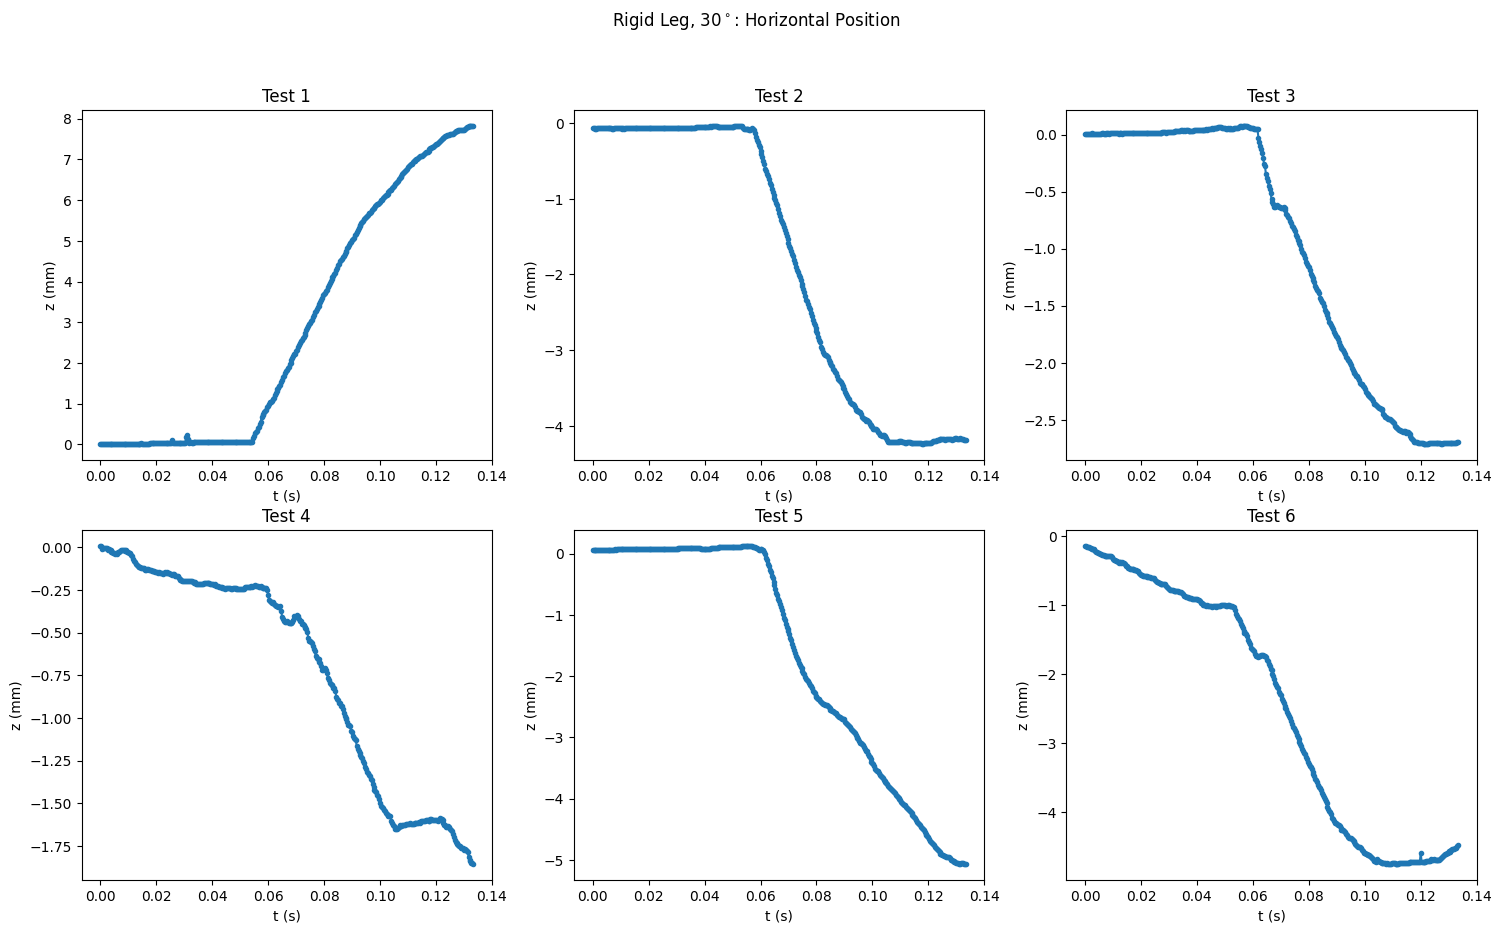

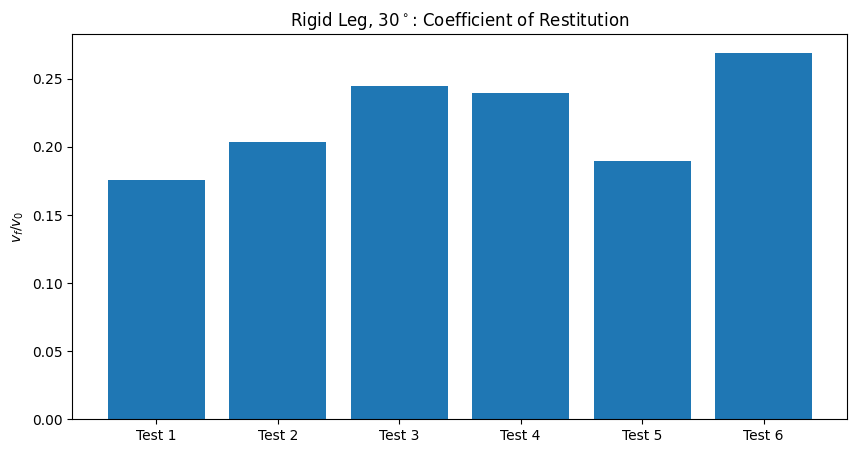

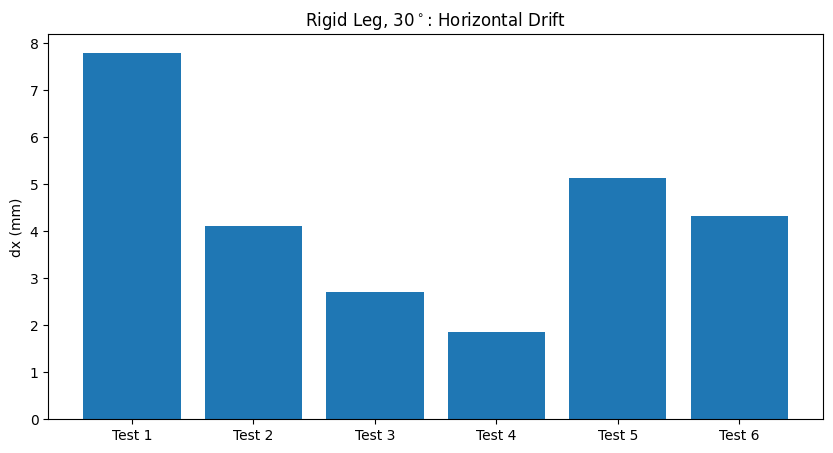

In [ ]:
current_dir = os.getcwd()
dir_path = current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Rigid Leg/30deg Stance/"
plot_drop_test(dir_path, leg_name=r"Rigid Leg, 30$^\circ$")

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Rigid Leg/45deg Stance/rigid_45deg_test6_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Rigid Leg/45deg Stance/rigid_45deg_test1_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Rigid Leg/45deg Stance/rigid_45deg_test2_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Rigid Leg/45deg Stance/rigid_45deg_test1_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coeffici

(0.23720526137579043,
 0.08115273010116648,
 1.7819404116666666,
 0.7834621380431563)

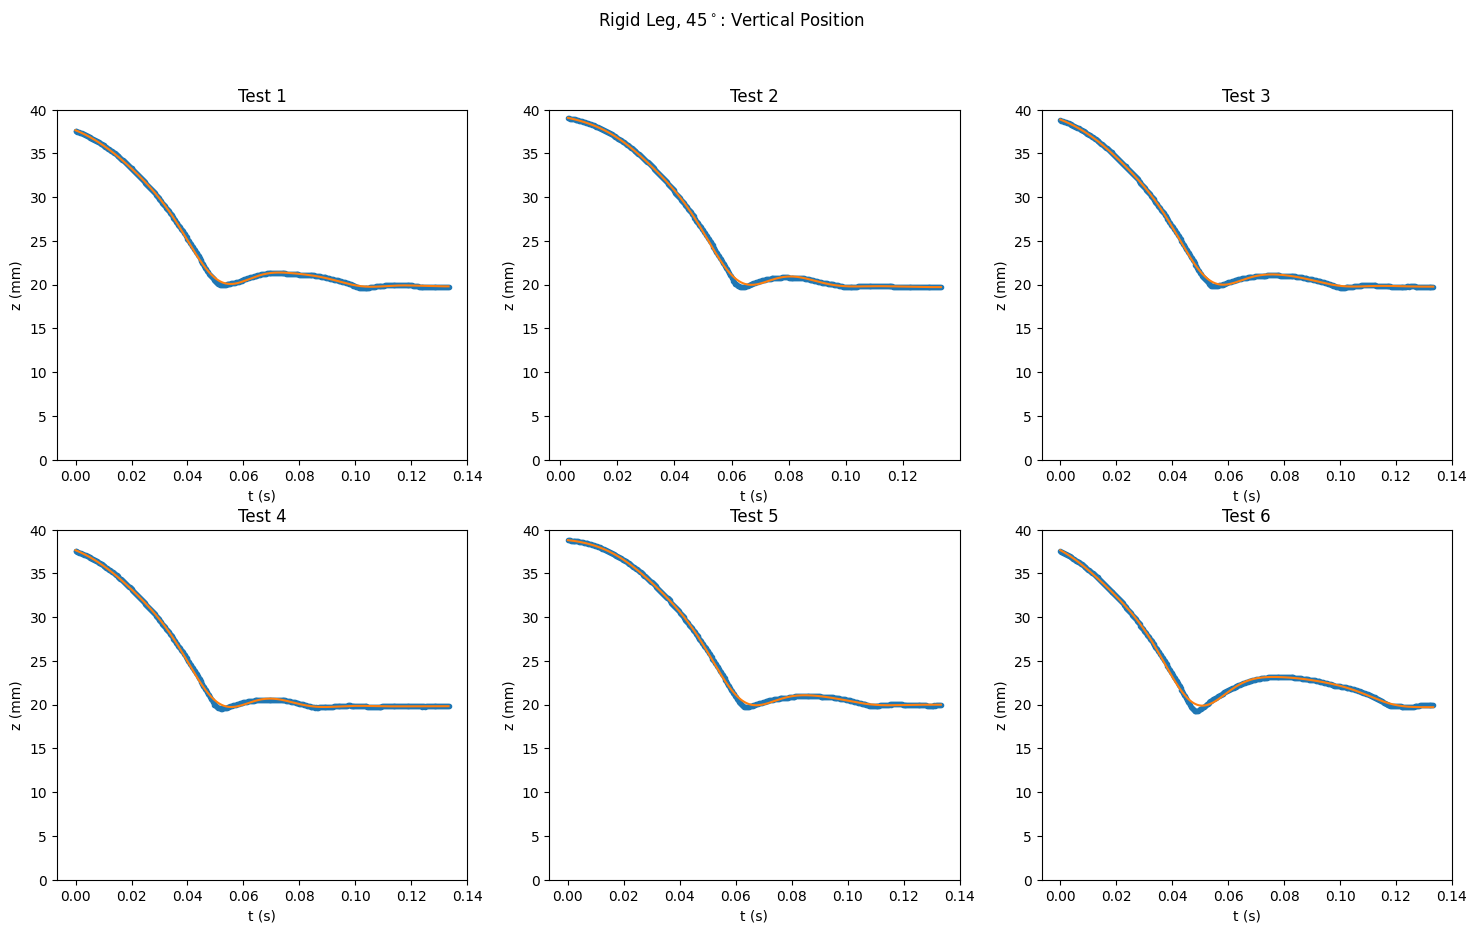

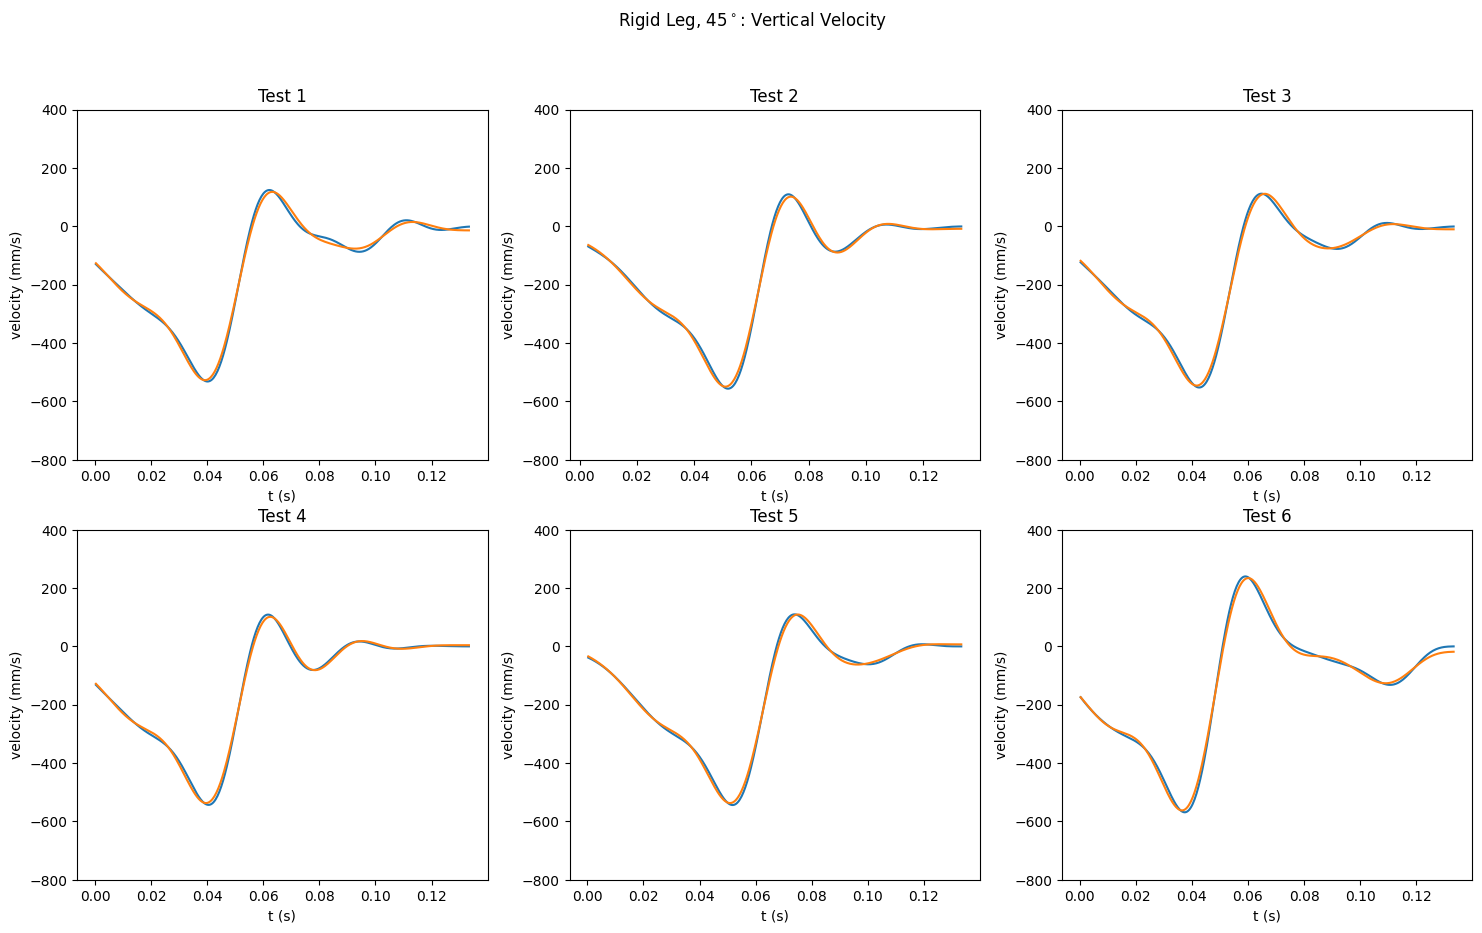

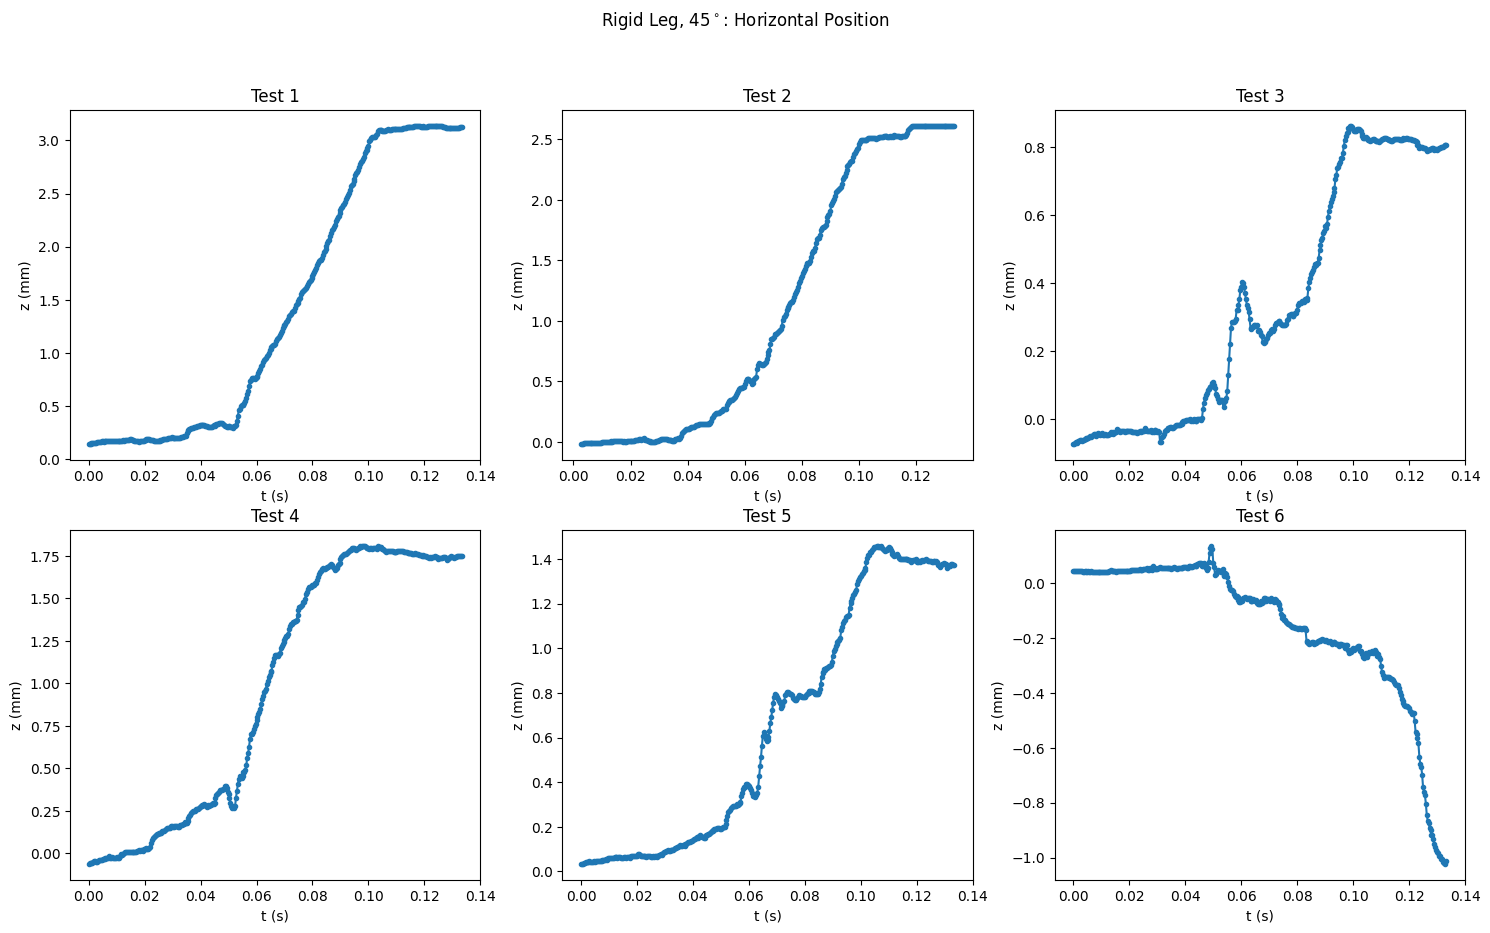

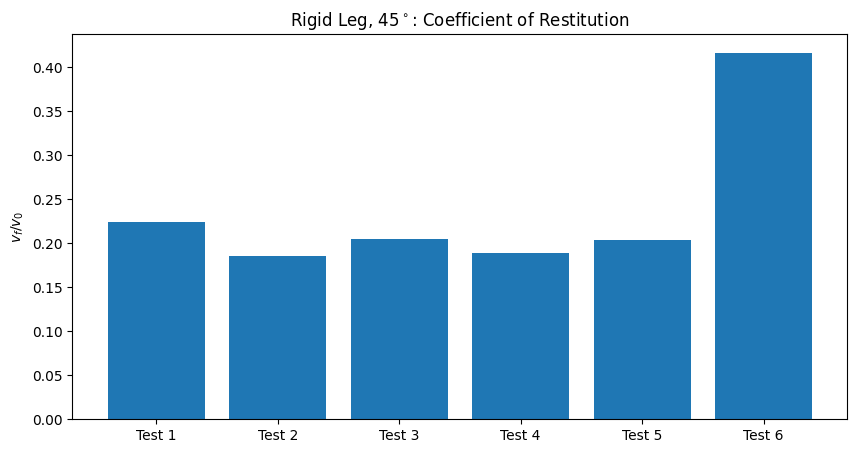

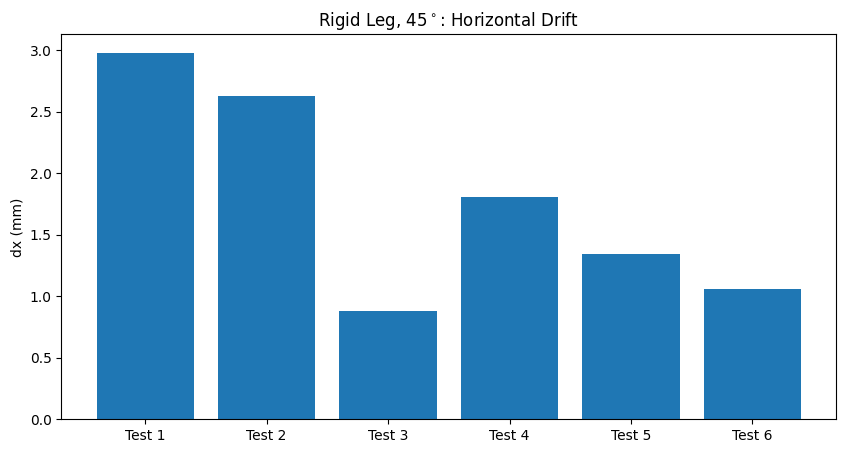

In [ ]:
current_dir = os.getcwd()
dir_path = current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Rigid Leg/45deg Stance/"
plot_drop_test(dir_path, leg_name=r"Rigid Leg, 45$^\circ$")

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Rigid Leg/60deg Stance/rigid_60deg_test6_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Rigid Leg/60deg Stance/rigid_60deg_test1_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Rigid Leg/60deg Stance/rigid_60deg_test2_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Rigid Leg/60deg Stance/rigid_60deg_test1_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coeffici

(0.4938405766194291,
 0.06470430414655298,
 1.1997632089999999,
 1.0099598623766592)

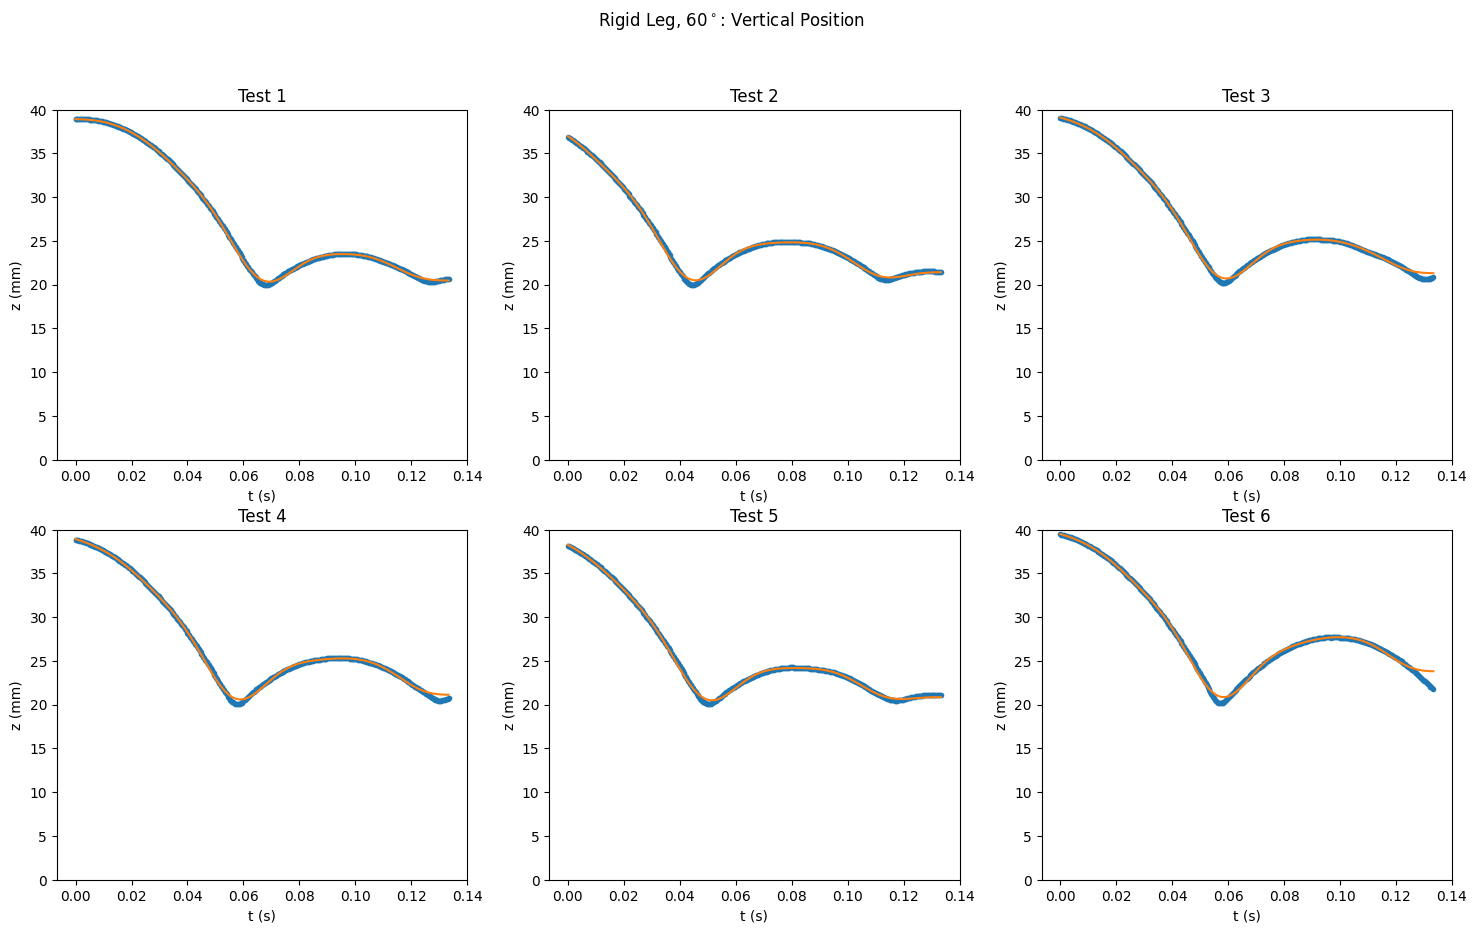

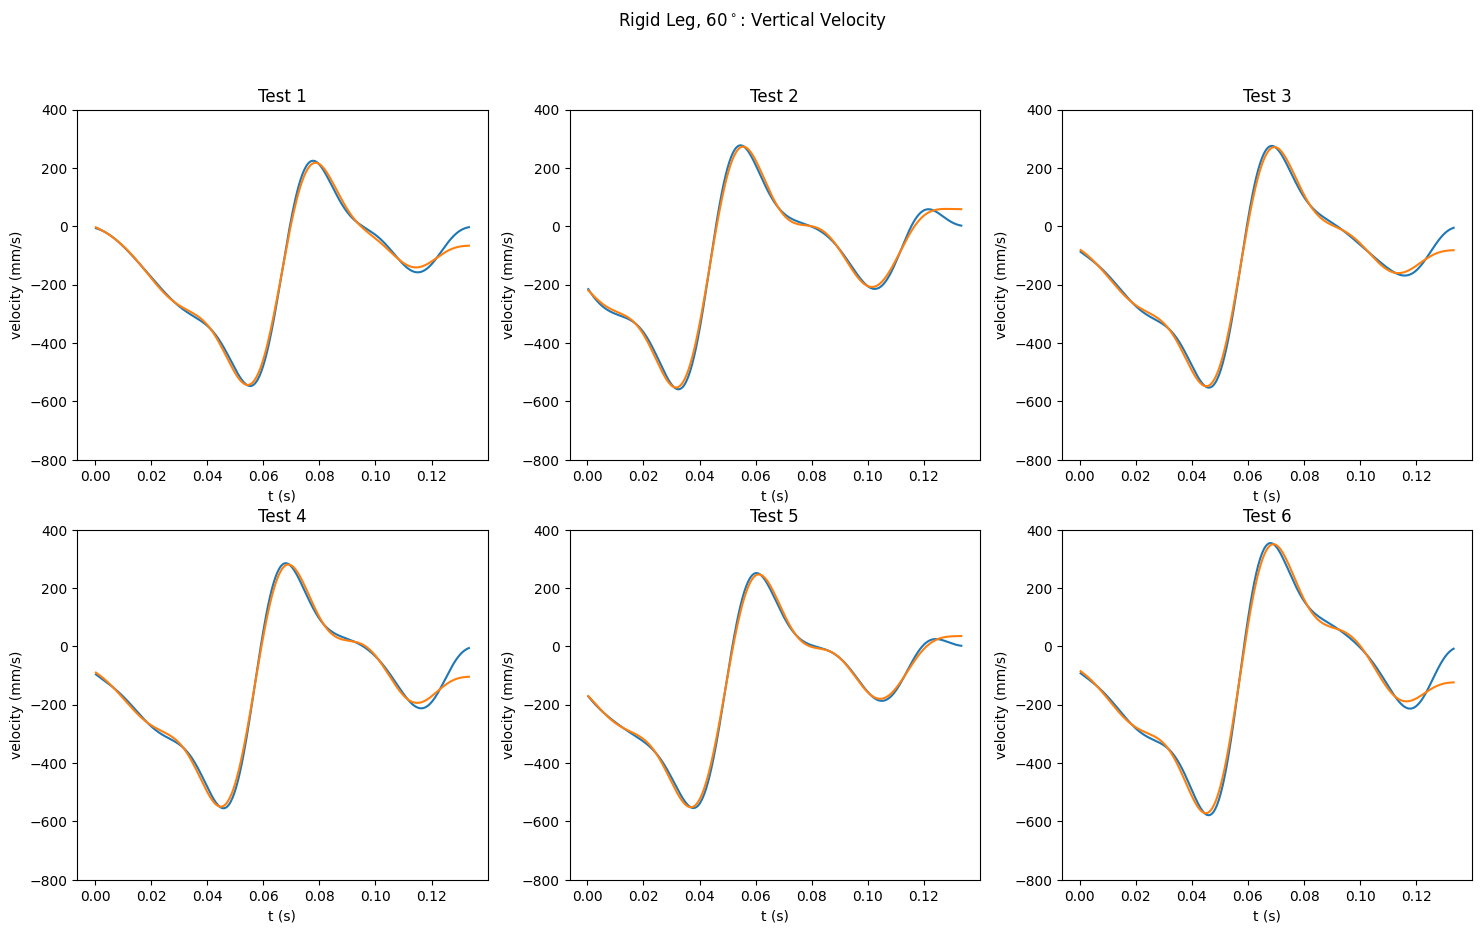

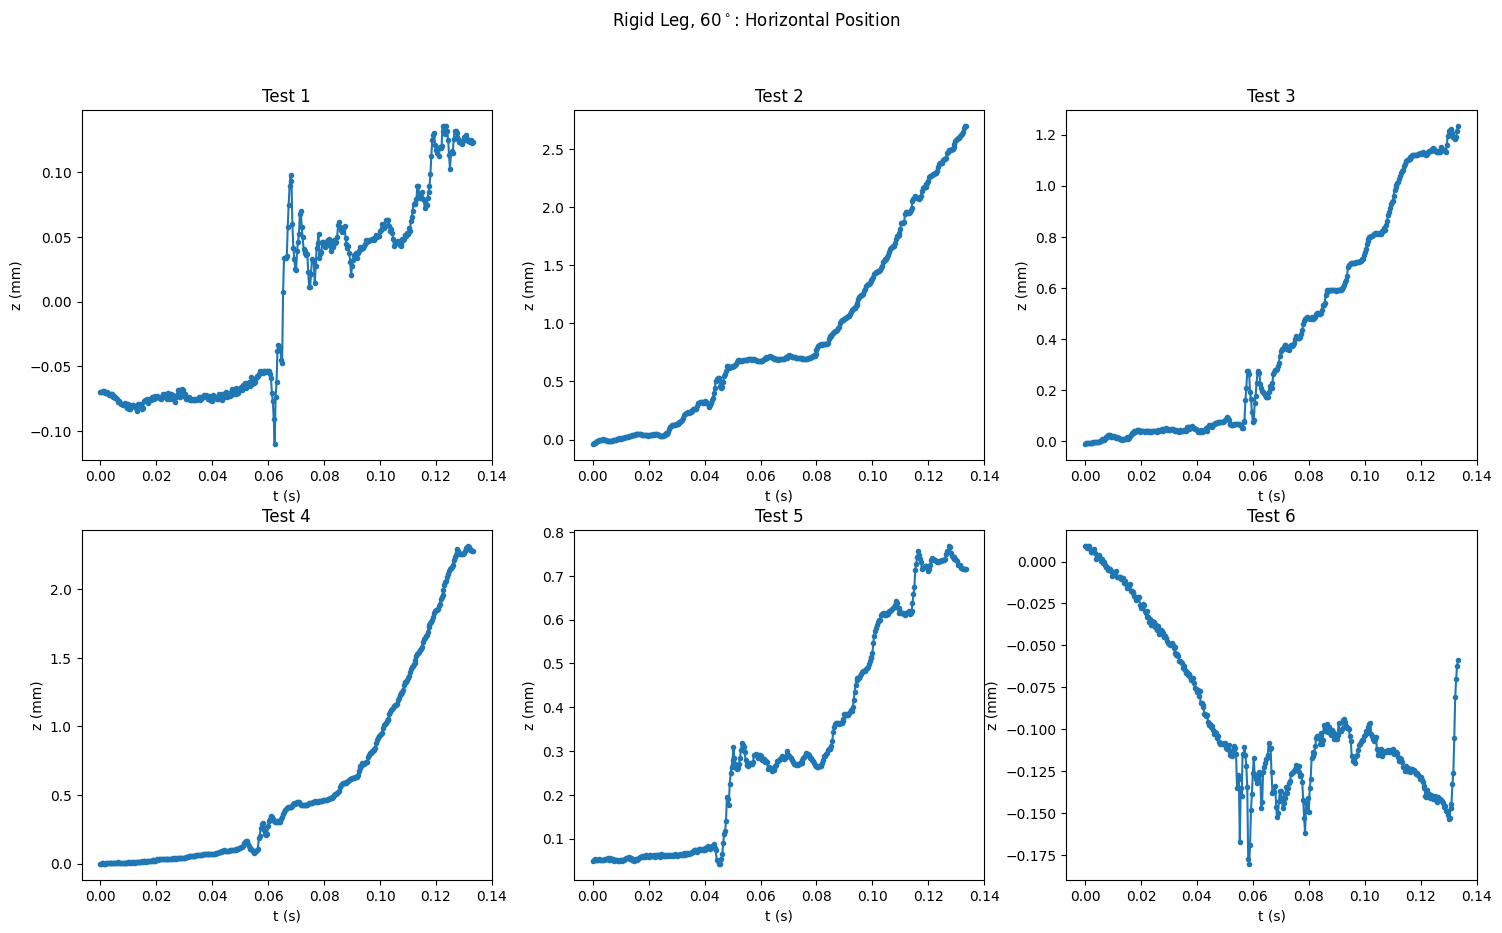

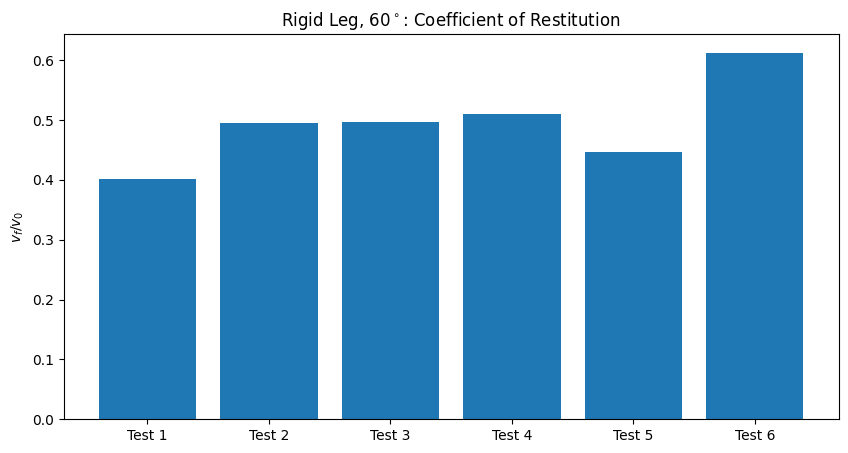

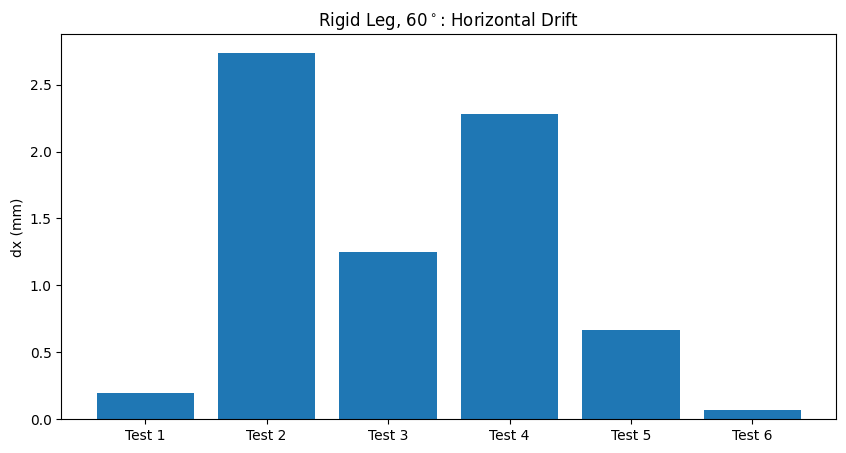

In [ ]:
current_dir = os.getcwd()
dir_path = current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Rigid Leg/60deg Stance/"
plot_drop_test(dir_path, leg_name=r"Rigid Leg, 60$^\circ$")

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/1-Joint Leg/25um Kapton-TPE Joint/1joint_25um_45deg_test3_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/1-Joint Leg/25um Kapton-TPE Joint/1joint_25um_45deg_test4_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/1-Joint Leg/25um Kapton-TPE Joint/1joint_25um_45deg_test2_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/1-Joint Leg/25um Kapton-TPE Joint/1joint_25um_45deg_test4_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee

(0.28763774999858216,
 0.010894501665582765,
 0.7179840815833334,
 0.7387625675179552)

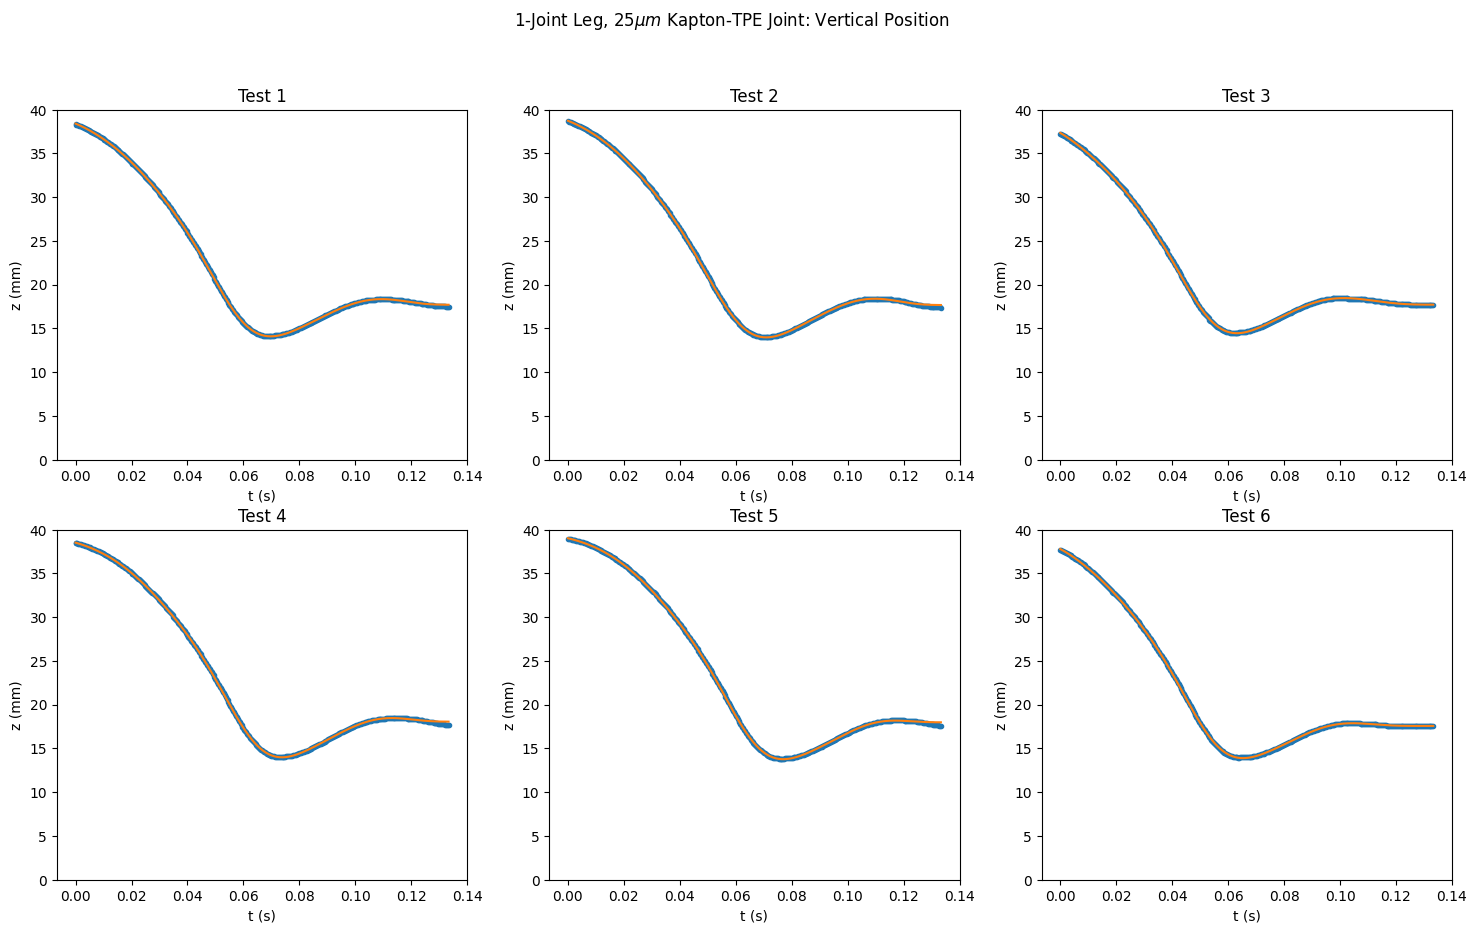

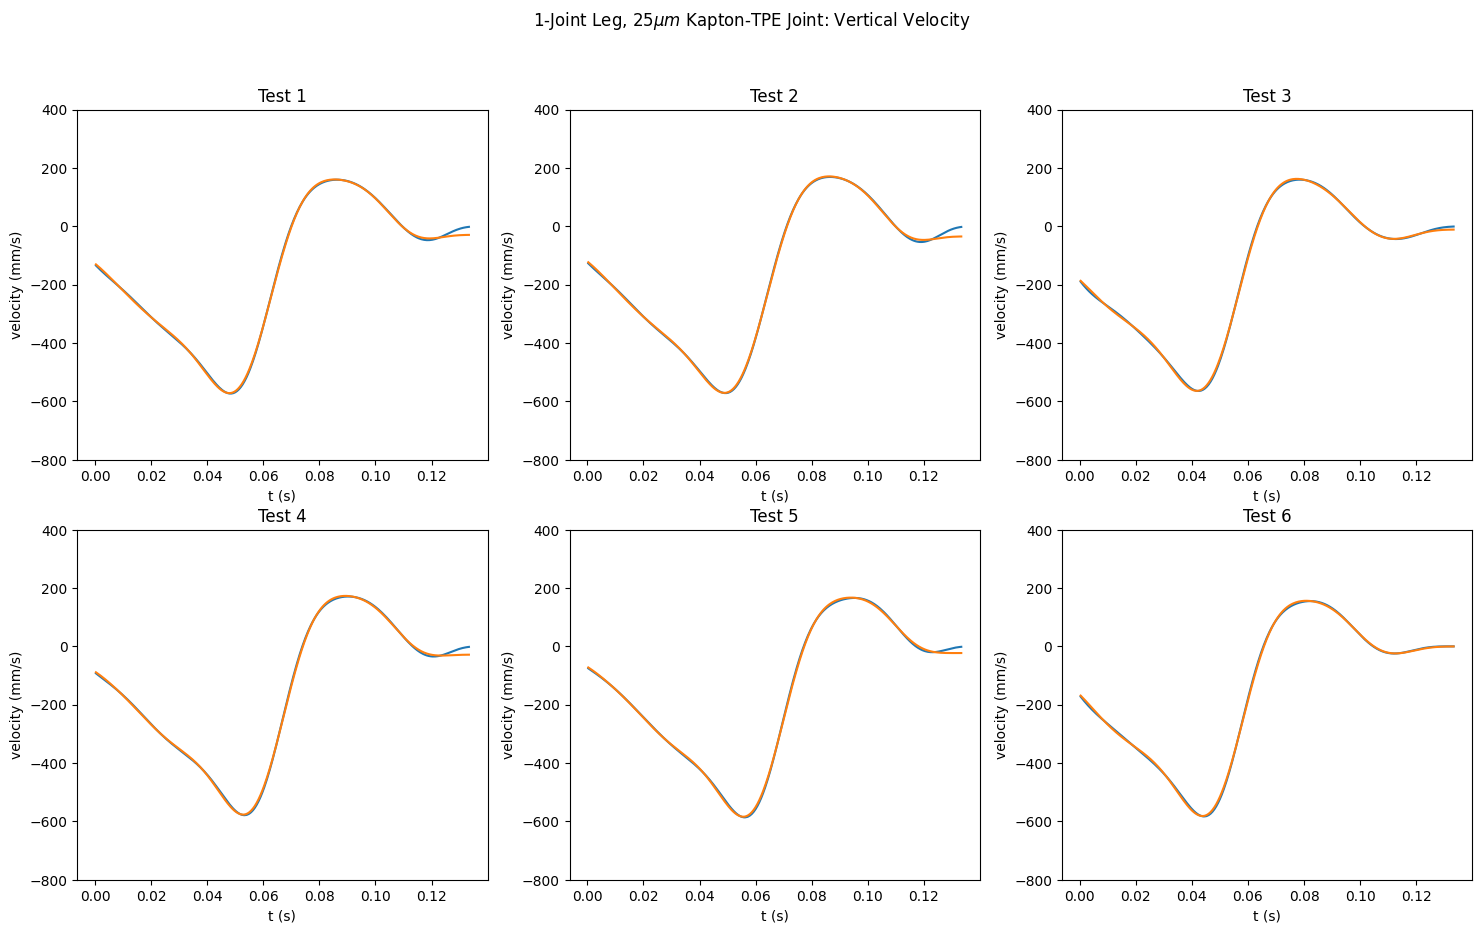

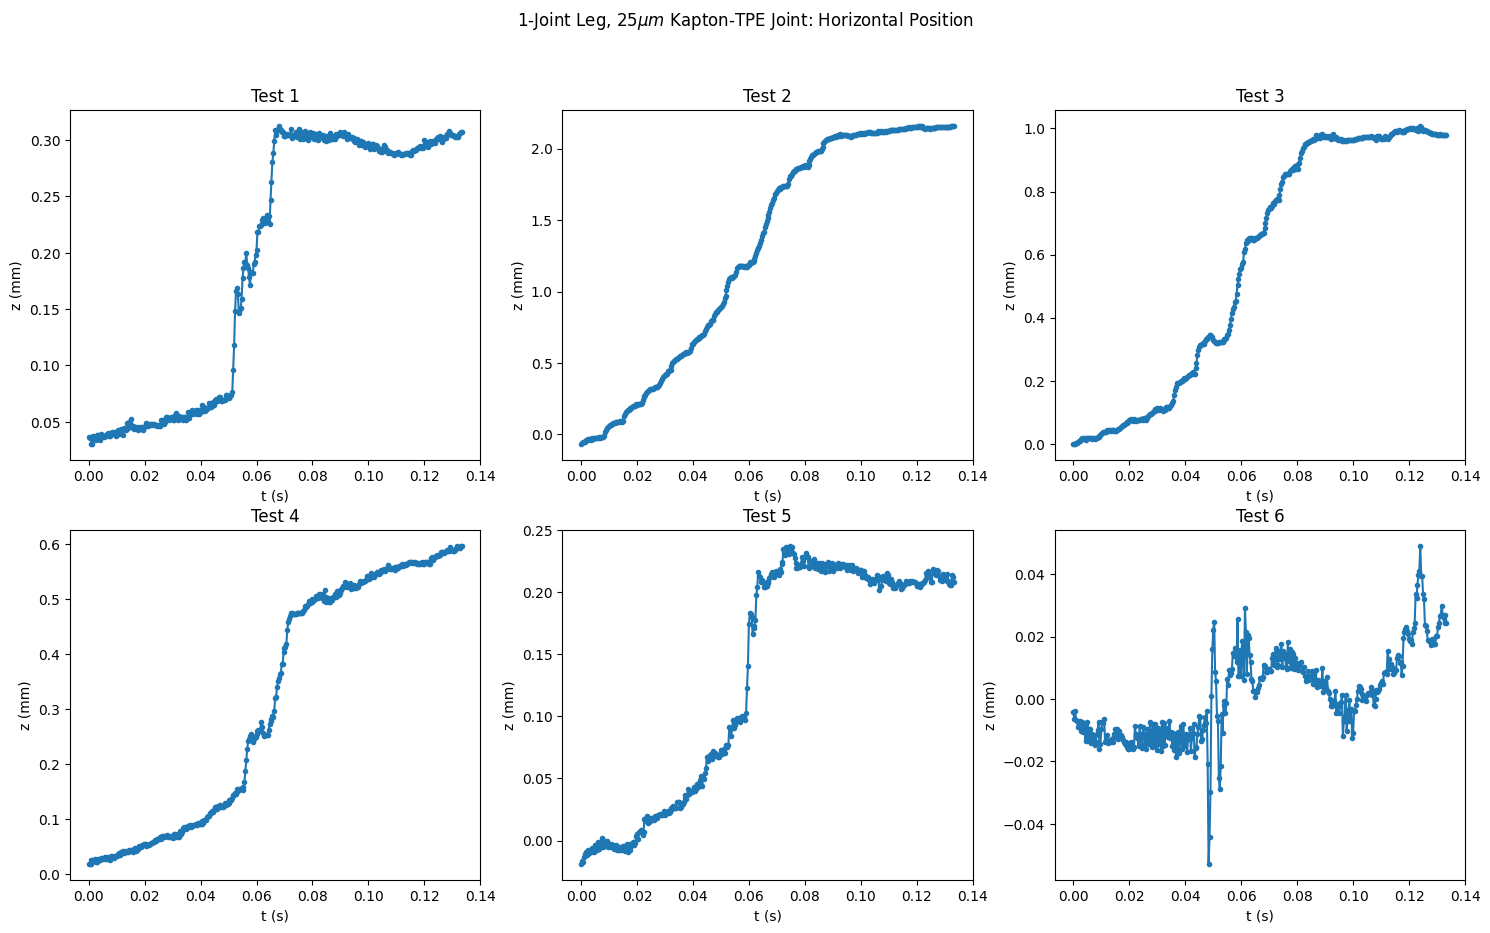

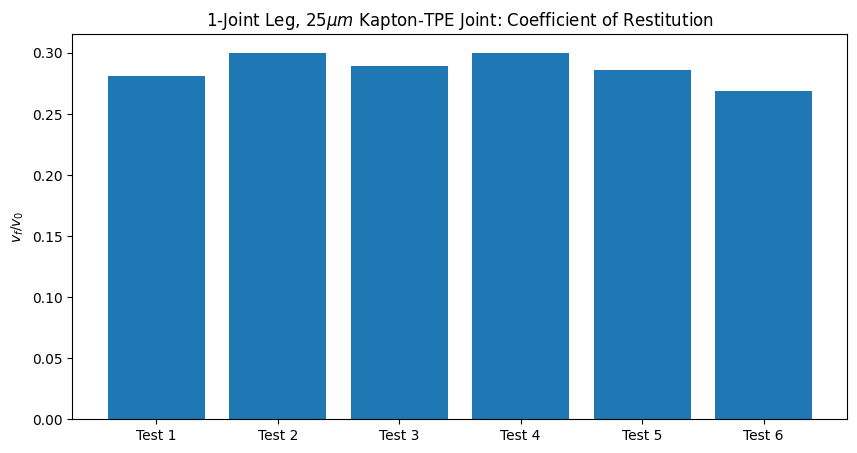

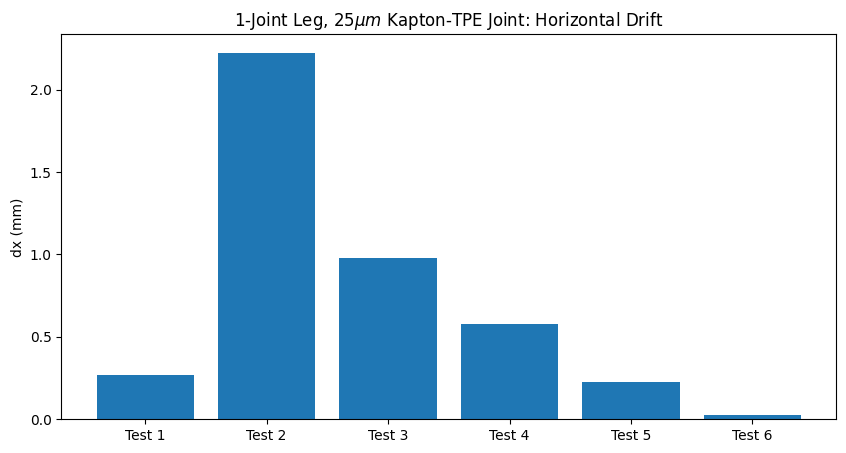

In [ ]:
current_dir = os.getcwd()
dir_path = current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/1-Joint Leg/25um Kapton-TPE Joint/"
plot_drop_test(dir_path, leg_name=r"1-Joint Leg, 25$\mu m$ Kapton-TPE Joint")

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/1-Joint Leg/50um Kapton-TPE Joint/1joint_50um_45deg_test2_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/1-Joint Leg/50um Kapton-TPE Joint/1joint_50um_45deg_test5_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/1-Joint Leg/50um Kapton-TPE Joint/1joint_50um_45deg_test3_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/1-Joint Leg/50um Kapton-TPE Joint/1joint_50um_45deg_test5_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee

(0.39152577076257417,
 0.012657126983478168,
 0.6015476783333332,
 0.5677782856949074)

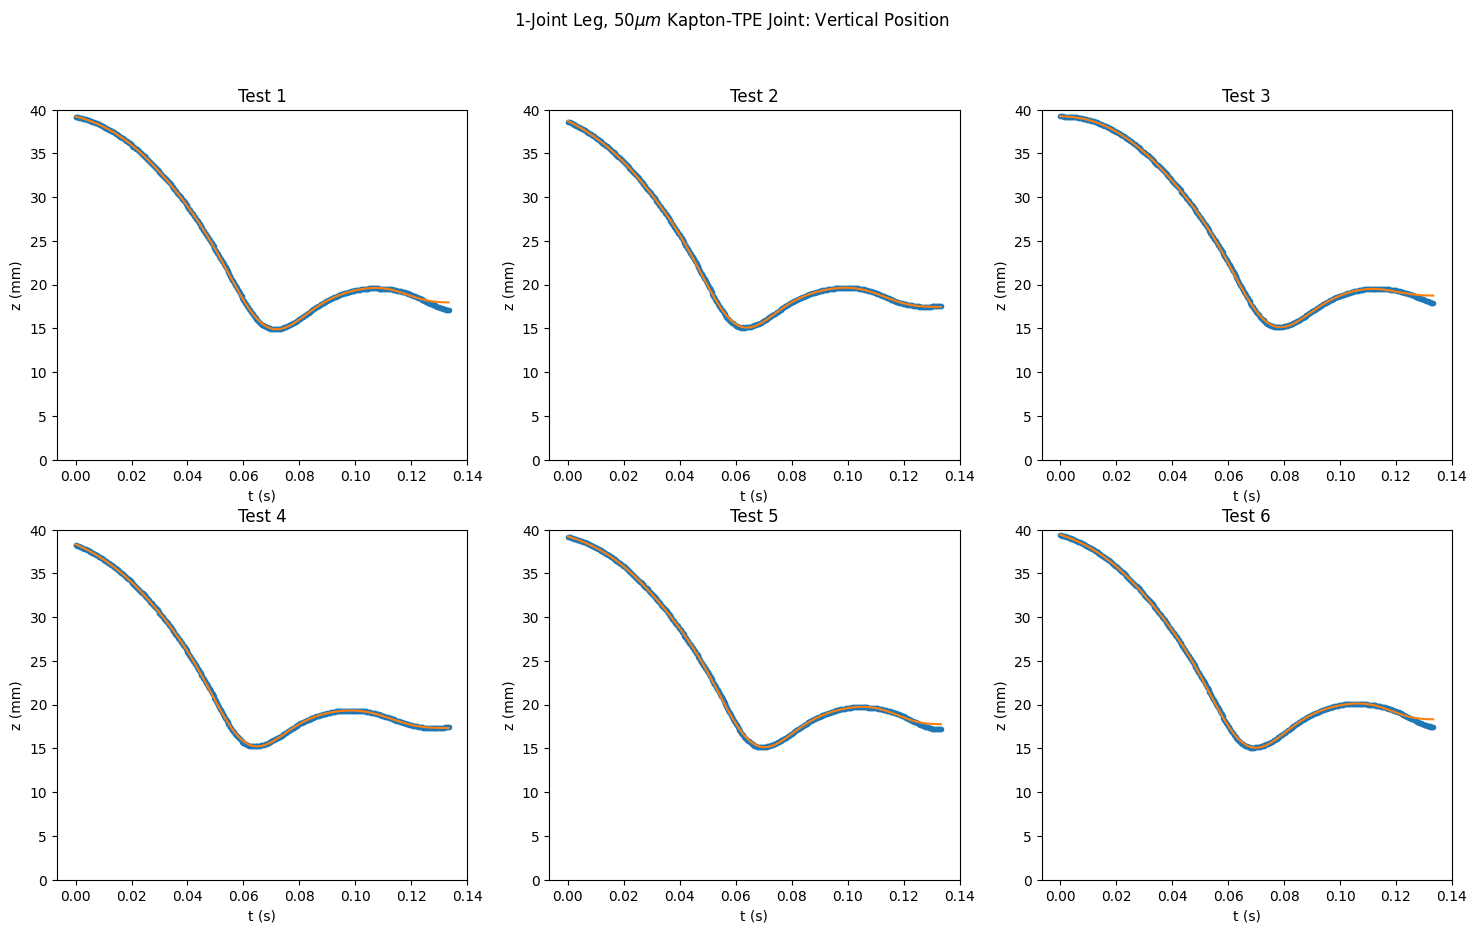

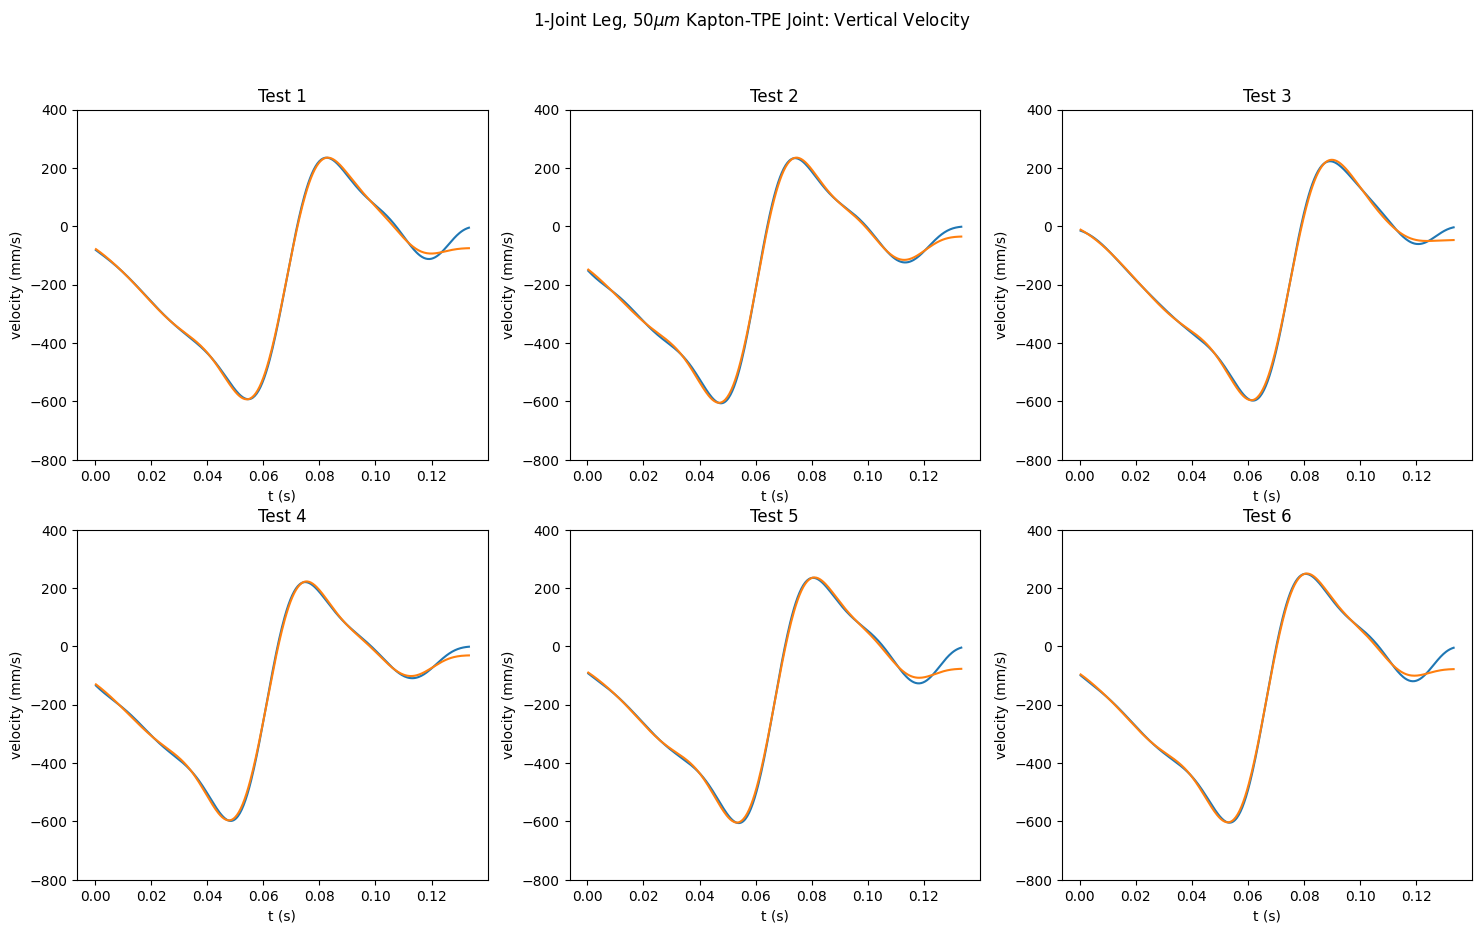

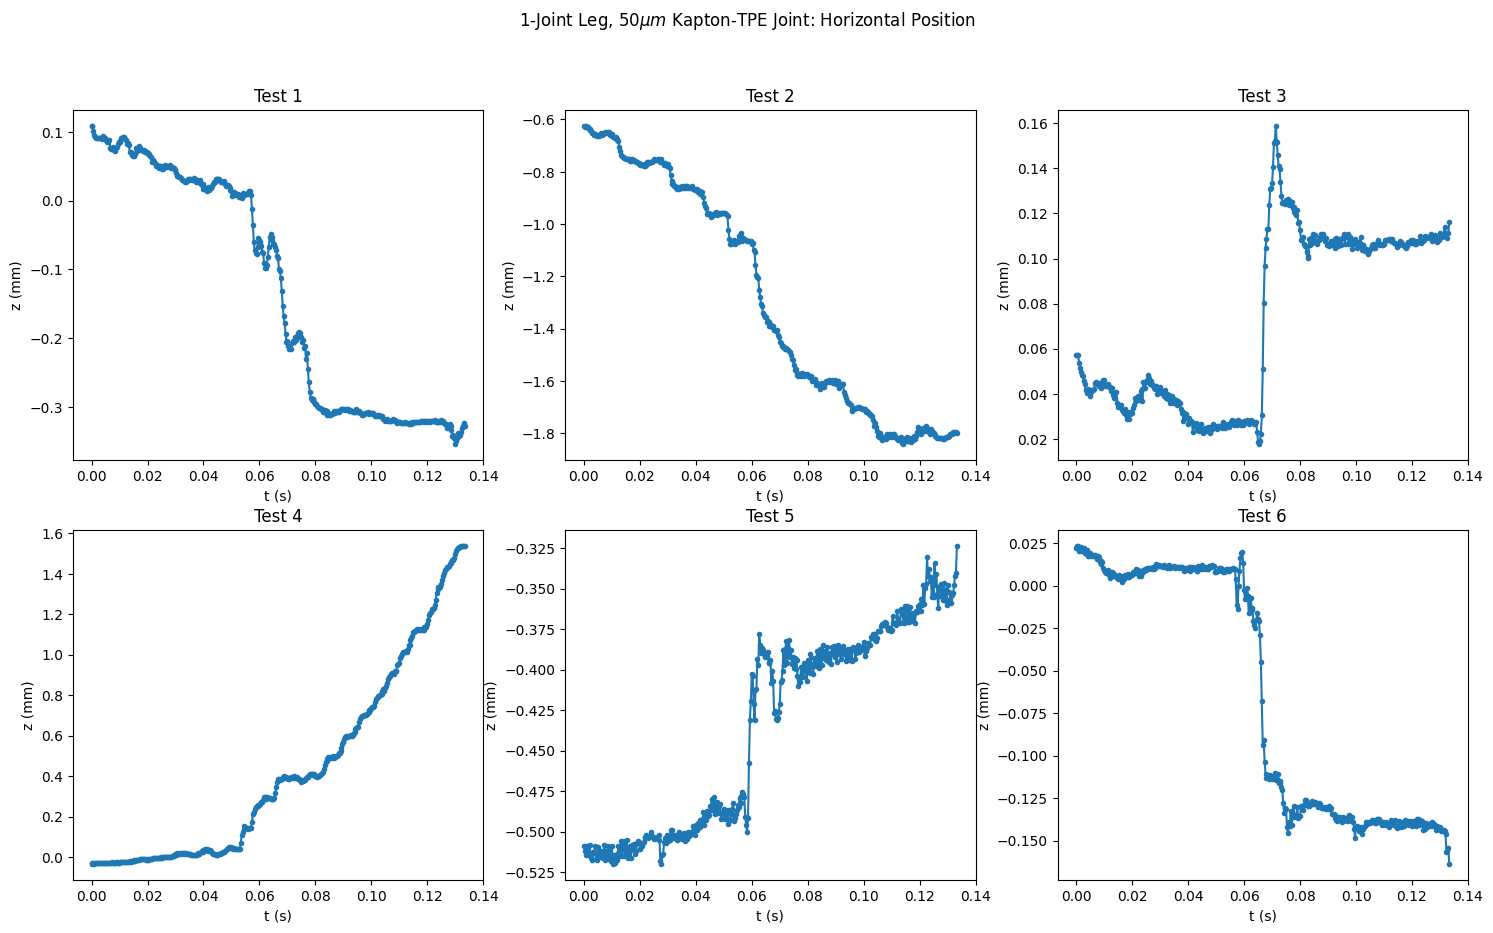

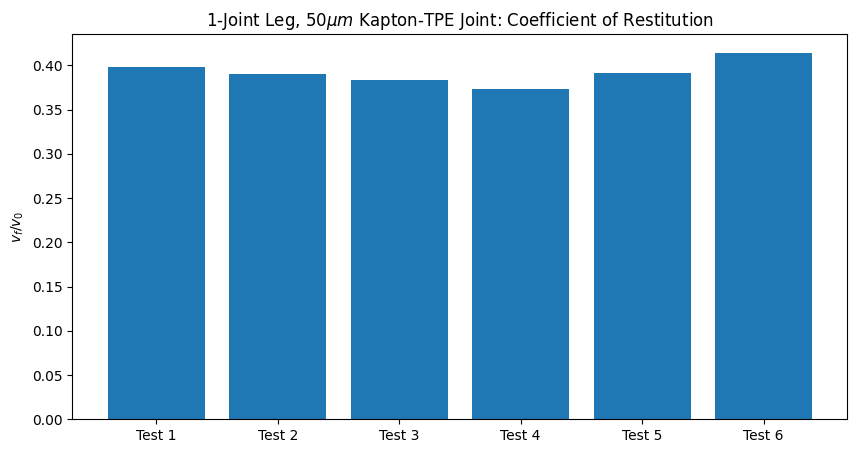

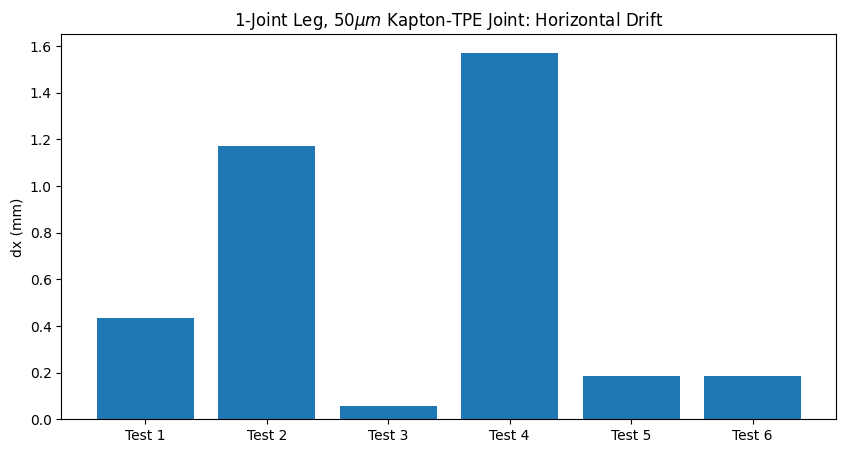

In [ ]:
current_dir = os.getcwd()
dir_path = current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/1-Joint Leg/50um Kapton-TPE Joint/"
plot_drop_test(dir_path, leg_name=r"1-Joint Leg, 50$\mu m$ Kapton-TPE Joint")

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-0um Kapton-TPE and 40-60 Tibia-Tarsus/2joint_25-0um_40-60_45deg_test3_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-0um Kapton-TPE and 40-60 Tibia-Tarsus/2joint_25-0um_40-60_45deg_test4_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-0um Kapton-TPE and 40-60 Tibia-Tarsus/2joint_25-0um_40-60_45deg_test2_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-0um Kapton-TPE and 40-60 Tibia-Tarsus/2joint_25-0um_

(0.16104882653853098,
 0.02287346173608267,
 0.6850093616666667,
 0.7695180733818889)

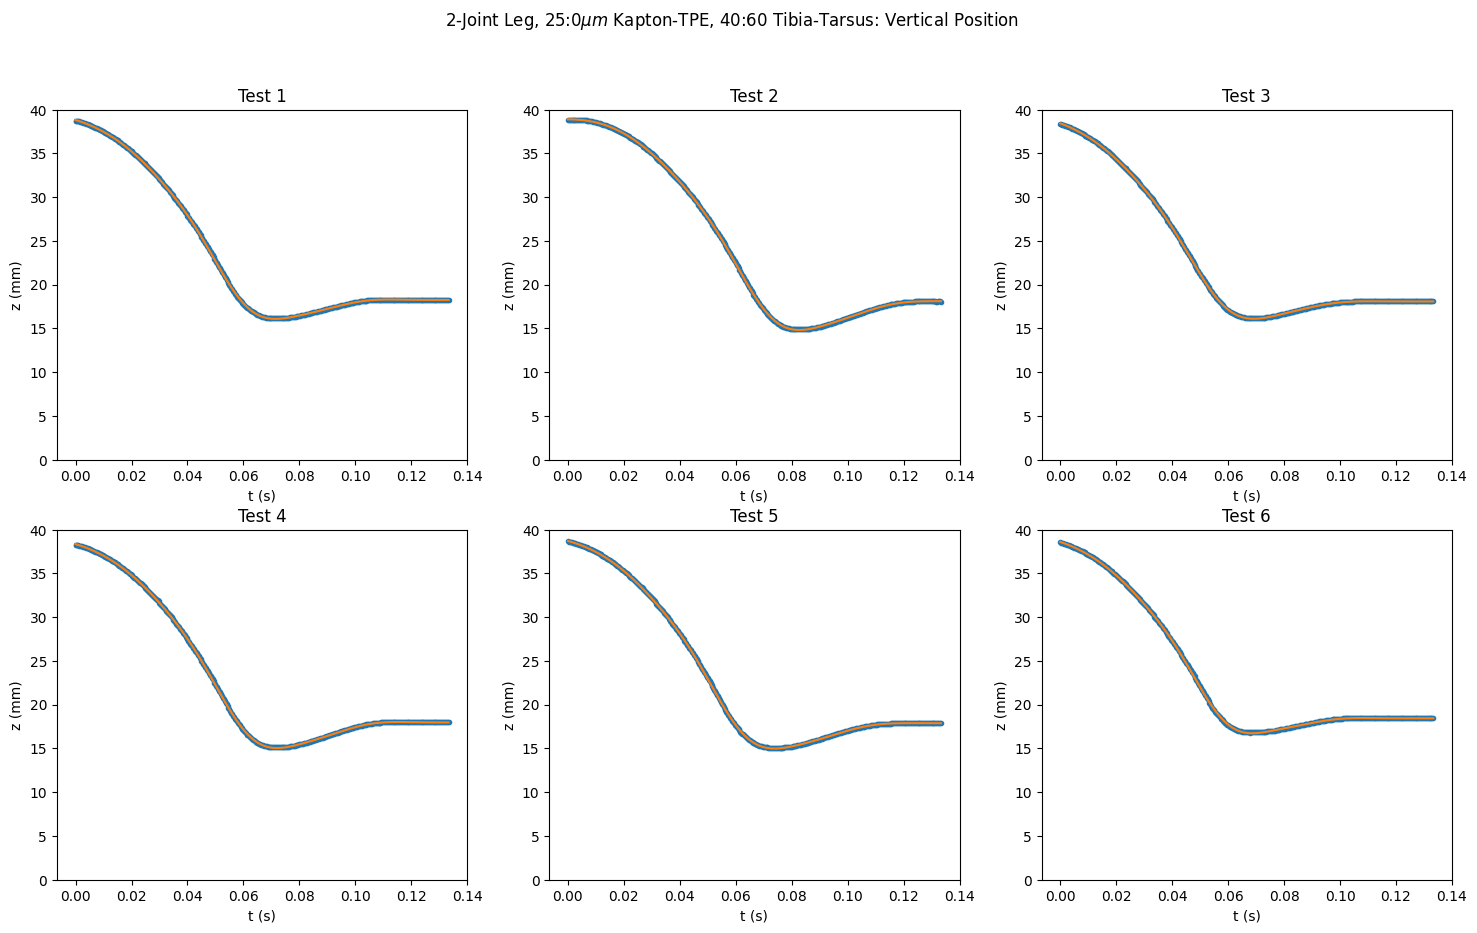

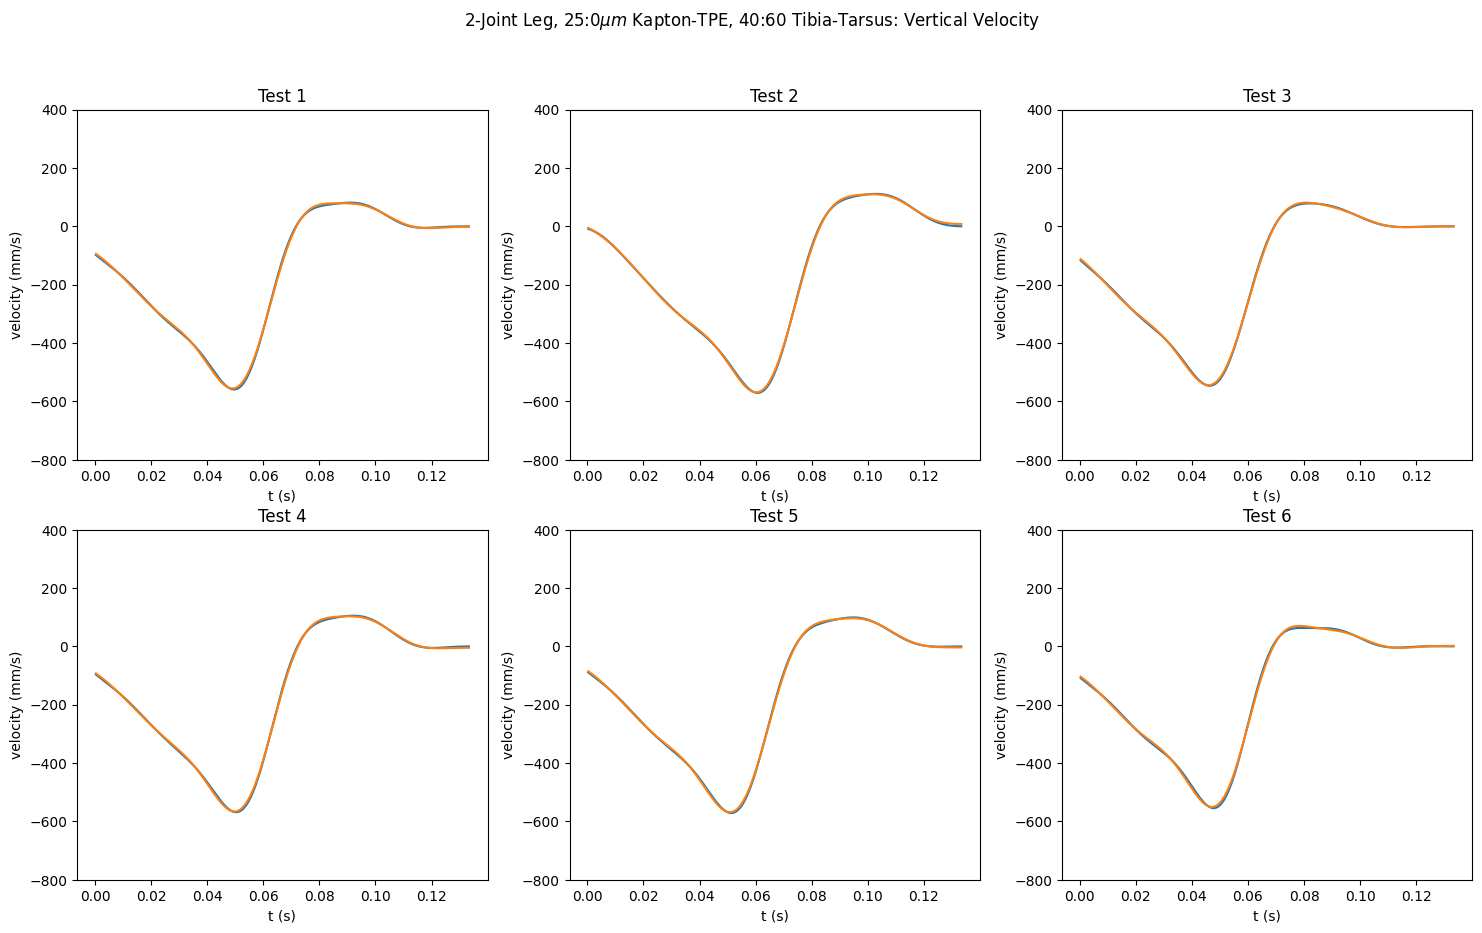

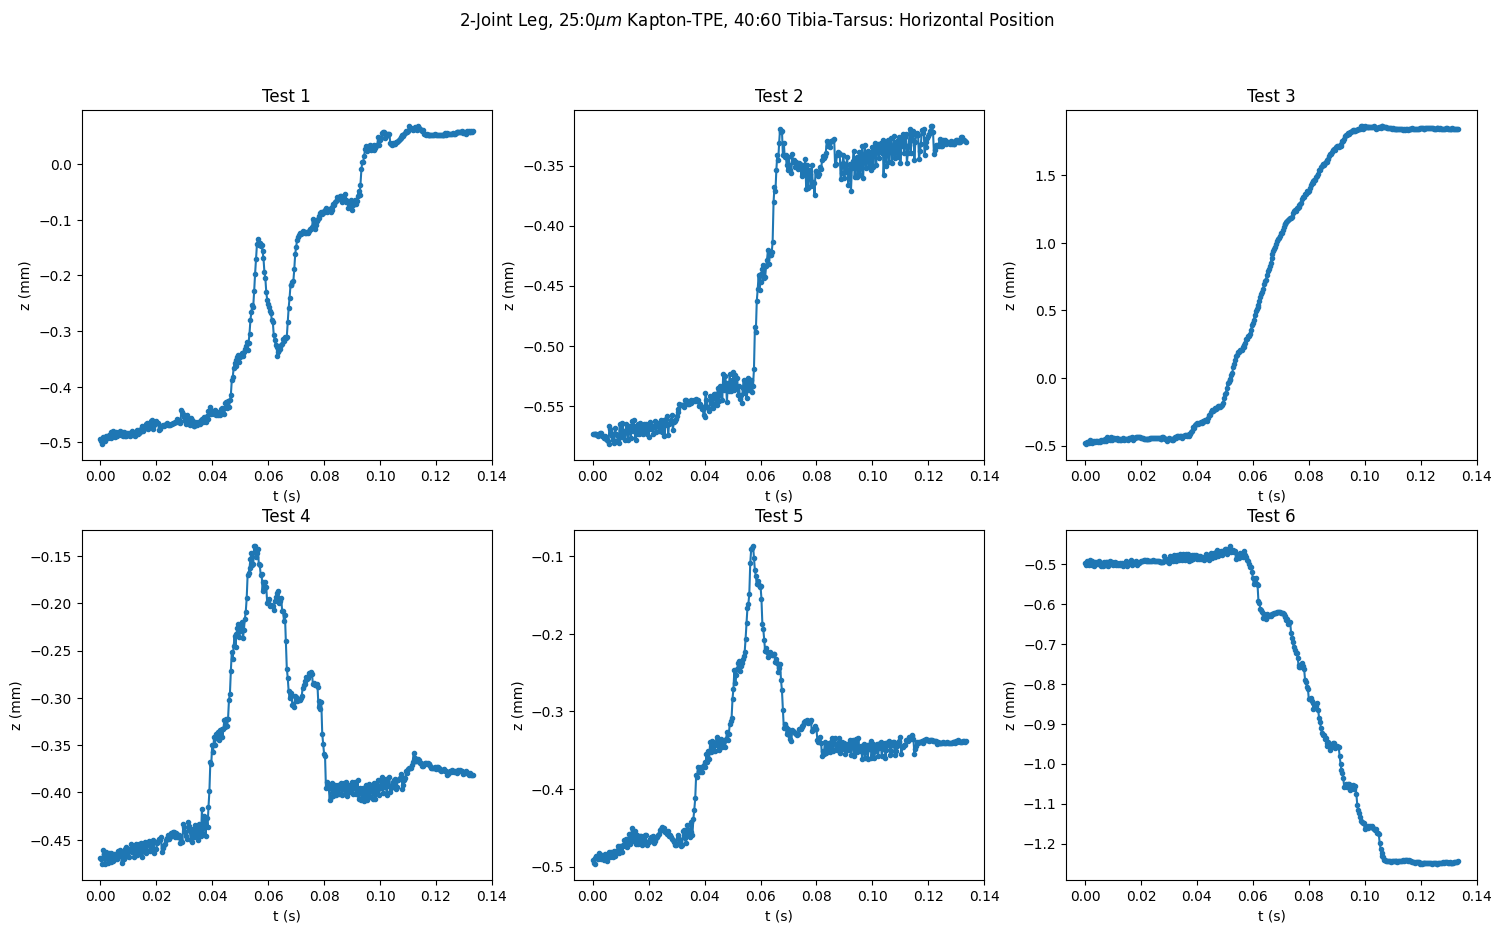

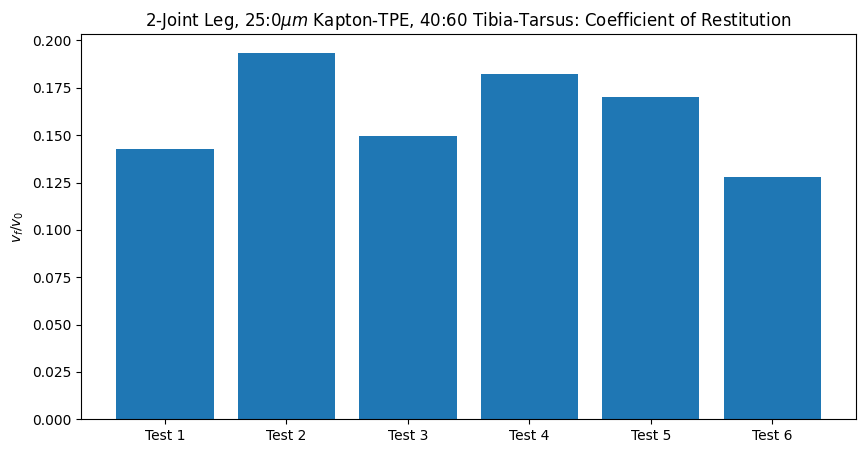

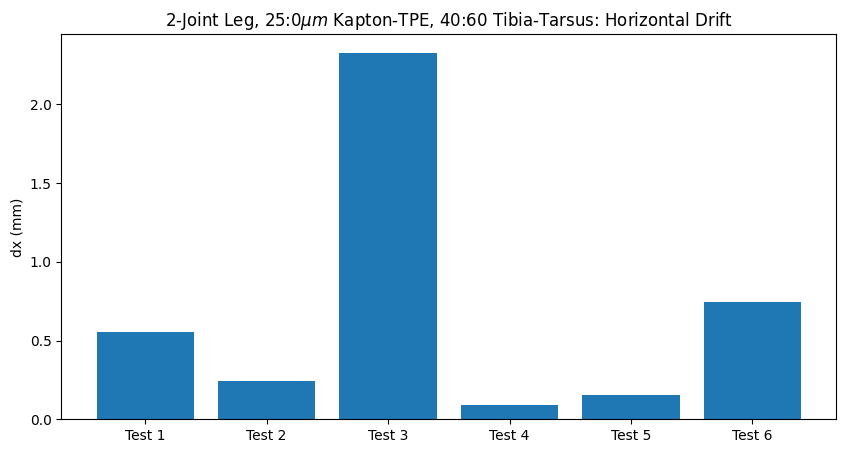

In [ ]:
current_dir = os.getcwd()
dir_path = current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-0um Kapton-TPE and 40-60 Tibia-Tarsus/"
plot_drop_test(dir_path, leg_name=r"2-Joint Leg, 25:0$\mu m$ Kapton-TPE, 40:60 Tibia-Tarsus")

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-0um Kapton-TPE and 60-40 Tibia-Tarsus/2joint_25-0um_60-40_45deg_test5_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-0um Kapton-TPE and 60-40 Tibia-Tarsus/2joint_25-0um_60-40_45deg_test2_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-0um Kapton-TPE and 60-40 Tibia-Tarsus/2joint_25-0um_60-40_45deg_test4_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-0um Kapton-TPE and 60-40 Tibia-Tarsus/2joint_25-0um_

(0.2871907679726366,
 0.011506450919828323,
 0.7789297666666667,
 0.636124456204378)

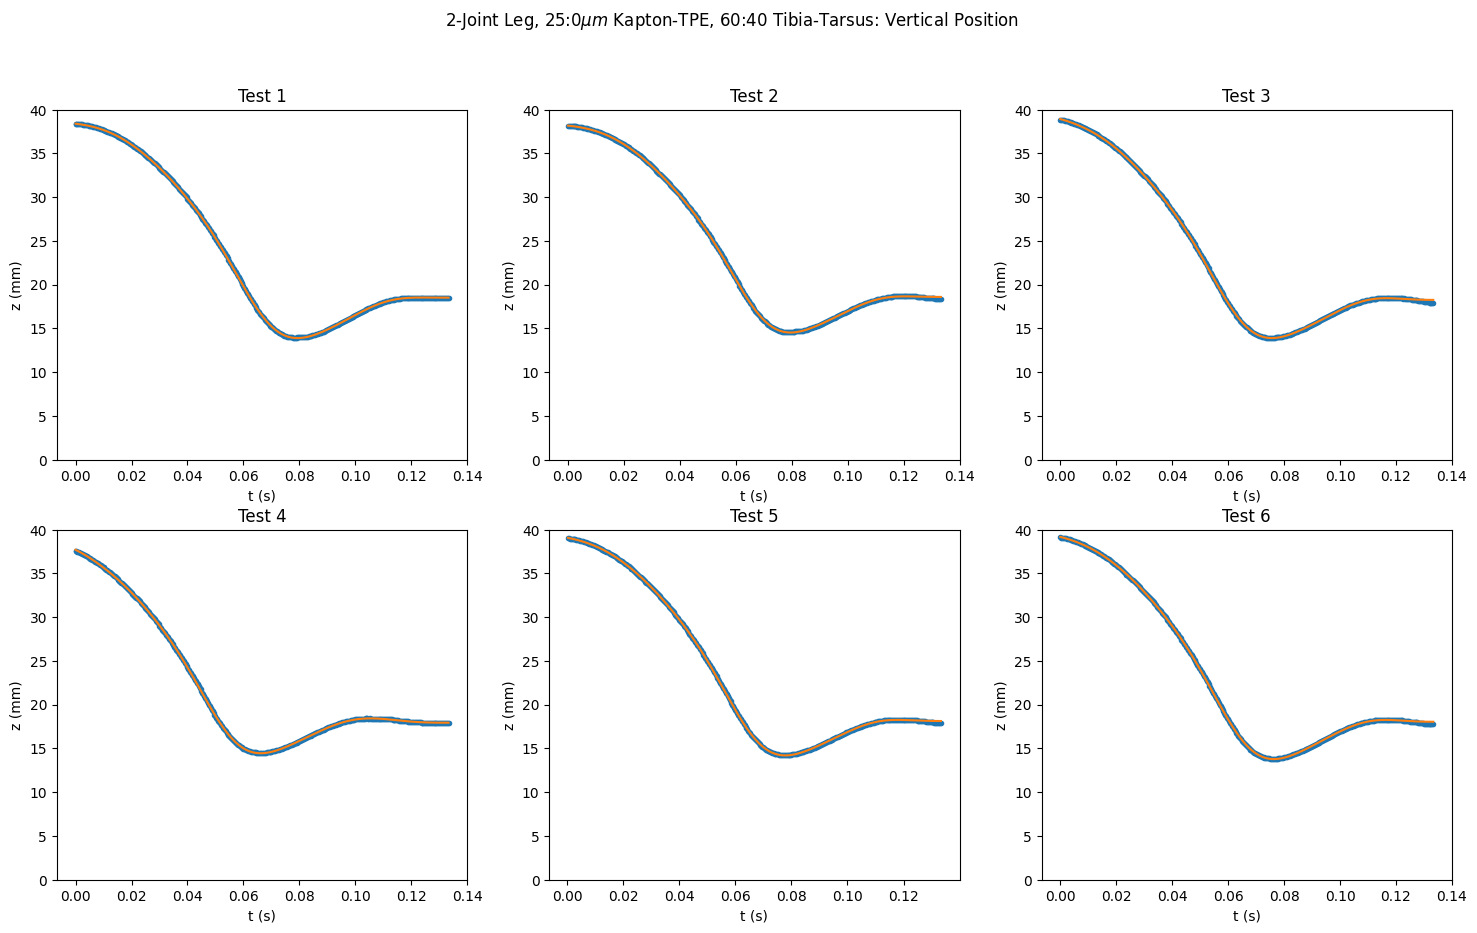

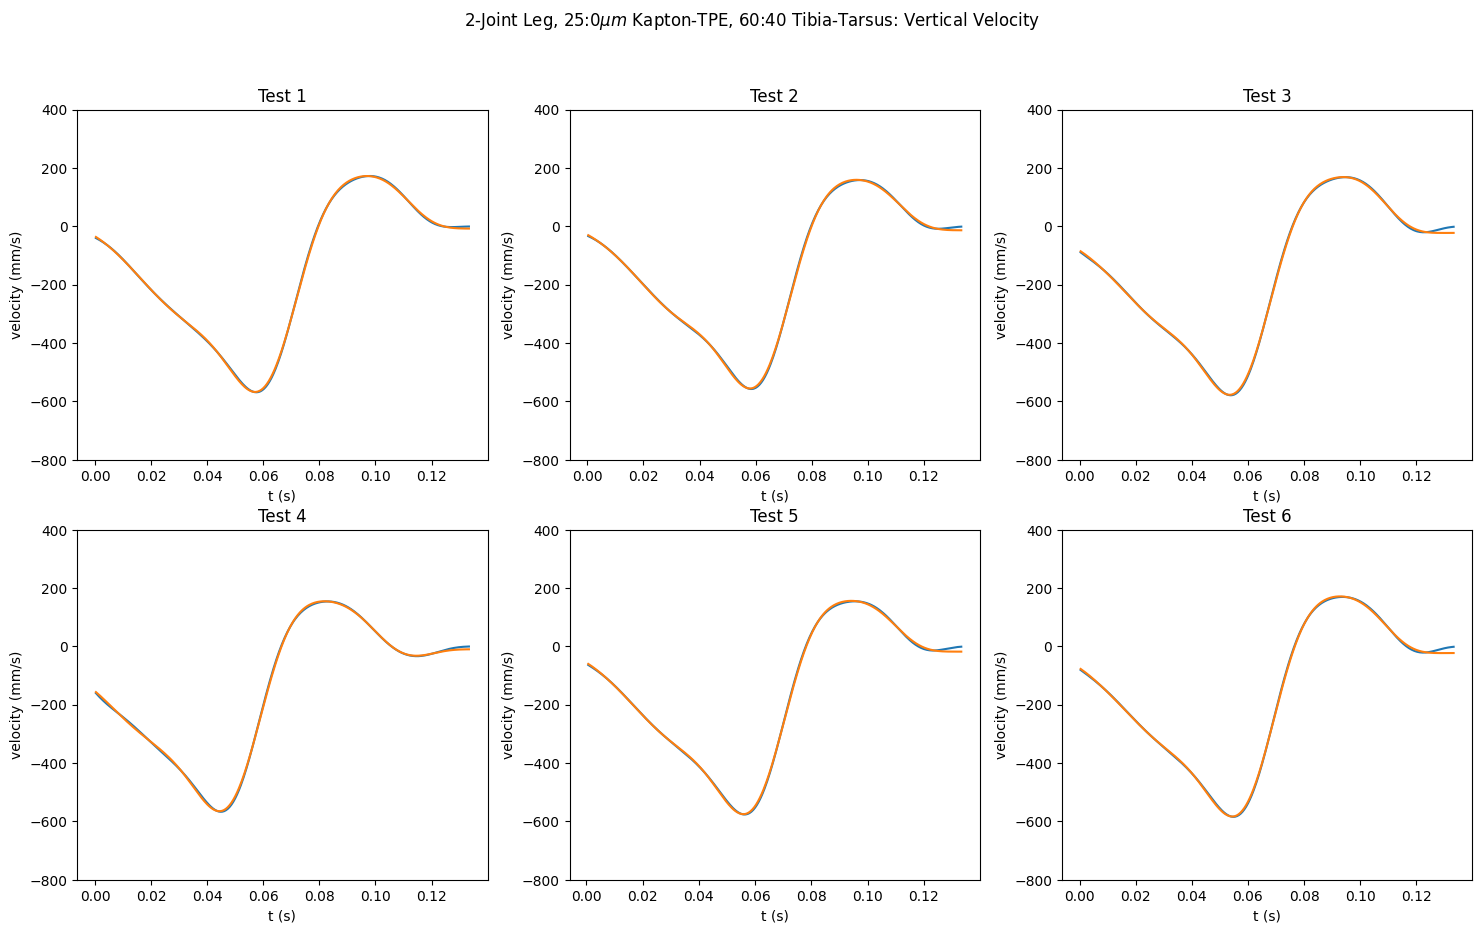

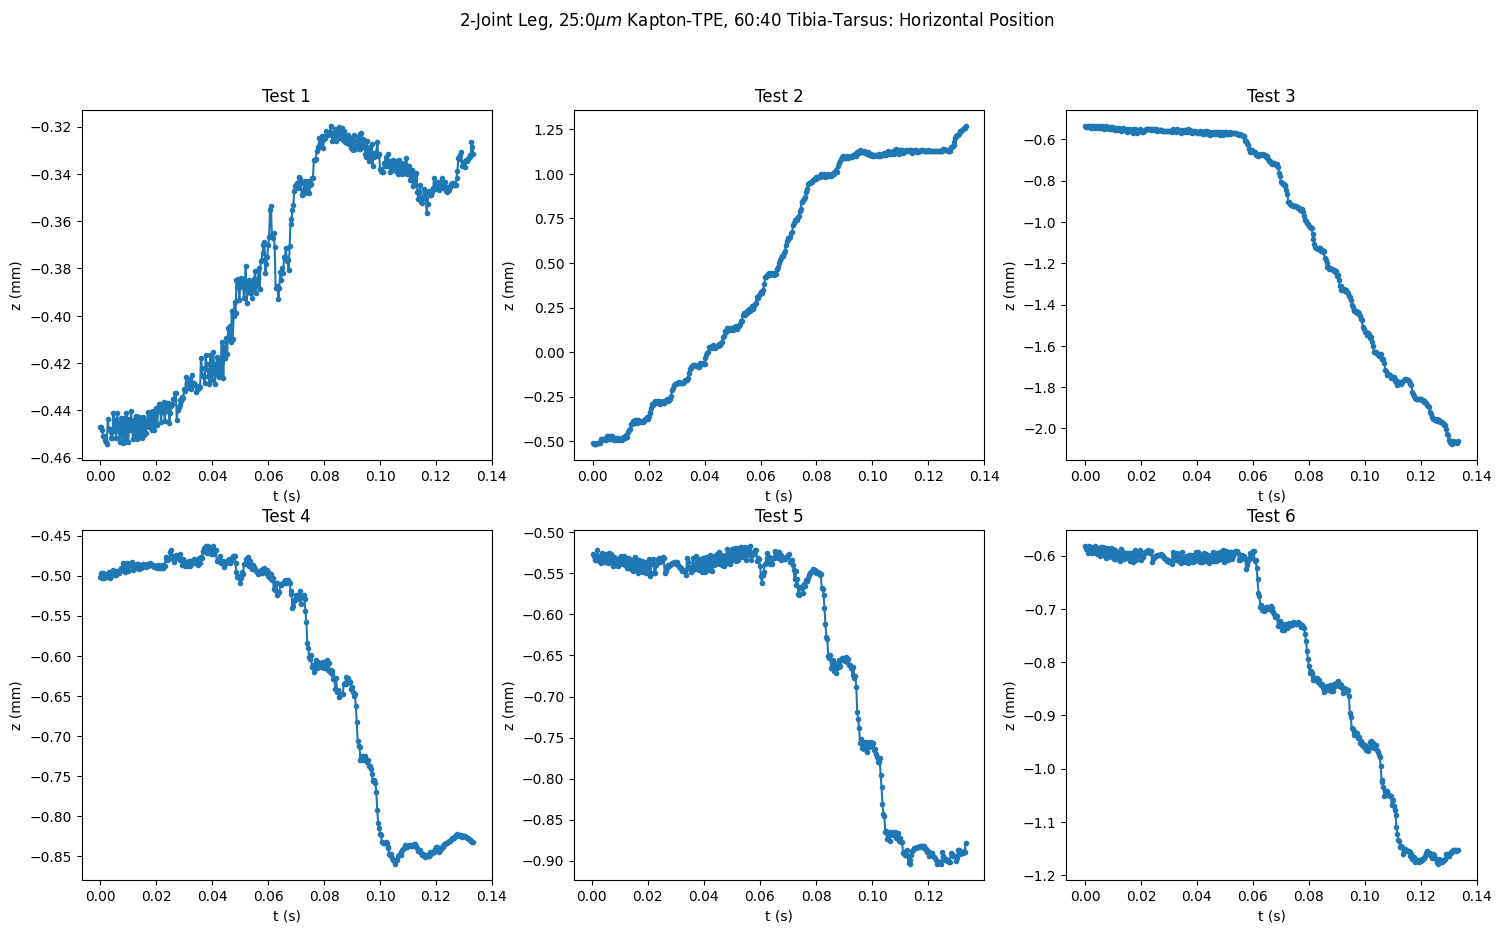

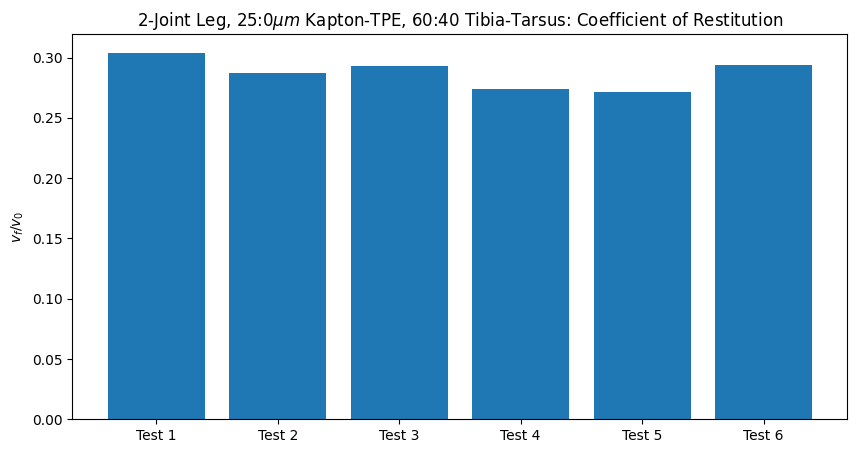

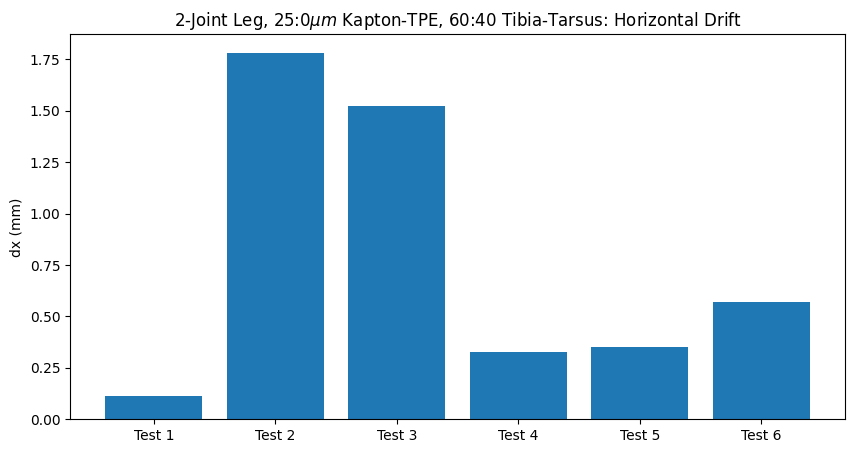

In [ ]:
current_dir = os.getcwd()
dir_path = current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-0um Kapton-TPE and 60-40 Tibia-Tarsus/"
plot_drop_test(dir_path, leg_name=r"2-Joint Leg, 25:0$\mu m$ Kapton-TPE, 60:40 Tibia-Tarsus")

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-7.5um Kapton-TPE and 40-60 Tibia-Tarsus/2joint_25-7-5um_40-60_45deg_test1_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-7.5um Kapton-TPE and 40-60 Tibia-Tarsus/2joint_25-7-5um_40-60_45deg_test6_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-7.5um Kapton-TPE and 40-60 Tibia-Tarsus/2joint_25-7-5um_40-60_45deg_test5_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-7.5um Kapton-TPE and 40-60 Tibia-Tarsus/

(0.31223306363291375,
 0.007957033061333845,
 0.6831050983333333,
 0.31835267935347855)

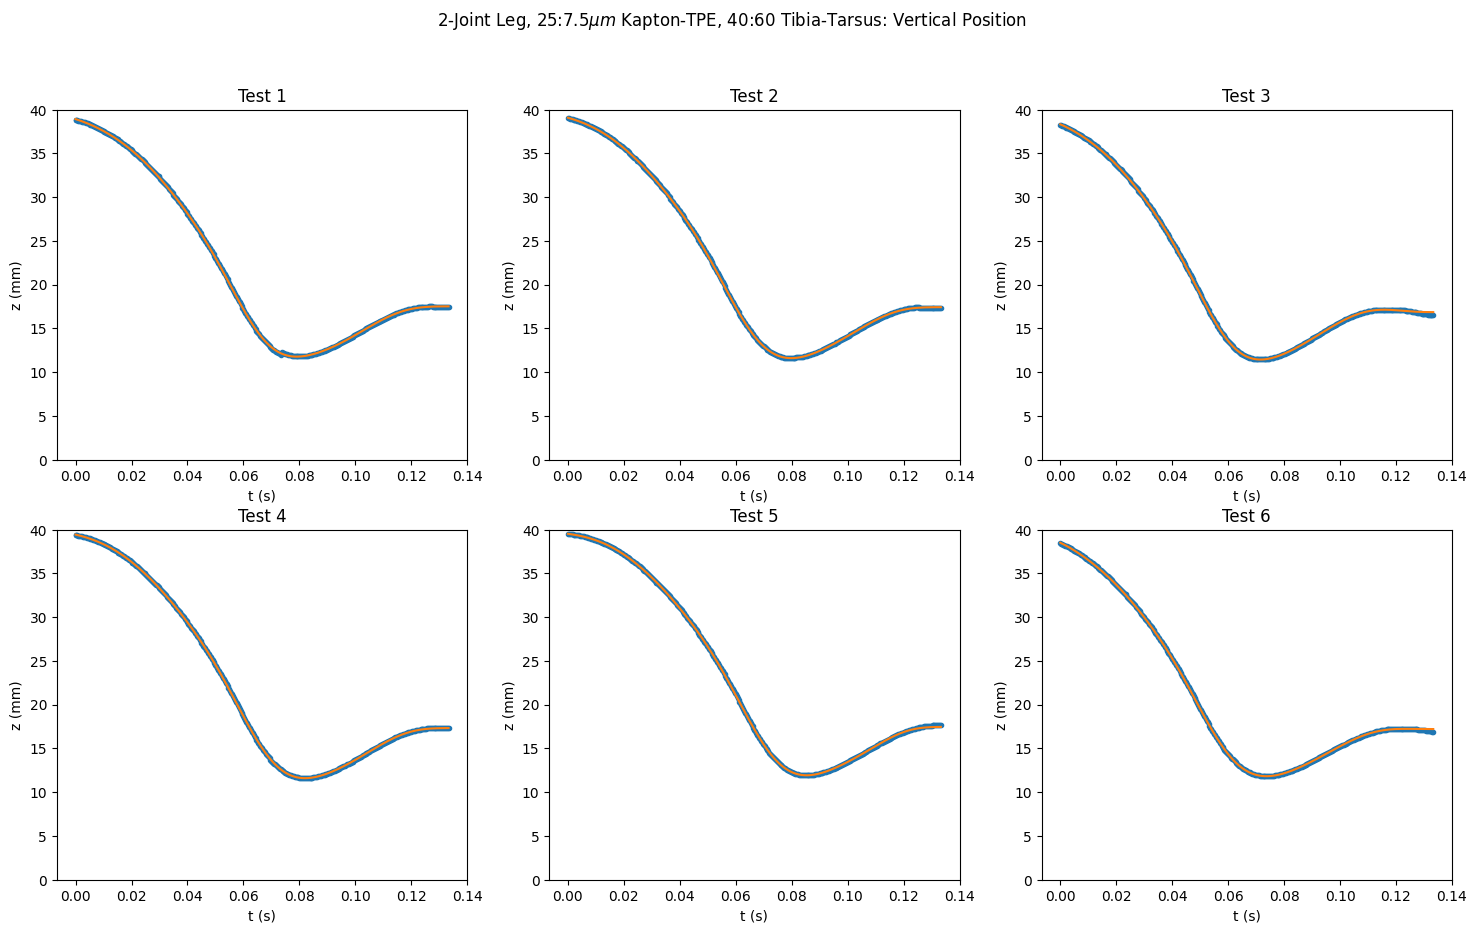

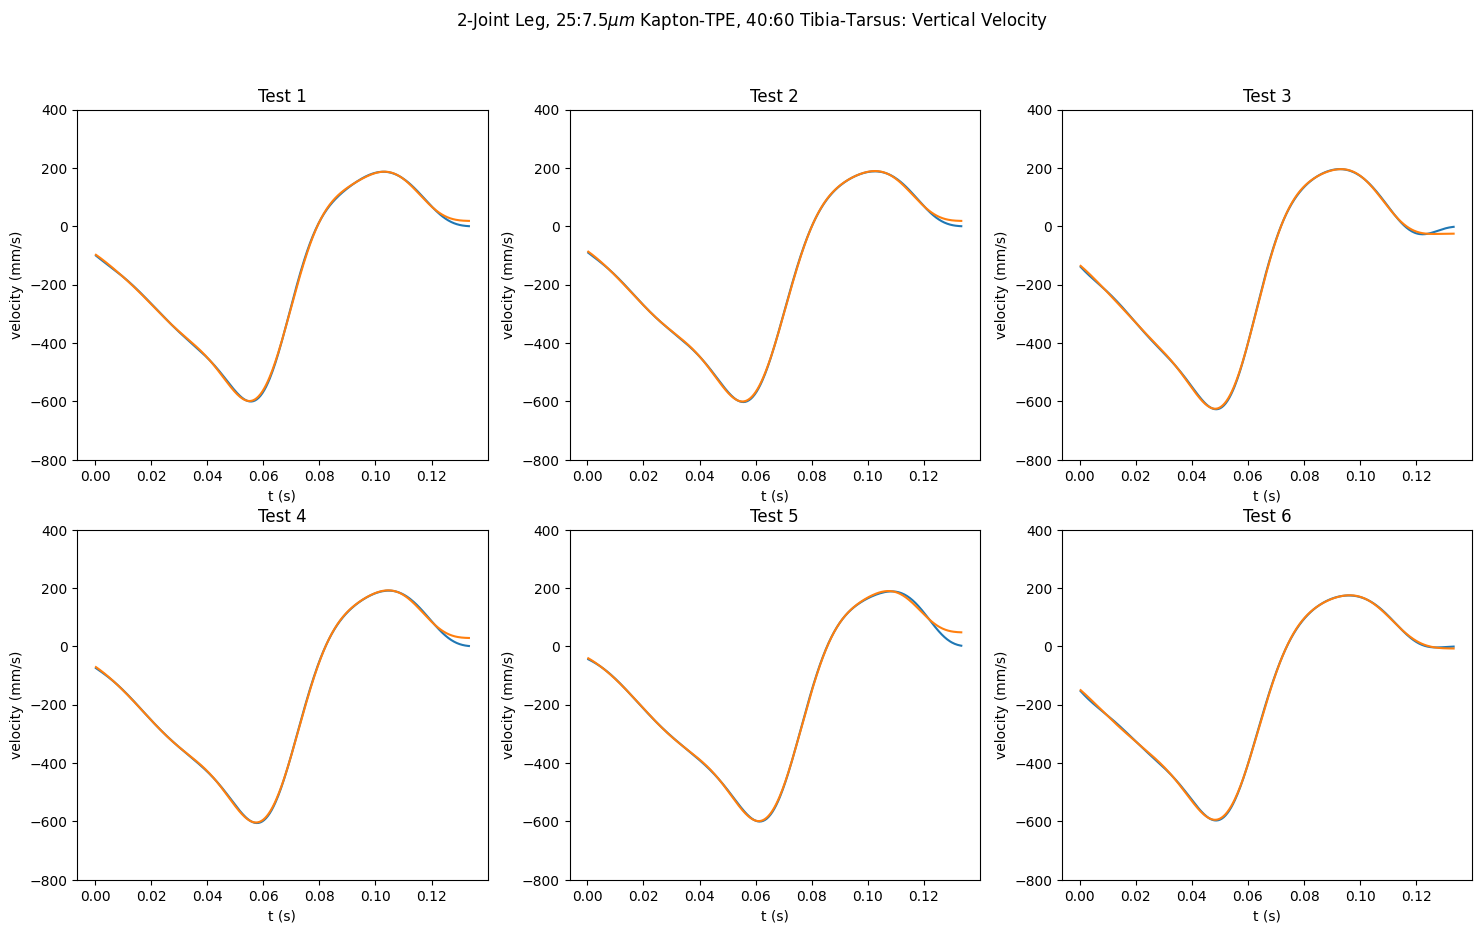

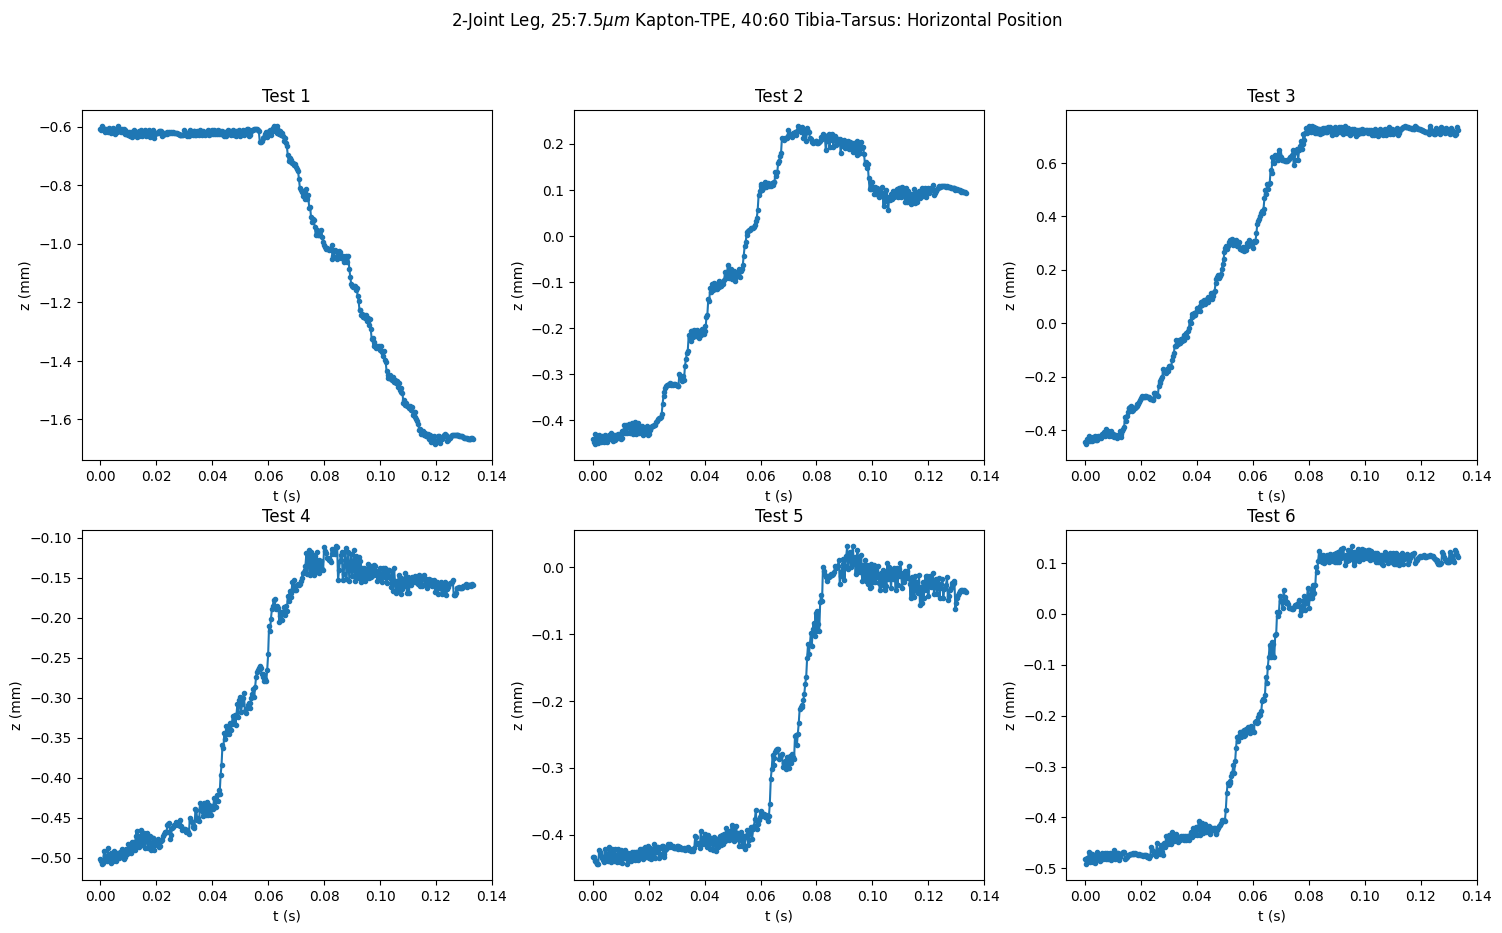

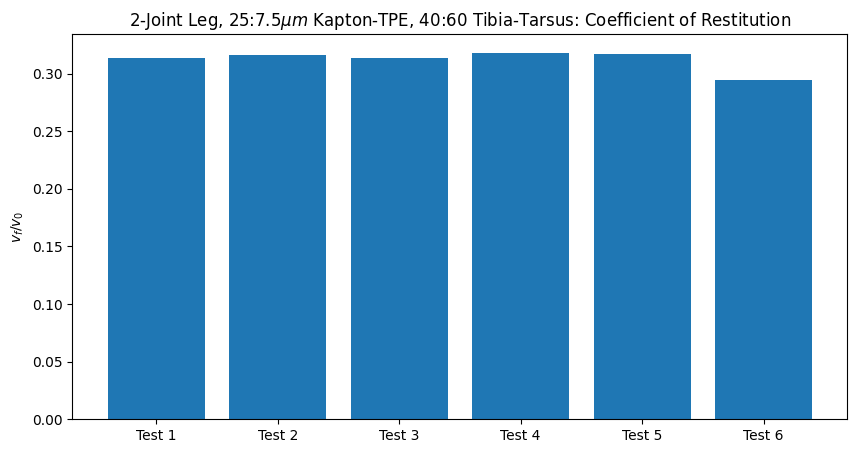

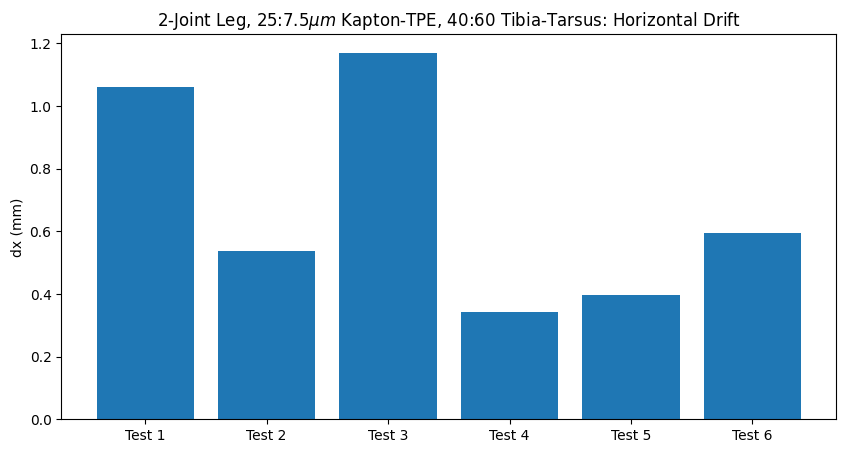

In [ ]:
current_dir = os.getcwd()
dir_path = current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-7.5um Kapton-TPE and 40-60 Tibia-Tarsus/"
plot_drop_test(dir_path, leg_name=r"2-Joint Leg, 25:7.5$\mu m$ Kapton-TPE, 40:60 Tibia-Tarsus")

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-7.5um Kapton-TPE and 60-40 Tibia-Tarsus/2joint_25-7-5um_60-40_45deg_test6_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-7.5um Kapton-TPE and 60-40 Tibia-Tarsus/2joint_25-7-5um_60-40_45deg_test1_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-7.5um Kapton-TPE and 60-40 Tibia-Tarsus/2joint_25-7-5um_60-40_45deg_test3_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-7.5um Kapton-TPE and 60-40 Tibia-Tarsus/

(0.29064536075842823, 0.006851234327714996, 2.871819, 0.7059408294912328)

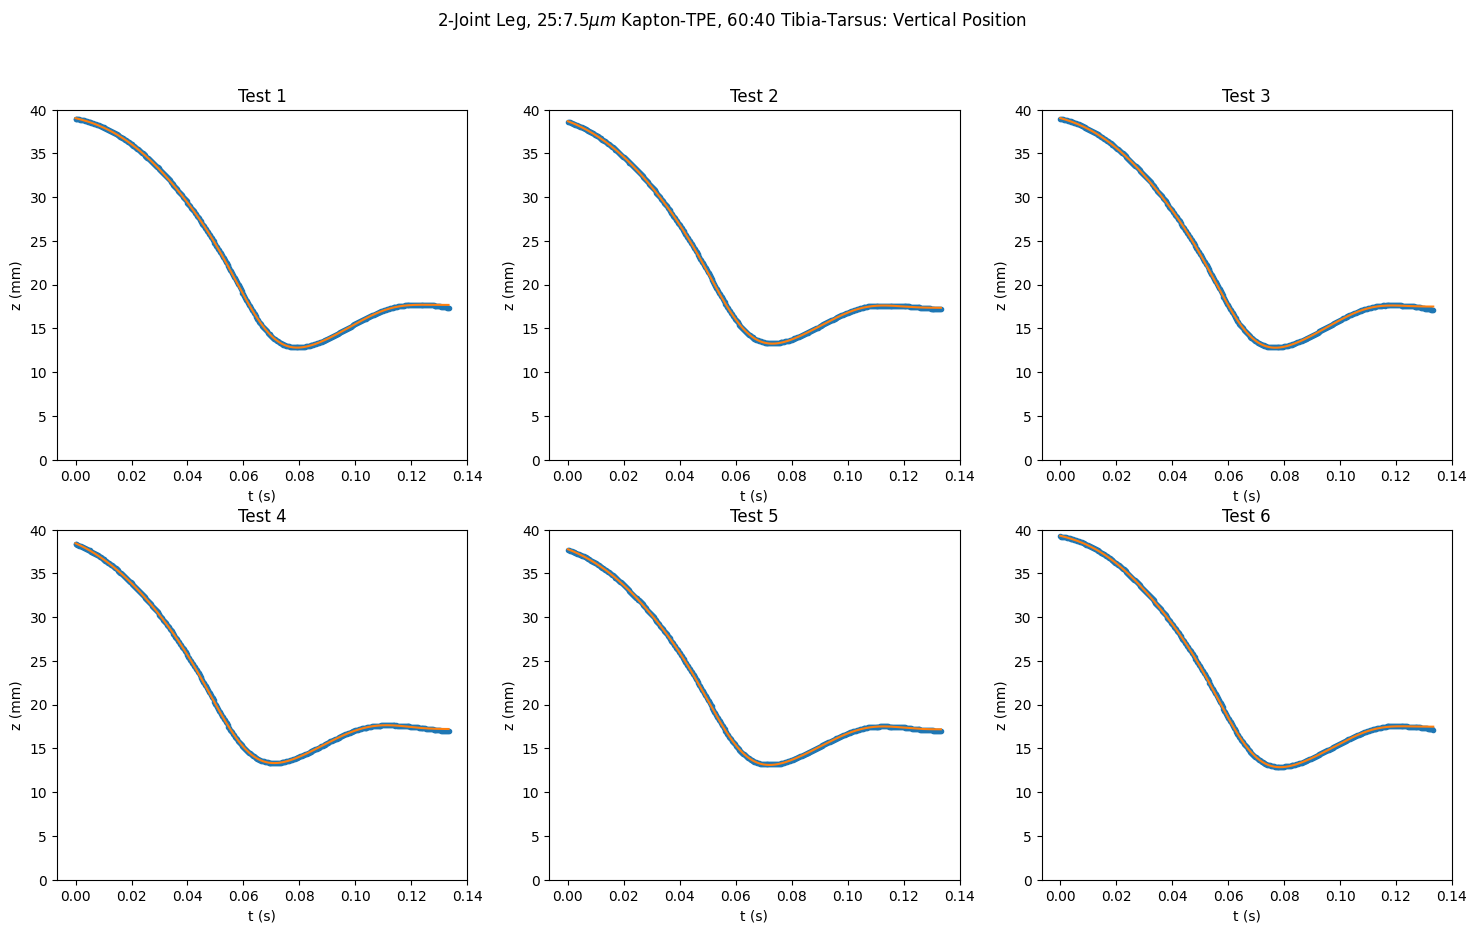

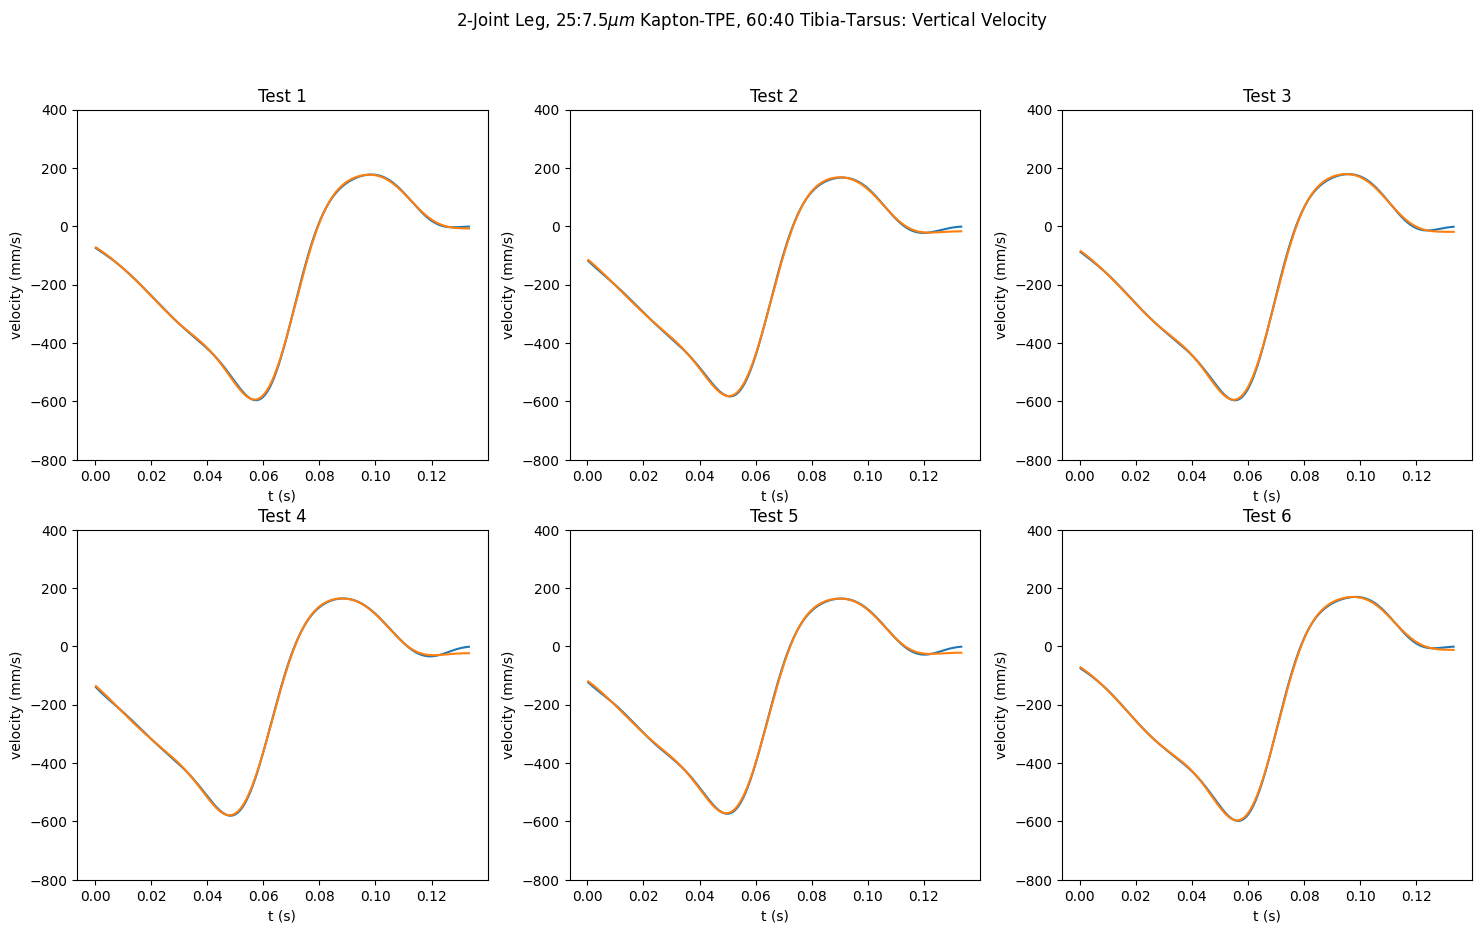

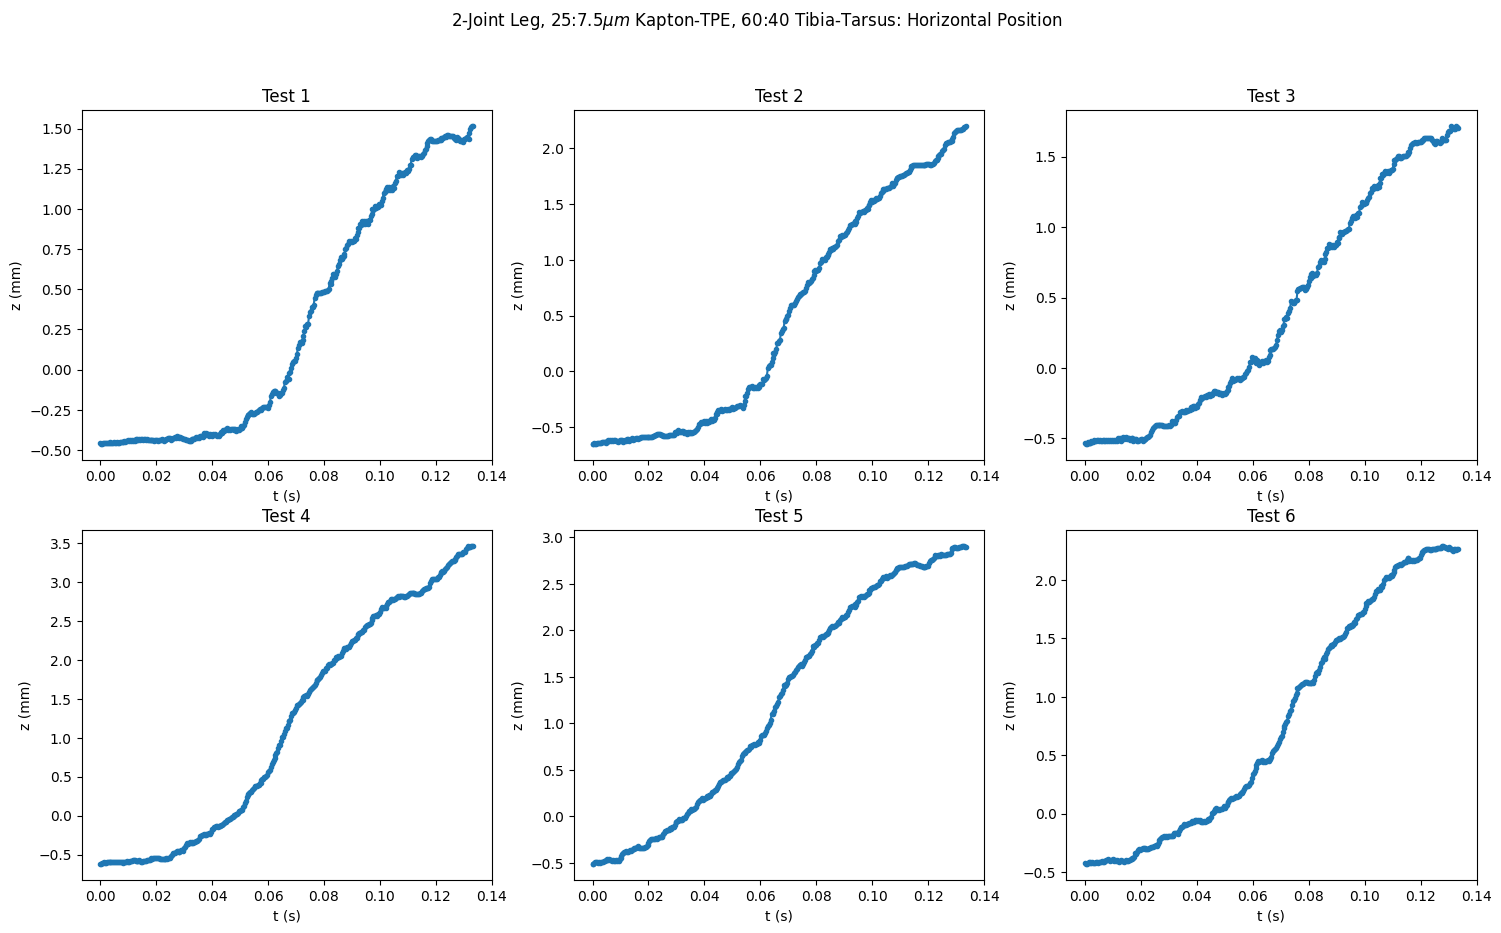

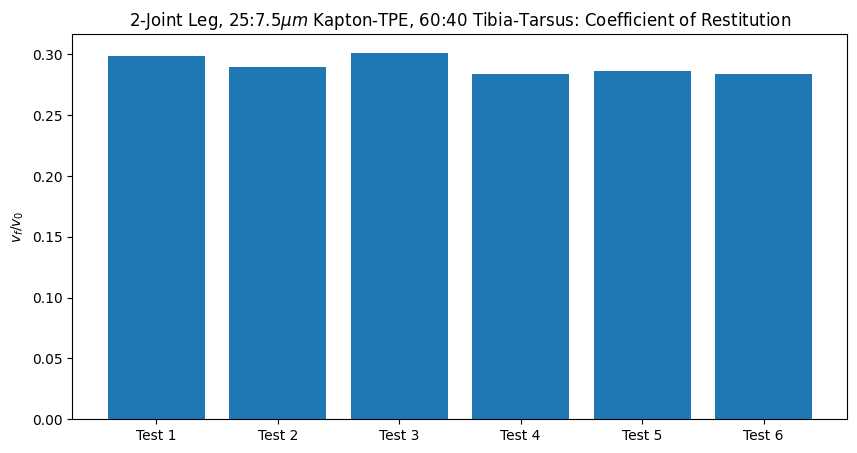

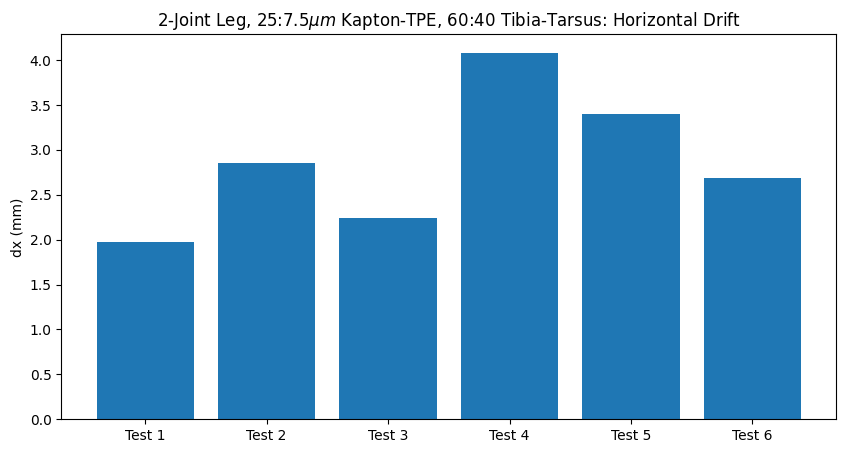

In [ ]:
current_dir = os.getcwd()
dir_path = current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-7.5um Kapton-TPE and 60-40 Tibia-Tarsus/"
plot_drop_test(dir_path, leg_name=r"2-Joint Leg, 25:7.5$\mu m$ Kapton-TPE, 60:40 Tibia-Tarsus")

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-25um Kapton-TPE and 40-60 Tibia-Tarsus/2joint_25-25um_40-60_45deg_test5_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-25um Kapton-TPE and 40-60 Tibia-Tarsus/2joint_25-25um_40-60_45deg_test2_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-25um Kapton-TPE and 40-60 Tibia-Tarsus/2joint_25-25um_40-60_45deg_test4_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-25um Kapton-TPE and 40-60 Tibia-Tarsus/2joint_

(0.17760597131725583,
 0.0159137024499567,
 1.4585276666666667,
 1.0254955305875701)

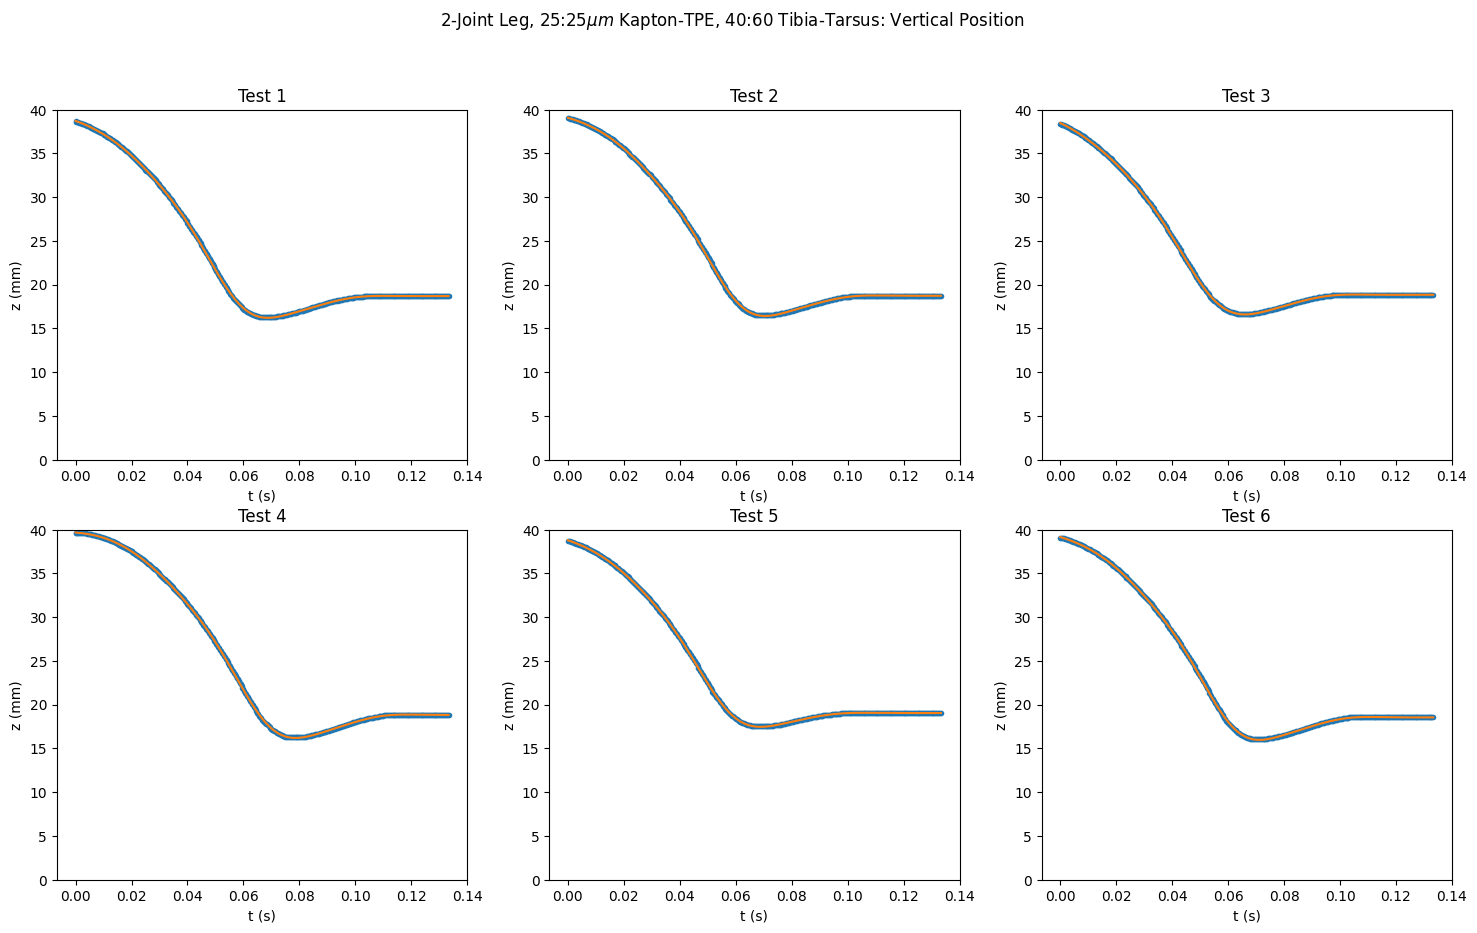

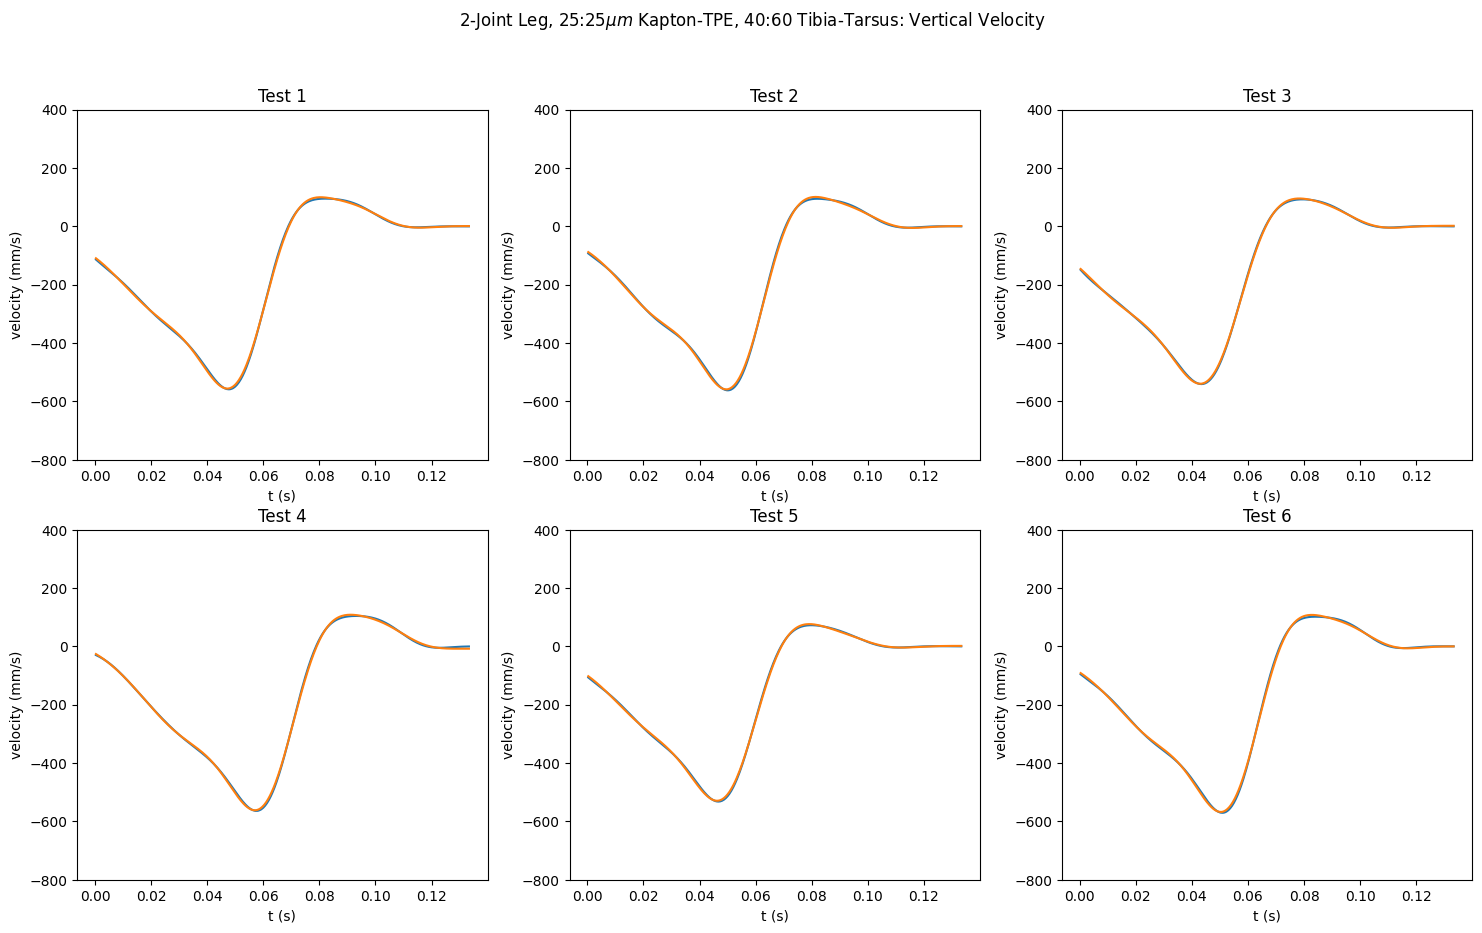

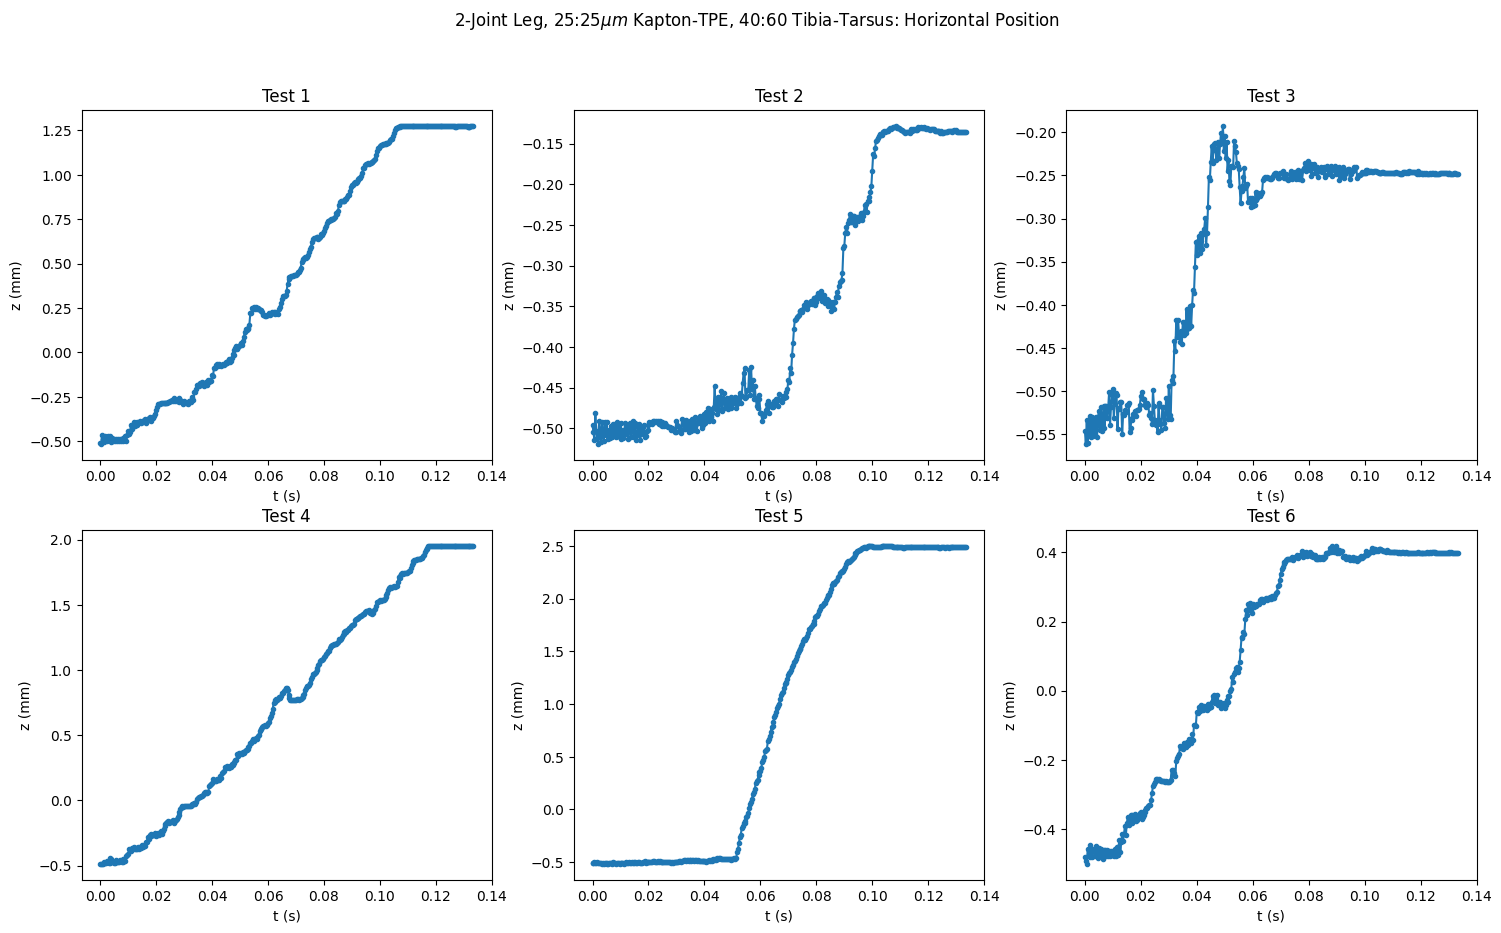

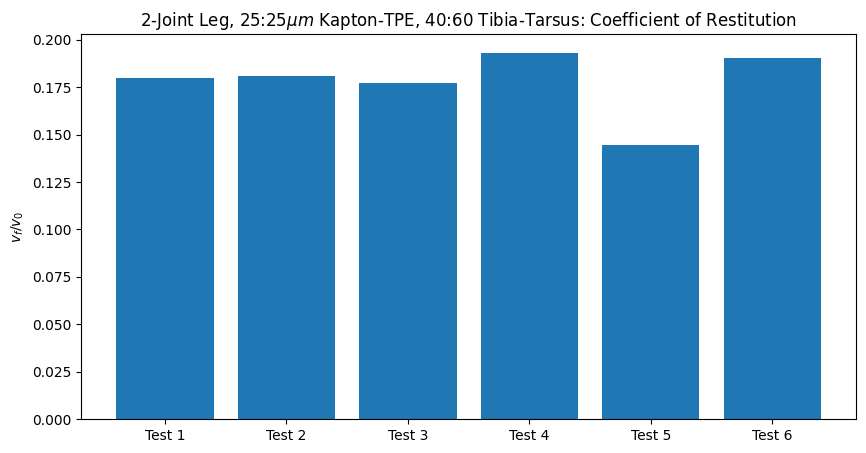

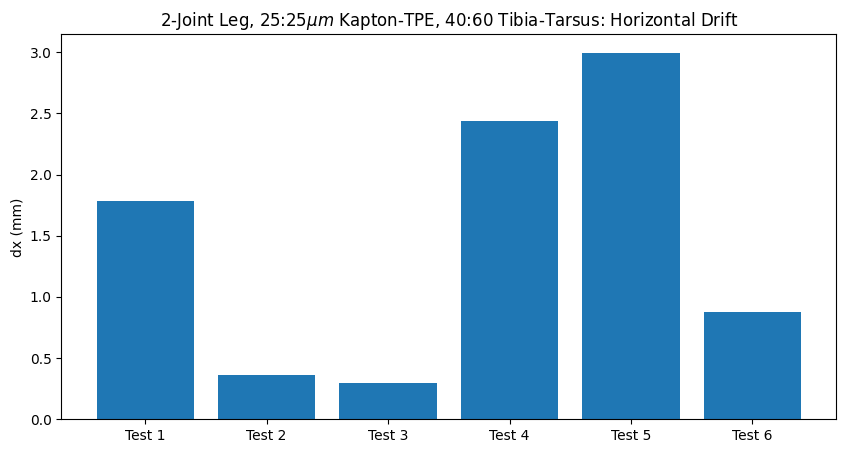

In [ ]:
current_dir = os.getcwd()
dir_path = current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-25um Kapton-TPE and 40-60 Tibia-Tarsus/"
plot_drop_test(dir_path, leg_name=r"2-Joint Leg, 25:25$\mu m$ Kapton-TPE, 40:60 Tibia-Tarsus")

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-25um Kapton-TPE and 60-40 Tibia-Tarsus/2joint_25-25um_60-40_45deg_test3_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-25um Kapton-TPE and 60-40 Tibia-Tarsus/2joint_25-25um_60-40_45deg_test4_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-25um Kapton-TPE and 60-40 Tibia-Tarsus/2joint_25-25um_60-40_45deg_test2_3000fps_400frames_success.txt
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Jupyter Notebooks/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-25um Kapton-TPE and 60-40 Tibia-Tarsus/2joint_

(0.24186212320408185,
 0.03127264827667867,
 1.4582272500000002,
 1.1918143260848237)

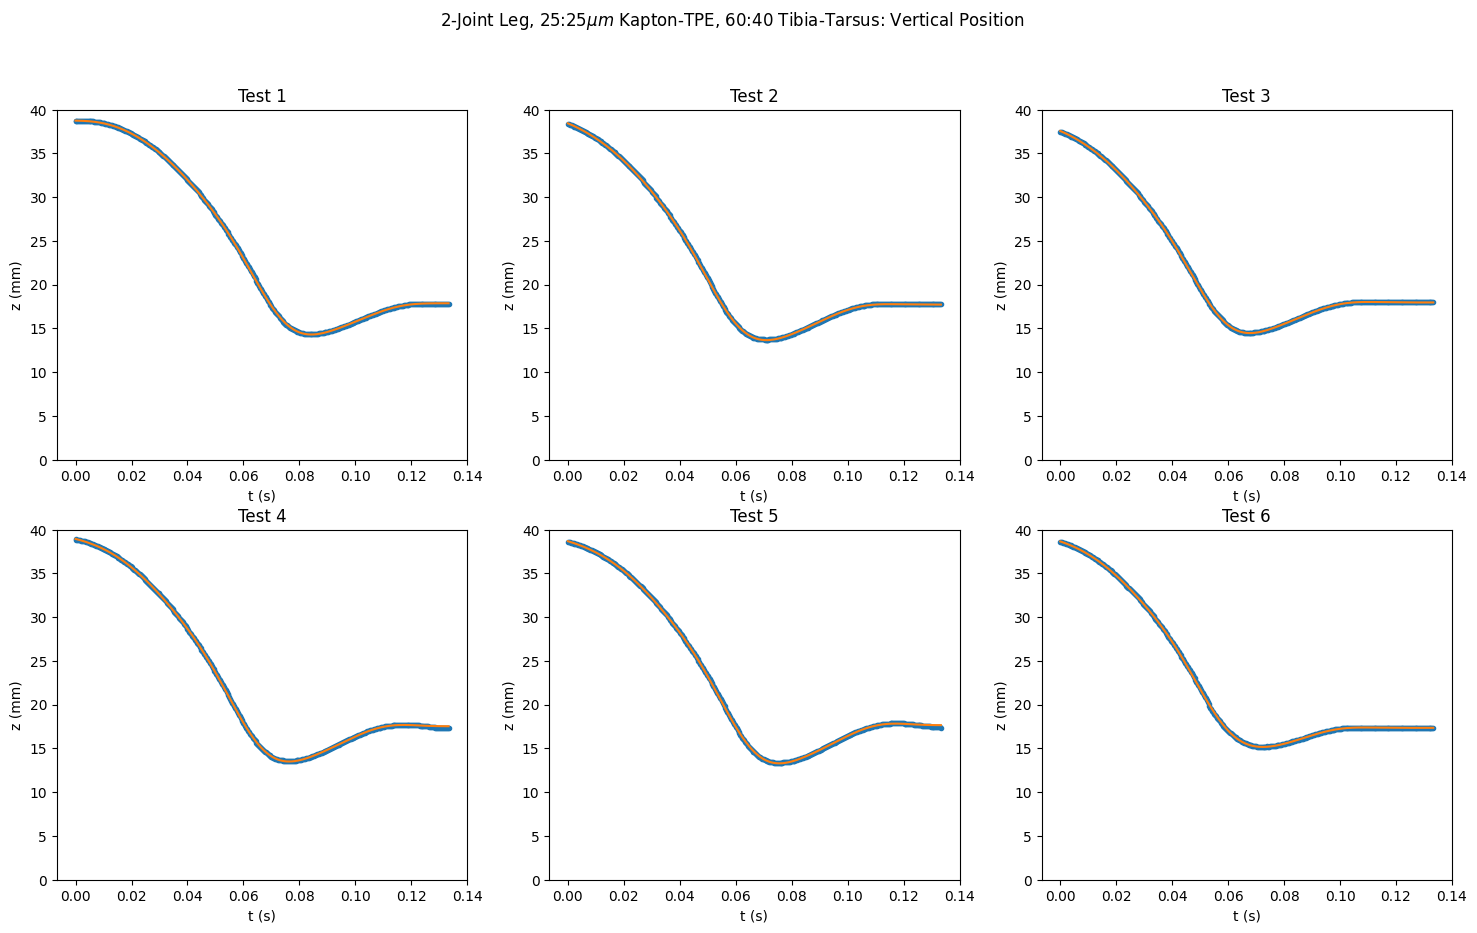

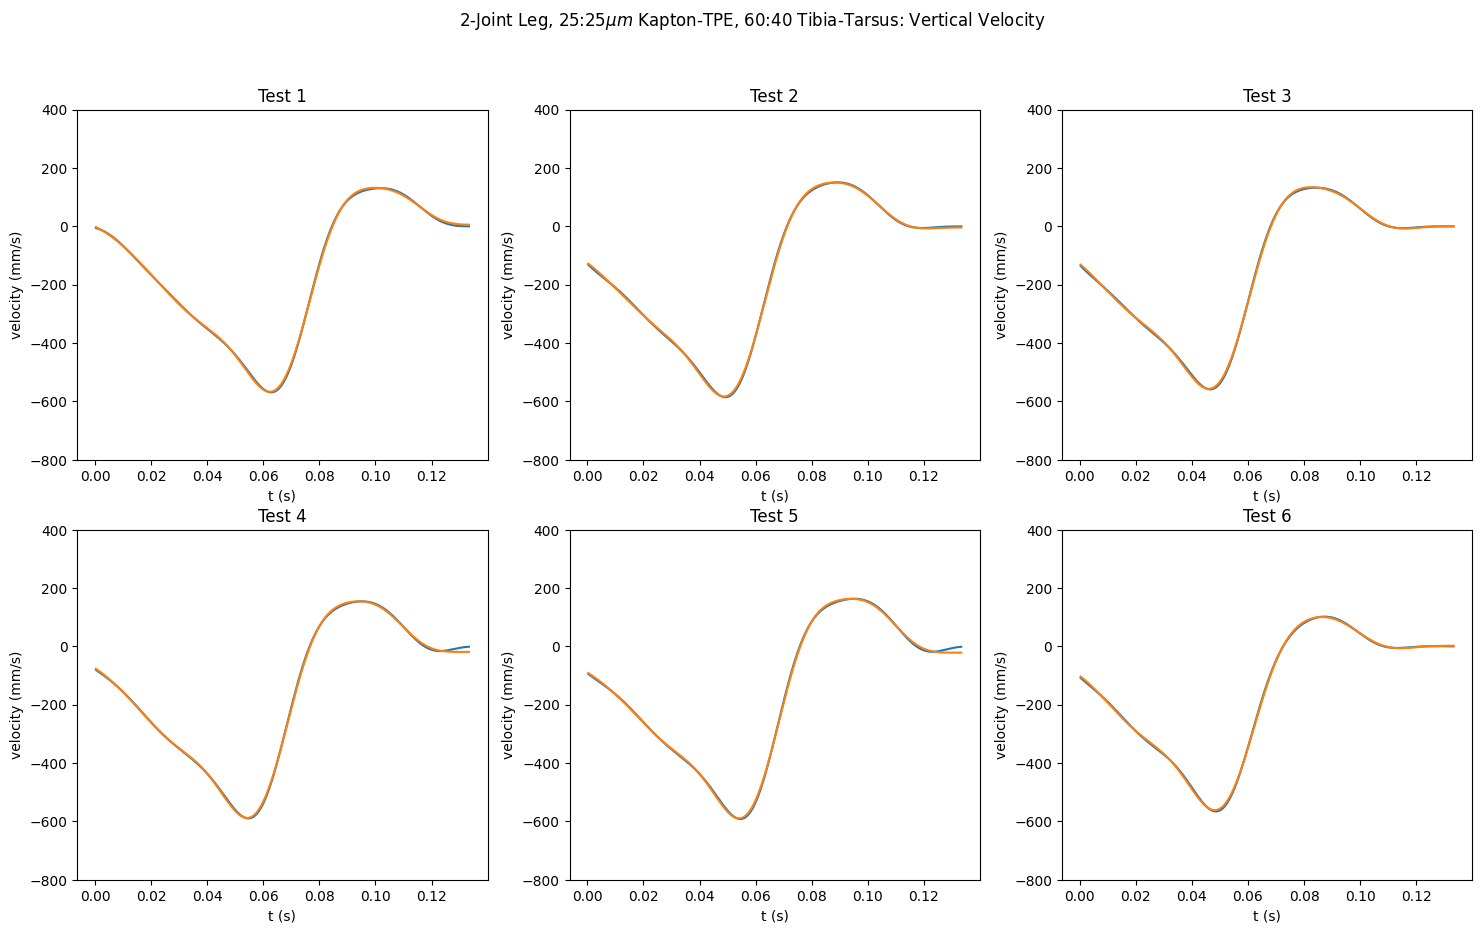

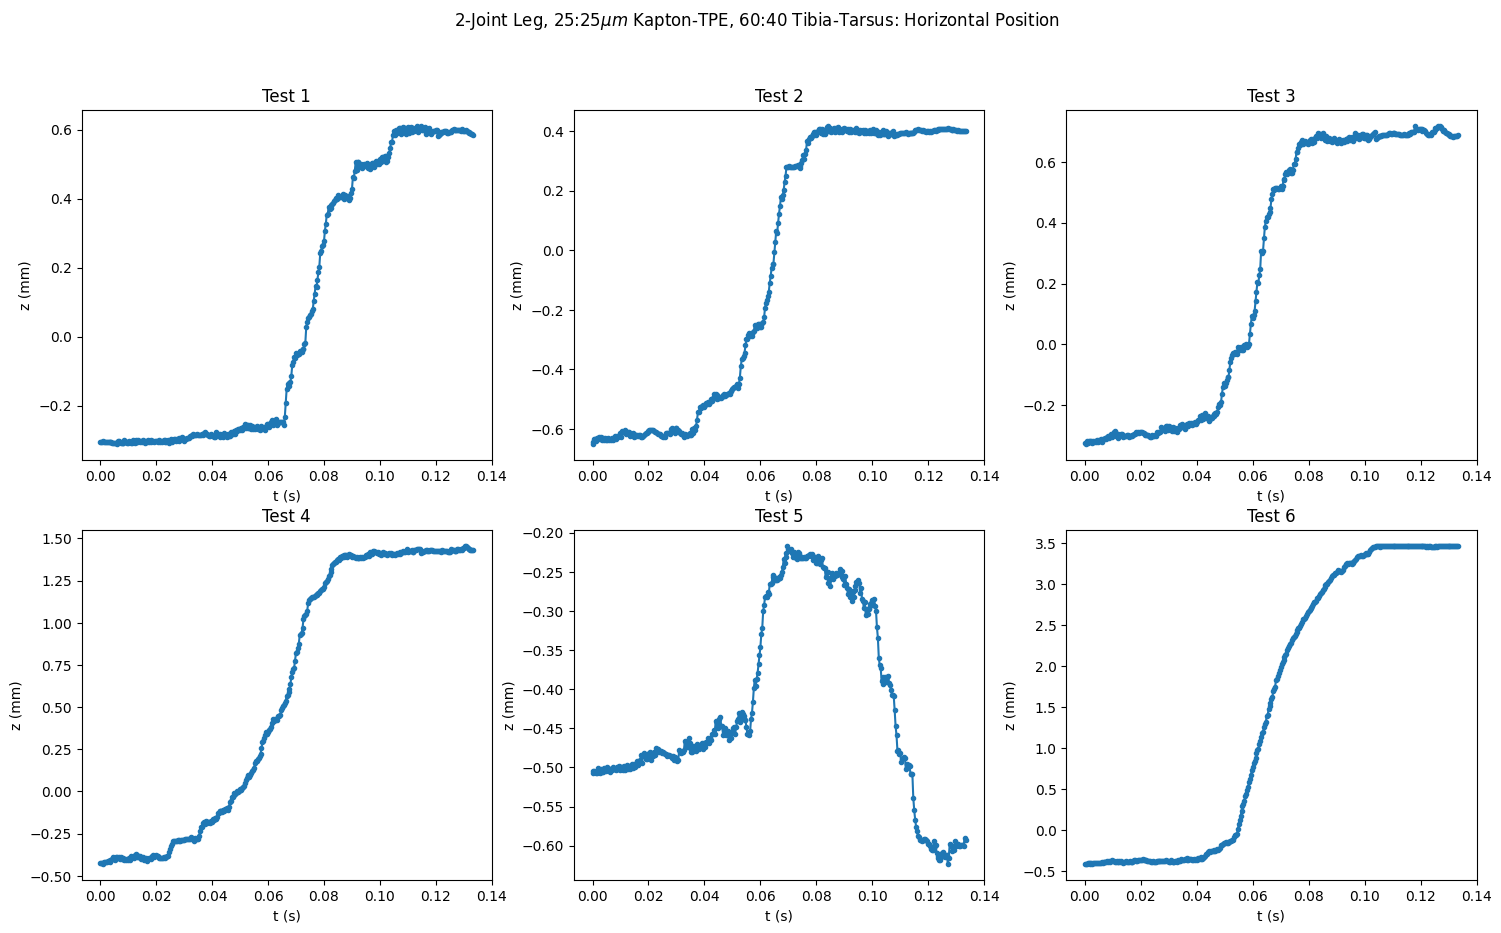

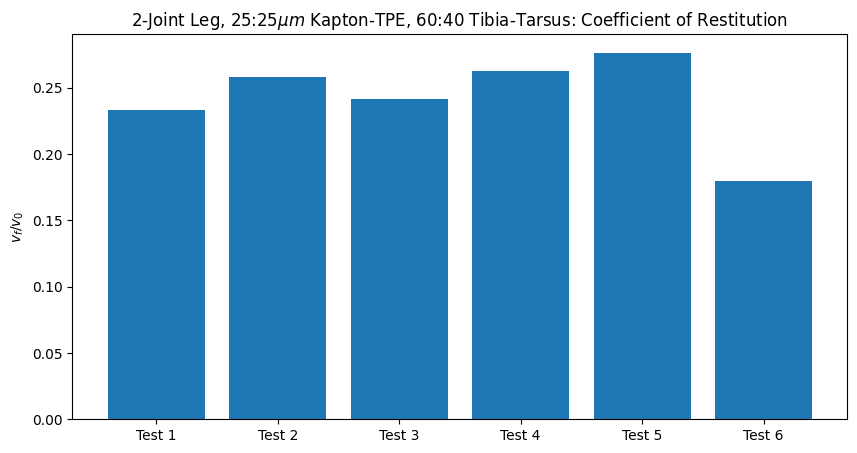

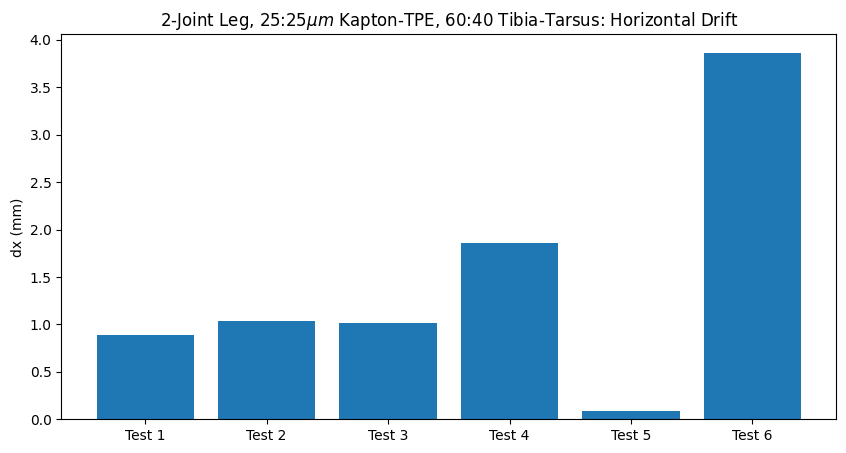

In [ ]:
current_dir = os.getcwd()
dir_path = current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-25um Kapton-TPE and 60-40 Tibia-Tarsus/"
plot_drop_test(dir_path, leg_name=r"2-Joint Leg, 25:25$\mu m$ Kapton-TPE, 60:40 Tibia-Tarsus")

# Compare Spring and Damping Constants 

In [ ]:
def get_b_and_k(dir_path):
    files = []

    # Iterate directory
    for path in os.listdir(dir_path):
        # check if current path is a file
        if os.path.isfile(os.path.join(dir_path, path)):
            if path[-3:] == "txt":
                files.append(dir_path + path)

    count = 0
    b_set = []
    k_set = []

    for i in range(len(files)):
        # print(files[i])
        if "v1" in dir_path:
            video_fps = 1000
            if "7-5um" in files[i]:
                num_frames = 1700
            elif "25um" in files[i]:
                num_frames = 1200
            else:
                num_frames = 600
            t, theta = extract_data(filename=files[count], start_row=2, video_fps=video_fps, num_frames=num_frames)

            # Normalize angle about 0deg
            theta = theta - np.mean(theta)
            p0=(10, 10, 10, 10, 100, 10)

        else:
            t, theta = extract_data(filename=files[count], start_row=2, video_fps=3000, num_frames=400)

            # Normalize angle about 0deg
            theta = theta - theta[-1]

            # Apply filter to raw position data
            fs = 3000  # Sampling frequency
            fc = 40  # Cut-off frequency of the filter
            theta = filter(theta, fs, fc)

            p0=(20, 30, 10, 10, 200, 40)

        # Optimize exponential decay
        exp_decay_opt, exp_decay_cov = scipy.optimize.curve_fit(underdamped_func, t, theta, p0=p0, bounds=(0,np.inf), max_nfev=5000)
        c1, c2, tau1, tau2, w1, w2 = exp_decay_opt

        tau = np.average((tau1, tau2))
        w = w1

        # print(f"c1: {c1}, c2: {c2}, tau1: {tau1}, tau2: {tau2}, w1: {w1}, w2: {w2}")
        # print(f"tau: {tau}, w: {w}")

        # Leg properties
        m_leg = 3e-6
        L_leg = 28e-3
        I_leg = 1/3 * m_leg * L_leg ** 2
        
        # Calculate b and k
        b = 2 * I_leg / tau
        k = I_leg * (w**2 + (1 / tau)**2)

        # print(f"b: {b}, k: {k}")

        b_set.append(b)
        k_set.append(k)

        # Update count
        count = count + 1

    b_mean = np.mean(b_set)
    b_std = np.std(b_set)
    # print(f"b_mean: {b_mean}")
    # print(f"b_std: {b_std}")

    k_mean = np.mean(k_set)
    k_std = np.std(k_set)
    # print(f"k_mean: {k_mean}")
    # print(f"k_std: {k_std}")

    return b_mean, b_std, k_mean, k_std

In [ ]:
current_dir = os.getcwd()

video_folders = {
    "TPE & No Kapton": current_dir + r"/../Compliant Legs/Flicker Test/Flicker Test v3/Buckle Joint/",
    "TPE & 7.5um Kapton": current_dir + r"/../Compliant Legs/Flicker Test/Flicker Test v3/7.5um Kapton-TPE Joint/",
    "TPE & 25um Kapton": current_dir + r"/../Compliant Legs/Flicker Test/Flicker Test v3/25um Kapton-TPE Joint/",
    "TPE & 50um Kapton": current_dir + r"/../Compliant Legs/Flicker Test/Flicker Test v3/50um Kapton-TPE Joint/",
}

b_and_k = np.zeros((len(video_folders), 4))

i = 0
test_names = []
for key in video_folders:
    test_names.append(key)
    dir_path = video_folders[key]
    b_and_k[i,:] = get_b_and_k(dir_path)
    i = i + 1

print(f"[b_mean, b_std, k_mean, k_std]:\n{b_and_k}")

[b_mean, b_std, k_mean, k_std]:
[[1.72681608e-07 1.08469852e-08 3.92216506e-05 3.84628021e-06]
 [1.79012124e-07 3.12668602e-09 4.36134918e-05 2.80862638e-06]
 [1.77691738e-07 1.01313947e-08 4.55165308e-05 2.07953121e-06]
 [1.69642990e-07 5.08560911e-09 4.98041862e-05 9.27393782e-07]]


[3.92216506e-05 4.36134918e-05 4.55165308e-05 4.98041862e-05]


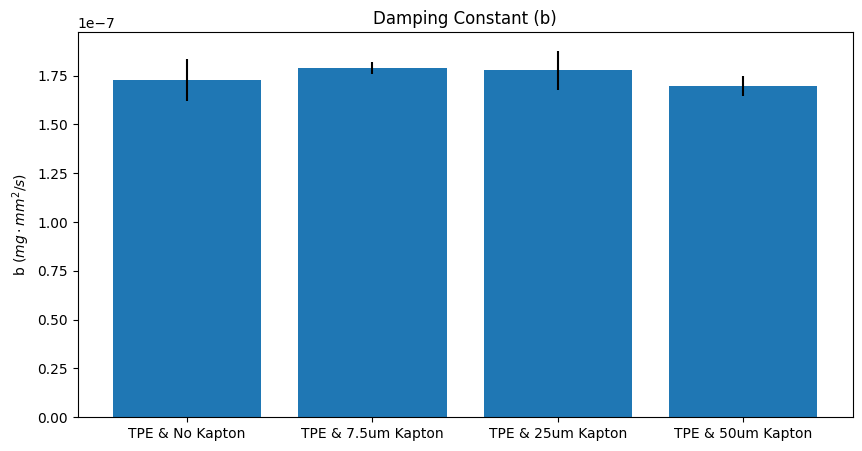

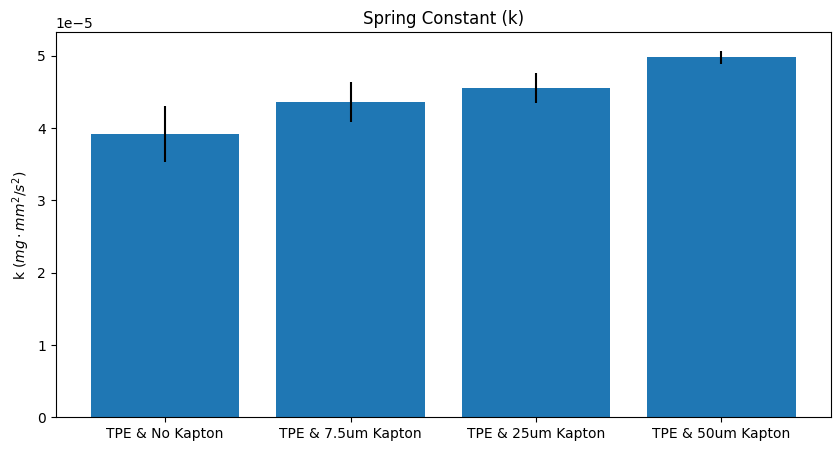

In [ ]:
fig_cor, ax_cor = plt.subplots(figsize=(10, 5))
ax_cor.set_title("Damping Constant (b)")
ax_cor.bar(test_names, b_and_k[:,0], yerr=b_and_k[:,1])
ax_cor.set_ylabel(r"b ($mg \cdot mm^2 / s$)")
# ax_cor.grid()
# plt.xticks(rotation=30, ha='right')

fig_drift, ax_drift = plt.subplots(figsize=(10, 5))
ax_drift.set_title("Spring Constant (k)")
ax_drift.bar(test_names, b_and_k[:,2], yerr=b_and_k[:,3])
ax_drift.set_ylabel(r"k ($mg \cdot mm^2 / s^2$)")
# ax_drift.grid()
# plt.xticks(rotation=30, ha='right')

print(b_and_k[:,2])

# Compare Coefficient of Restitution and Horizontal Drift 

In [ ]:
def get_cor_and_drift(dir_path):
    files = []

    # Iterate directory
    for path in os.listdir(dir_path):
        # check if current path is a file
        if os.path.isfile(os.path.join(dir_path, path)):
            if path[-3:] == "txt":
                files.append(dir_path + path)

    num_cols = int(len(files) / 2)
    num_rows = int(len(files) / num_cols)

    count = 0
    cor = []
    x_drift = []

    # Plot vertical position and velocity
    for i in range(num_rows):
        for j in range(num_cols):
            # print(files[i+j])
            t, x, z = extract_data(filename=files[count], start_row=2, video_fps=3000, num_frames=400)

            # Offset initial drop height
            z0 = 40
            z = z + z0
            
            # Apply filter to raw position data
            fs = 3000  # Sampling frequency
            fc = 40  # Cut-off frequency of the filter
            z_filter = filter(z, fs, fc)
            
            # Compute velocity and filter
            tdot, zdot = finite_forward_difference(t, z_filter)
            zdot_filter = filter(zdot, fs, fc)

            # Update drop test count
            count = count + 1

            v = zdot_filter
            cor.append(coefficient_of_restitution(v))

            dx = np.abs(x[-1] - x[0])
            x_drift.append(dx)

    cor_mean = np.mean(cor)
    cor_std = np.std(cor)
    # print(f"cor_mean: {cor_mean}")
    # print(f"cor_std: {cor_std}")

    x_drift_mean = np.mean(x_drift)
    x_drift_std = np.std(x_drift)
    # print(f"x_drift_mean: {x_drift_mean}")
    # print(f"x_drift_std: {x_drift_std}")

    return cor_mean, cor_std, x_drift_mean, x_drift_std

In [ ]:
current_dir = os.getcwd()

video_folders = {
    "Legacy": current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Legacy Leg/",
    r"Rigid, 30$^\circ$ Stance": current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Rigid Leg/30deg Stance/",
    r"Rigid, 45$^\circ$ Stance": current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Rigid Leg/45deg Stance/",
    r"Rigid, 60$^\circ$ Stance": current_dir + r"//../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Rigid Leg/60deg Stance/",
    r"1-Joint, TPE & 25$\mu m$ Kapton": current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/1-Joint Leg/25um Kapton-TPE Joint/",
    r"1-Joint, TPE & 0$\mu m$ Kapton": current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/1-Joint Leg/50um Kapton-TPE Joint/",
    r"2-Joint, TPE & 25:0$\mu m$ Kapton, 40:60 Tibia-Tarsus": \
        current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-0um Kapton-TPE and 40-60 Tibia-Tarsus/",
    r"2-Joints, TPE & 25:0$\mu m$ Kapton, 60:40 Tibia-Tarsus": \
        current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-0um Kapton-TPE and 60-40 Tibia-Tarsus/",
    r"2-Joints, TPE & 25:7.5$\mu m$ Kapton, 40:60 Tibia-Tarsus": \
        current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-7.5um Kapton-TPE and 40-60 Tibia-Tarsus/",
    r"2-Joints, TPE & 25:7.5$\mu m$ Kapton, 60:40 Tibia-Tarsus": \
        current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-7.5um Kapton-TPE and 60-40 Tibia-Tarsus/",
    r"2-Joints, TPE & 25:25$\mu m$ Kapton, 40:60 Tibia-Tarsus": \
        current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-25um Kapton-TPE and 40-60 Tibia-Tarsus/",
    r"2-Joints, TPE & 25:25$\mu m$ Kapton, 60:40 Tibia-Tarsus": \
        current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-25um Kapton-TPE and 60-40 Tibia-Tarsus/",
}

cor_and_drift = np.zeros((len(video_folders), 4))

i = 0
test_names = []
for key in video_folders:
    test_names.append(key)
    dir_path = video_folders[key]
    cor_and_drift[i,:] = get_cor_and_drift(dir_path)
    i = i + 1

print(f"[cor_mean, cor_std, x_drift_mean, x_drift_std]:\n{cor_and_drift}")

[cor_mean, cor_std, x_drift_mean, x_drift_std]:
[[4.14585077e-01 3.66079469e-02 1.05406079e+01 4.31002152e+00]
 [2.20393846e-01 3.31281530e-02 4.32784547e+00 1.89121194e+00]
 [2.37205261e-01 8.11527301e-02 1.78194041e+00 7.83462138e-01]
 [4.93840577e-01 6.47043041e-02 1.19976321e+00 1.00995986e+00]
 [2.87637750e-01 1.08945017e-02 7.17984082e-01 7.38762568e-01]
 [3.91525771e-01 1.26571270e-02 6.01547678e-01 5.67778286e-01]
 [1.61048827e-01 2.28734617e-02 6.85009362e-01 7.69518073e-01]
 [2.87190768e-01 1.15064509e-02 7.78929767e-01 6.36124456e-01]
 [3.12233064e-01 7.95703306e-03 6.83105098e-01 3.18352679e-01]
 [2.90645361e-01 6.85123433e-03 2.87181900e+00 7.05940829e-01]
 [1.77605971e-01 1.59137024e-02 1.45852767e+00 1.02549553e+00]
 [2.41862123e-01 3.12726483e-02 1.45822725e+00 1.19181433e+00]]


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Legacy'),
  Text(1, 0, 'Rigid, 30$^\\circ$ Stance'),
  Text(2, 0, 'Rigid, 45$^\\circ$ Stance'),
  Text(3, 0, 'Rigid, 60$^\\circ$ Stance'),
  Text(4, 0, '1-Joint, TPE & 25$\\mu m$ Kapton'),
  Text(5, 0, '1-Joint, TPE & 0$\\mu m$ Kapton'),
  Text(6, 0, '2-Joint, TPE & 25:0$\\mu m$ Kapton, 40:60 Tibia-Tarsus'),
  Text(7, 0, '2-Joints, TPE & 25:0$\\mu m$ Kapton, 60:40 Tibia-Tarsus'),
  Text(8, 0, '2-Joints, TPE & 25:7.5$\\mu m$ Kapton, 40:60 Tibia-Tarsus'),
  Text(9, 0, '2-Joints, TPE & 25:7.5$\\mu m$ Kapton, 60:40 Tibia-Tarsus'),
  Text(10, 0, '2-Joints, TPE & 25:25$\\mu m$ Kapton, 40:60 Tibia-Tarsus'),
  Text(11, 0, '2-Joints, TPE & 25:25$\\mu m$ Kapton, 60:40 Tibia-Tarsus')])

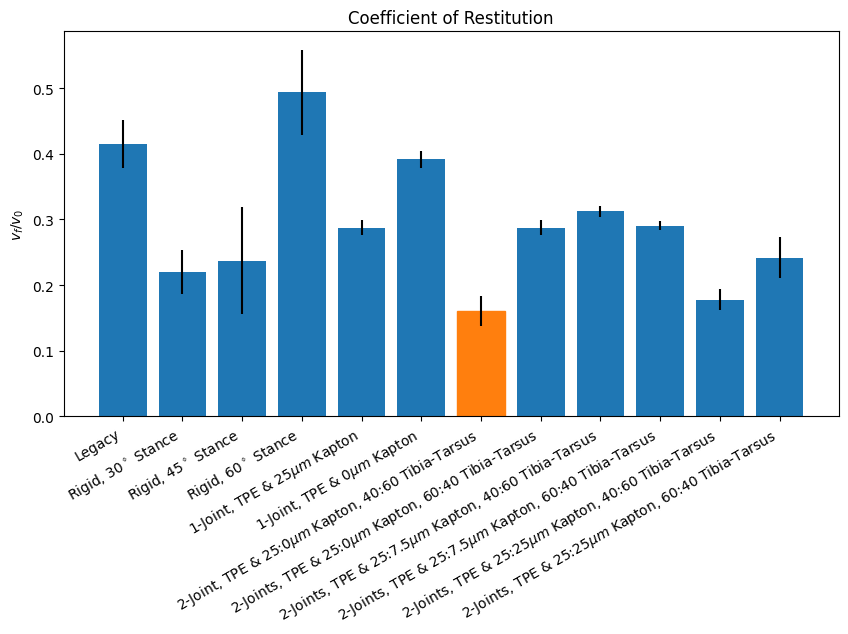

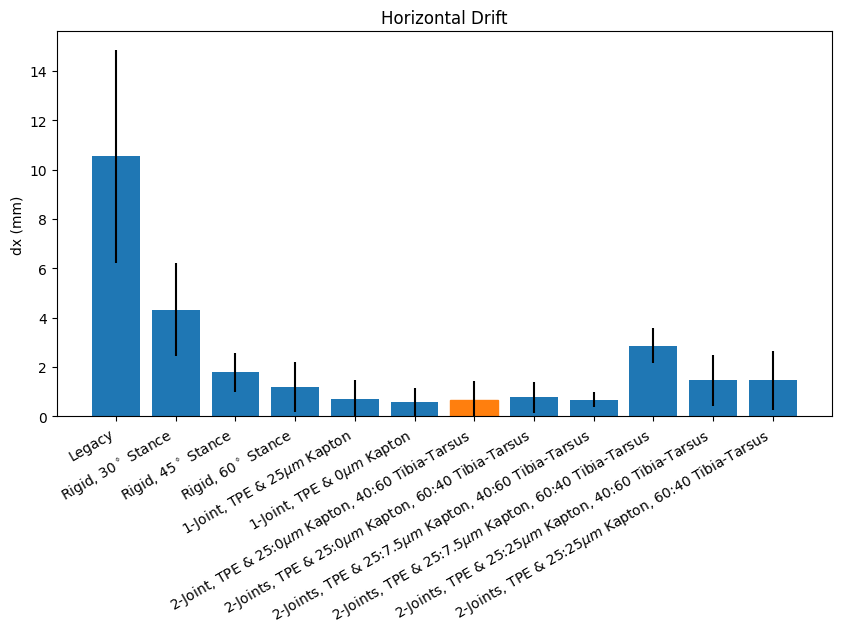

In [ ]:
fig_cor, ax_cor = plt.subplots(figsize=(10, 5))
ax_cor.set_title("Coefficient of Restitution")
barlist = ax_cor.bar(test_names, cor_and_drift[:,0], yerr=cor_and_drift[:,1])
barlist[6].set_color("tab:orange")
ax_cor.set_ylabel(r"$v_f / v_0$")
# ax_cor.grid()
plt.ylim(0,)
plt.xticks(rotation=30, ha='right')

fig_drift, ax_drift = plt.subplots(figsize=(10, 5))
ax_drift.set_title("Horizontal Drift")
barlist = ax_drift.bar(test_names, cor_and_drift[:,2], yerr=cor_and_drift[:,3])
barlist[6].set_color("tab:orange")
ax_drift.set_ylabel("dx (mm)")
# ax_drift.grid()
plt.ylim(0,)
plt.xticks(rotation=30, ha='right')